# Plotting single cell genomic signal and RNA-seq expression of *NFE2L2* in human and/or mouse brain

**Date:** 2023-06-26  
**Author:** Daniel Levings  

<br>

This is a **Jupyter Notebook** created to document my comparison of a mouse brain snATAC-seq (single nuclei assay for transposase accessible chromatin with sequencing) data set from [CATLAS](http://catlas.org/mousebrain/#!/), associated with first paper below, with scRNA-seq (single cell RNA sequencing) data sets from the Linnarsson lab's [Mouse brain atlas](http://mousebrain.org/), second and third papers below.  I also look at single cell RNA-seq of human brain datasets from UCSC CellBrowser and CELLxGENE (associated with papers 3-7 papers below) and another mouse brain scRNA-seq from [Dropviz](http://dropviz.org).  In this code, I identify which cell types in the mouse brain have both chromatin accessibility at the locus for the oxidative stress-linked transcription factor *Nfe2l2* and also show expression of *Nfe2l2*/*NFE2L2* in scRNA-seq.

<br>

1. [Li, Y.E., Preissl, S., Hou, X. et al. *An atlas of gene regulatory elements*](https://doi.org/10.1038/s41586-021-03604-1)  
   [*in adult mouse cerebrum*. (2021). Nature 598, 129–136.](https://doi.org/10.1038/s41586-021-03604-1)  
   [https://doi.org/10.1038/s41586-021-03604-1](https://doi.org/10.1038/s41586-021-03604-1)  


2. [Zeisel A, Hochgerner H, Lönnerberg P, et al. *Molecular Architecture of*](https://doi.org/10.1016/j.cell.2018.06.021)  
   [*the Mouse Nervous System*. Cell. 2018;174(4):999-1014.e1022.](https://doi.org/10.1016/j.cell.2018.06.021)  
   [https://doi.org/10.1016/j.cell.2018.06.021](https://doi.org/10.1016/j.cell.2018.06.021)  


3. [La Manno, G., Siletti, K., Furlan, A., et al. *Molecular architecture of the*](https://doi.org/10.1038/s41586-021-03775-x)  
   [*developing mouse brain*. Nature. 2021 Aug;596(7870):92-96. Epub 2021 Jul 28.](https://doi.org/10.1038/s41586-021-03775-x)  
   [https://doi.org/10.1038/s41586-021-03775-x](https://doi.org/10.1038/s41586-021-03775-x)  


4. [Bhaduri, A., Sandoval-Espinosa, C., Otero-Garcia, M. et al. *An atlas of*](https://doi.org/10.1038/s41586-021-03910-8)  
   [*cortical arealization identifies dynamic molecular signatures.*](https://doi.org/10.1038/s41586-021-03910-8)  
   [Nature 598, 200–204 (2021). https://doi.org/10.1038/s41586-021-03910-8](https://doi.org/10.1038/s41586-021-03910-8)  


5. [Leng, K., et al., *Molecular characterization of selectively vulnerable*](https://doi.org/10.1038/s41593-020-00764-7)  
   [*neurons in Alzheimer's disease.* Nat Neurosci, 2021. 24(2): p. 276-287.](https://doi.org/10.1038/s41593-020-00764-7)  
   [https://doi.org/10.1038/s41593-020-00764-7](https://doi.org/10.1038/s41593-020-00764-7)  


6. [Schirmer, L., et al., *Neuronal vulnerability and multilineage diversity*](https://doi.org/10.1038/s41586-019-1404-z)  
   [*in multiple sclerosis.* Nature, 2019. 573(7772): p. 75-82.](https://doi.org/10.1038/s41586-019-1404-z)  
   [https://doi.org/10.1038/s41586-019-1404-z](https://doi.org/10.1038/s41586-019-1404-z)  


7. [Velmeshev, D., et al., *Single-cell genomics identifies cell type-specific*](https://doi.org/10.1126/science.aav8130)  
   [*molecular changes in autism.* Science, 2019. 364(6441): p. 685-689.](https://doi.org/10.1126/science.aav8130)  
   [https://doi.org/10.1126/science.aav8130](https://doi.org/10.1126/science.aav8130)  


8. [Saunders, Arpiar, et al. *Molecular diversity and specializations among the*](https://doi.org/10.1016/j.cell.2018.07.028)  
   [*cells of the adult mouse brain*. Cell 174.4 (2018): 1015-1030.](https://doi.org/10.1016/j.cell.2018.07.028)  
   [https://doi.org/10.1016/j.cell.2018.07.028](https://doi.org/10.1016/j.cell.2018.07.028)  

<br>

## Set up environment  

First, I need to set up my environment by loading the appropriate modules.  Then check Python version and loaded modules.

In [1]:
# Import modules
import os
import sys
import requests
import re
import itertools
import math
from collections.abc import Iterable
import datetime
from datetime import date
import xlsxwriter
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
import statsmodels
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import sklearn as sk
import statistics
import loompy
import pyBigWig
import plotnine as p9
import matplotlib as mpl
from matplotlib import rc
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pylab as pl
import patchworklib as pw
%matplotlib inline

# Allow for multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

<br>
Then check Python version and loaded modules.

In [2]:
print(sys.version_info)
modulenames = set(sys.modules) & set(globals())
print(modulenames)
del(modulenames)

sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)
{'math', 'xlsxwriter', 'requests', 'itertools', 're', 'loompy', 'pyBigWig', 'datetime', 'statsmodels', 'os', 'sys', 'statistics'}


<br>

## Functions  

Here I define all custom functions used in the notebook.  

In [3]:
# helper function to get significant digits
def signif(x, digits=6):
    """Will round a number to a given number of significant digits.

    Args:
        x (float): a numeric to be rounded
        digits (int): Desired number of digits to round to. Defaults to 6.

    Returns:
        float: rounded number
    """

    if x == 0 or not math.isfinite(x):
        return x
    digits -= math.ceil(math.log10(abs(x)))
    return round(x, digits)

# helper function to flatten list
def flatten(xs):
    """Flattens a list of lists into a single list.

    Args:
        xs (list): a list of lists and/or ranges

    Returns:
        list: a single-level ('flattened') list
    """

    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

# Function to loop through a list and identify from a list of numbers (which are genomic intervals)
# which element would be the next highest or next lowest to the number, and then return
# a list of logicals for indexing the list of intervals
def find_interval(intervals, value, gtlt = "closest"):
    """This function identifies the next highest or next lowest element in a list of numbers

    Given a list of numbers (which are typically genomic intervals), this function will 
        identify which element would be the next highest, next lowest, or simply the closest
        element to the number, and then return a list of logicals for indexing the list 
        of intervals

    Args:
        intervals (array/list): an array or list of integers (typically genomic intervals)
        value (integer/float): 'target' number you want to find the closest interval to
        gtlt (str, optional): 'greater', 'less', or 'closest'. Determines whether the function
            finds the next highest, lowest, or closest interval. Defaults to "closest".
    
    Returns:
        logical: a list of logicals that can be used to index the list of intervals and return
            the desired interval
    """

    if (gtlt == "closest"):
        hval = np.min(np.array(intervals)[np.array([x >= value for x in np.array(intervals)])])
        lval = np.min(np.array(intervals)[np.array([x <= value for x in np.array(intervals)])])
        if (np.abs(hval - value) > np.abs(lval - value)):
            val = lval
        elif (np.abs(hval - value) < np.abs(lval - value)):
            val = hval
        else:
            raise "Value is perfectly between two intervals."
    elif (gtlt == "greater"):
        val = np.min(np.array(intervals)[np.array([x > value for x in np.array(intervals)])])
    elif (gtlt == "less") :
        val = np.max(np.array(intervals)[np.array([x < value for x in np.array(intervals)])])
    else:
        raise "Please specify gtlt as one of the following: 'closest', 'greater' or 'less' only."
    return list(intervals == val)

# Make function to import bigwigs using pyBigWig, then do summary statistics, and add each set of
# of statistics to a matrix, file-by-file with each row being a separate bigwig
def compute_matrix(bw_list, chrom, start, end, avgtype = "max", nBins = 1080, bw_names = None):
    """Base function to compute a dataframe of summary statistics for list of bigwig files

    Args:
        bw_list (list): list of bigwig file paths
        chrom (string): chromosome name (eg- "chr2")
        start (int): start coordinate
        end (int): end coordinate
        avgtype (str, optional): type of summarization, can be "max", "min", "coverage", or "std" 
            (standard deviation of the values). Defaults to "max".
        nBins (int, optional): The number of 'bins'/windows to split the interval into. Defaults to 1080.
        bw_names (list, optional): Optional list of names to use instead of the filepaths. Defaults to None.

    Returns:
        dataframe: a dataframe/array of the summary statistics for each bigwig file with the rows being 
           each file and the columns the bins the interval was split into
    """

    new_bw_names=[]
    bw_results=[]
    for i in range(0,len(bw_list)):
        bw_name=re.sub("\.(bigwig)|(bw)|(bigWig)]$", "", str(bw_list[i]))
        bw_name=re.sub(".*\/","",bw_name)
        new_bw_names.append(bw_name)
        bw = pyBigWig.open(bw_list[i])
        if not bw.isBigWig():
            raise BigwigValidError(str(bw_list[i] + " is not a valid bigwig file."))
        bw_results.append(bw.stats(chrom, start = start, end = end, type = avgtype, 
            nBins = nBins, exact = True))
    if bw_names is None:
        bw_names=new_bw_names
    bw_df = pd.DataFrame(bw_results)
    bw_df.index = bw_names
    return(bw_df)

class BigwigValidError(Exception):
    pass

def bigwig_matrix(bw_list, chrom, start, end, avgtype = "max", nBins = 1080, bw_names = None):
    """Wrapper to run the compute_matrix function and return a dataframe of summary statistics 
        for list of bigwig files

    Args:
        bw_list (list): list of bigwig file paths
        chrom (string): chromosome name (eg- "chr2")
        start (int): start coordinate
        end (int): end coordinate
        avgtype (str, optional): type of summarization, can be "max", "min", "coverage", or "std" 
            (standard deviation of the values). Defaults to "max".
        nBins (int, optional): The number of 'bins'/windows to split the interval into. Defaults to 1080.
        bw_names (list, optional): Optional list of names to use instead of the filepaths. Defaults to None.
    
    Returns:
        dataframe: a dataframe/array of the summary statistics for each bigwig file with the rows being 
           each file and the columns the bins the interval was split into
    """

    try:
        final_mat = compute_matrix(bw_list = bw_list, chrom = chrom, start = start, end = end, \
            avgtype = avgtype, nBins = nBins, bw_names = bw_names)
    except BigwigValidError as e:
        print(str(e))
    return(final_mat)

In [4]:
# Check helpers
signif(0.024556, 3)
list(flatten(["0","1","2",["3","4",["5"]]]))
find_interval(list(flatten(([0,1,2,[range(3,5),[5]]]))),2.6,"closest")

0.0246

['0', '1', '2', '3', '4', '5']

[False, False, False, True, False, False]

<br>

## Download and import the data  

Download the scRNA-seq data for adolescent brain from Linnarsson lab's [Mouse brain atlas](http://mousebrain.org/adolescent/).  [Loompy.org](http://loompy.org) has more detailed information on the file format specifications (Loom files) as well as how to use various API to access these files.  

In [5]:
URL = "https://storage.googleapis.com/linnarsson-lab-loom/l5_all.agg.loom"
response = requests.get(URL)
open("l5_all.agg.loom", "wb").write(response.content)

URL = "https://storage.googleapis.com/linnarsson-lab-loom/dev_all.agg.loom"
response = requests.get(URL)
open("dev_all.agg.loom", "wb").write(response.content)

In [6]:
# Check to make sure it's in current directory
os.listdir()

['human_AD-Leng-EC_cellxgene_mean-counts-per-cellcluster.tsv.gz',
 '.ipynb_checkpoints',
 '2023-06-10_Nfe2l2-brain-scRNAseq-and-snATACseq.html',
 '2023-06-10_Nfe2l2-brain-scRNAseq-and-snATACseq.ipynb',
 '2023-06-26_Nfe2l2-brain-scRNAseq-and-snATACseq.html',
 '2023-06-26_Nfe2l2-brain-scRNAseq-and-snATACseq.ipynb',
 '2023-06-26_Nfe2l2-brain-scRNAseq-and-snATACseq_export-expr.ipynb',
 'AD-Leng21-EC_metadata.tsv.gz',
 'AD-Leng21-SFG_metadata.tsv.gz',
 'bigwigs',
 'Conda_environment.yml',
 'dev_all.agg.loom',
 'genes_autism.tsv.gz',
 'genes_MS-Schirmer.tsv.gz',
 'human_AD-Leng-SFG_cellxgene_mean-counts-per-cellcluster.tsv.gz',
 'human_autism_cellbrowser_mean-counts-per-cluster-&-diagnosis.tsv.gz',
 'human_cellbrowser_mean-counts-per-cluster.tsv.gz',
 'human_cellbrowser_metadata.tsv.gz',
 'human_MS-Schirmer_cellbrowser_mean-counts-per-celltype-&-diagnosis.tsv.gz',
 'l5_all.agg.loom',
 'meta_autism.tsv.gz',
 'meta_MS-Schirmer.tsv.gz',
 'NRF2-NFE2L2_DropViz.xlsx',
 'snATAC-cell-Nrf2-bigwigs_20

Import the data using *loompy*.  

In [7]:
mba = loompy.connect("l5_all.agg.loom")

<br>

Check the data/make sure it was imported properly.  

In [8]:
mba[0:6, 0:6]

array([[13.97633136,  0.42268041,  0.12711864,  0.08494208,  0.03870968,
         0.        ],
       [ 0.39053254,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03225806],
       [ 7.60946746,  1.3814433 ,  0.18644068,  0.51737452,  0.41290323,
         1.32258065],
       [ 0.92899408,  0.09278351,  0.19491525,  0.12741313,  0.1483871 ,
         0.19354839],
       [ 8.73964497,  9.        ,  3.60169492,  1.75289575,  1.10322581,
         1.87096774],
       [ 1.59763314,  0.22680412,  0.04237288,  0.05405405,  0.03225806,
         0.29032258]])

In [9]:
mba.shape

(27998, 265)

<br>

Check what kind of gene-level (row) information can be accessed.  

In [10]:
mba.ra.keys()

['Accession', 'Gene', '_LogCV', '_LogMean', '_Selected', '_Total', '_Valid']

Now, check what kind of sample-level (column) information can be accessed.  

In [11]:
tmp_list = []
idx = list(itertools.chain.from_iterable([[0,1,2,3],[*range(22,42)],[200,201,202],[*range(190,214)]]))
for i in range(len(mba.ca.keys())):
    if any(i == j for j in idx):
        tmp_list.append(mba.ca.keys()[i])
print(tmp_list)
del(i, idx, tmp_list)

['Age_6w', 'Age_?', 'Age_p12, p35', 'Age_p16, p24', 'Bucket', 'Class', 'ClusterName', 'ClusterScore', 'Clusters', 'Comment', 'Description', 'Developmental_compartment', 'LeafOrder', 'Location_based_on', 'MarkerGenes', 'MarkerRobustness', 'MarkerSelectivity', 'MarkerSpecificity', 'NCells', 'Neurotransmitter', 'OriginalClusters', 'Outliers', 'Probable_location', 'Region', 'Tissue_Amygd', 'Tissue_CA1', 'Tissue_CB', 'Tissue_Ctx1', 'Tissue_Ctx1.5', 'Tissue_Ctx2', 'Tissue_Ctx3', 'Tissue_DRG', 'Tissue_DentGyr', 'Tissue_ENS', 'Tissue_HC', 'Tissue_Hypoth', 'Tissue_MBd', 'Tissue_MBv', 'Tissue_Medulla', 'Tissue_OB', 'Tissue_Pons', 'Tissue_SC', 'Tissue_SScortex', 'Tissue_StriatDor', 'Tissue_StriatVent', 'Tissue_Sympath', 'Tissue_Thal', '_Total']


<br>

Now import the gene-level and sample-level data of interest into list objects, and the actual gene-by-cluster (scRNA-seq data aggregated by cluster/cell-type) expression matrix into a *pandas* data frame.  

In [12]:
# Get basic cell types/classes
agg_Class = mba.ca.Class.astype('U')

# Get the clusters
agg_Clusters = mba.ca.Clusters
agg_ClusterName = mba.ca.ClusterName.astype('U')

# Get number of cells per cluster
agg_NCells = mba.ca.NCells

# Get other possibly useful info: description for each cell, 
# OriginalClusters, region and outliers
agg_Description = mba.ca.Description.astype('U')
agg_OriginalClusters = mba.ca.OriginalClusters
agg_Region = mba.ca.Region.astype('U')

# Now download row attributes- gene names, etc
agg_row_ENSMUSG = mba.ra.Accession.astype('U')
agg_row_GeneName = mba.ra.Gene.astype('U')
agg_row_Total = mba.ra._Total
agg_row_Selected = mba.ra._Selected
agg_row_LogCV = mba.ra._LogCV
agg_row_LogMean = mba.ra._LogMean

# Now, convert the dataset array and these data into dataframes
expr_df = pd.DataFrame(mba[:,:], index = agg_row_ENSMUSG, columns = agg_ClusterName)

<br>

Calculate library-size normalized expression levels for the data and then check data (overall size and a subset).  

In [13]:
# Backup original
expr_orig = expr_df.copy()

In [14]:
# library size-normalize with those numbers
expr_df = (expr_orig / (expr_orig.sum(axis = 0)))*10000 # multiply by 10000 to scale up a bit

# Check
expr_df.shape
expr_df.iloc[0:1,] 

(27998, 265)

,ENT9,ENT8,ENT6,ENT5,ENT4,ENT7,ENT3,ENT2,ENT1,ENTG1,...,PSPEP8,PSNF2,PSNF3,PSNF1,PSNP1,PSNP3,PSNP2,PSNP5,PSNP4,PSNP6
ENSMUSG00000024647,10.216431,0.310992,0.13673,0.130984,0.055992,0.0,0.008028,0.01644,0.059667,0.019553,...,0.0,2.515367,0.185856,3.437032,0.245864,0.0,0.0,0.00878,0.0,0.004699


<br>

Finally, make 2 data frames, one with all the cluster/cell-type data and one with all the gene-level data.  

In [15]:
col_df = pd.DataFrame({"Cluster_Name" : agg_ClusterName, "Cluster" : agg_Clusters, 
    "Class" : agg_Class, "Description" : agg_Description, "Region" : agg_Region, 
    "Number_of_cells" : agg_NCells})

In [16]:
row_df = pd.DataFrame({"ENSMUSG" : agg_row_ENSMUSG, "Gene_symbol" : agg_row_GeneName, 
    "LogCV" : agg_row_LogCV, "LogMean" : agg_row_LogMean, "Selected" : agg_row_Selected,
    "Total" : agg_row_Total})

<br>

### Extract genes of interest and make plotting data frame  

Identify the row corresponding to the gene *Nuclear Factor, Erythroid 2 Like 2* (*Keap1*/*Nrf2*), as well as several of its targets, and pull the expression data.  

In [17]:
# Make list of genes of interest and make sure they are present in dataset and get index
genes_of_interest = ["Nfe2l2", "Nqo1", "Prdx1", "Slc3a2", "Slc7a11"]
genes_idx = []
count = 0
for i in agg_row_GeneName:
    if(any([x == str(i) for x in genes_of_interest])):
        genes_idx.append(int(count))
    count += 1
del(i, count)

In [18]:
row_df.iloc[genes_idx, :]

,ENSMUSG,Gene_symbol,LogCV,LogMean,Selected,Total
20339,ENSMUSG00000015839,Nfe2l2,1.207827,-2.194260,0,307.0
20351,ENSMUSG00000003849,Nqo1,2.270377,-4.433987,0,65.0
20529,ENSMUSG00000027737,Slc7a11,4.064641,-8.134426,0,5.0
21038,ENSMUSG00000010095,Slc3a2,0.497358,1.231896,0,3300.0
23851,ENSMUSG00000028691,Prdx1,0.570929,-0.031138,0,1375.0


In [19]:
expr_df.iloc[genes_idx, 0:6]

,ENT9,ENT8,ENT6,ENT5,ENT4,ENT7
ENSMUSG00000015839,0.155712,0.060681,0.136730,0.136938,0.233301,0.090437
ENSMUSG00000003849,0.043253,0.022756,0.000000,0.011908,0.009332,0.000000
ENSMUSG00000027737,0.008651,0.000000,0.000000,0.005954,0.000000,0.000000
ENSMUSG00000010095,0.588245,0.500621,0.683649,0.619197,0.634579,0.753645
ENSMUSG00000028691,2.305401,2.541032,3.035402,1.482501,3.032913,3.738081


<br>

Combine  expression data with the cluster/cell type-level data.  

In [20]:
plotting_df = pd.DataFrame(col_df, copy = True) 

In [21]:
plotting_df = plotting_df.merge(right = pd.concat([pd.DataFrame(\
    {'Cluster_Name' : expr_df.columns}), pd.DataFrame(expr_df.iloc[genes_idx\
    ].transpose().reset_index(drop = True), copy = True).set_axis(labels = \
    [str(x).capitalize() for x in agg_row_GeneName[genes_idx]], axis = 1)], \
    axis = 1, ignore_index=False), left_on = "Cluster_Name", right_on = "Cluster_Name"\
    ).reset_index(drop = True)

Check the basic cell types annotated in this data set.  

In [22]:
pd.unique(plotting_df["Class"])

array(['Neurons', 'PeripheralGlia', 'Vascular', 'Oligos', 'Astrocytes',
       'Ependymal', 'Immune'], dtype=object)

Now, make basic cell classes even more simple: separate into neuron and non-neuron (broadly called 'support') cells.  Add this classification back to $plotting\_df$.  

In [23]:
basic_class=[]
for i in plotting_df["Class"]:
    if(i == "Neurons"):
        basic_class.append("Neuron")
    else:
        basic_class.append("Support")

plotting_df["Basic class"] = basic_class

Check $plotting\_df$ sample.  

In [24]:
plotting_df.head()
plotting_df.columns

,Cluster_Name,Cluster,Class,Description,Region,Number_of_cells,Nfe2l2,Nqo1,Slc7a11,Slc3a2,Prdx1,Basic class
0,ENT9,0,Neurons,Cholinergic enteric neurons,Enteric nervous system,169,0.155712,0.043253,0.008651,0.588245,2.305401,Neuron
1,ENT8,1,Neurons,"Cholinergic enteric neurons, VGLUT2",Enteric nervous system,97,0.060681,0.022756,0.000000,0.500621,2.541032,Neuron
2,ENT6,2,Neurons,Cholinergic enteric neurons,Enteric nervous system,118,0.136730,0.000000,0.000000,0.683649,3.035402,Neuron
3,ENT5,3,Neurons,Cholinergic enteric neurons,Enteric nervous system,259,0.136938,0.011908,0.005954,0.619197,1.482501,Neuron
4,ENT4,4,Neurons,Cholinergic enteric neurons,Enteric nervous system,155,0.233301,0.009332,0.000000,0.634579,3.032913,Neuron


Index(['Cluster_Name', 'Cluster', 'Class', 'Description', 'Region',
       'Number_of_cells', 'Nfe2l2', 'Nqo1', 'Slc7a11', 'Slc3a2', 'Prdx1',
       'Basic class'],
      dtype='object')

Convert plotting_df to 'long' format for expression data.  

In [25]:
# First backup
plotting_df_orig = pd.DataFrame(plotting_df, copy = True)

In [26]:
# Convert to long format with 
plotting_df = plotting_df_orig.melt(id_vars=plotting_df_orig.columns[list(flatten([range(0,6),11]))], \
    var_name = 'gene', value_name='expression')

<br>

Now, summarize the expression data by the new basic cell classes I designated.  Specifically, calculate the median and mean expression in each of these basic cell classes.  

In [27]:
summ_df = plotting_df.drop(['Cluster_Name', 'Cluster', 'Class', 'Region', 'Description'], axis = 1).groupby(['Basic class', 'gene'], axis = 0, ).agg(['mean','median'])

Flatten the summarized data so I have a 'simple' data frame again (and reset index).  Then check the summarized values.  

In [28]:
summ_df.columns = ['_'.join(col) for col in summ_df.columns.values]
summ_df.reset_index(inplace = True)

In [29]:
summ_df

,Basic class,gene,Number_of_cells_mean,Number_of_cells_median,expression_mean,expression_median
0,Neuron,Nfe2l2,348.313084,137.5,0.033111,0.005984
1,Neuron,Nqo1,348.313084,137.5,0.020661,0.009325
2,Neuron,Prdx1,348.313084,137.5,1.455824,1.066059
3,Neuron,Slc3a2,348.313084,137.5,0.579461,0.554172
4,Neuron,Slc7a11,348.313084,137.5,0.014545,0.000000
5,Support,Nfe2l2,1691.313725,1025.0,0.571646,0.516144
6,Support,Nqo1,1691.313725,1025.0,0.093277,0.030979
7,Support,Prdx1,1691.313725,1025.0,4.624550,4.631786
8,Support,Slc3a2,1691.313725,1025.0,2.208540,1.662611
9,Support,Slc7a11,1691.313725,1025.0,0.698953,0.028773


In [30]:
all_genes_num = expr_df.shape[0]
all_genes_num

27998

Also do Mann-Whitney U test to compare Neurons and Support cells.

In [31]:
# Get values for Neuron and Support - Nfe2l2
x = plotting_df.loc[(plotting_df['Basic class'] == "Neuron") \
    & (plotting_df['gene'] == "Nfe2l2"), 'expression'].tolist()
y = plotting_df.loc[(plotting_df['Basic class'] == "Support") \
    & (plotting_df['gene'] == "Nfe2l2"), 'expression'].tolist()

# Do test - Nfe2l2
print(f"Nfe2l2: p-value = { mannwhitneyu(x, y)[1] },\n" \
      + f"Bonferroni padj = { mannwhitneyu(x, y)[1] * all_genes_num }")

Nfe2l2: p-value = 4.1659007475405213e-26,
Bonferroni padj = 1.1663688912963952e-21


In [32]:
# Get values for Neuron and Support - Nqo1
x = plotting_df.loc[(plotting_df['Basic class'] == "Neuron") \
    & (plotting_df['gene'] == "Nqo1"), 'expression'].tolist()
y = plotting_df.loc[(plotting_df['Basic class'] == "Support") \
    & (plotting_df['gene'] == "Nqo1"), 'expression'].tolist()

# Do test - Nqo1
print(f"Nqo1: p-value = { mannwhitneyu(x, y)[1] },\n" \
      + f"Bonferroni padj = { mannwhitneyu(x, y)[1] * all_genes_num }")

Nqo1: p-value = 1.1759993441028046e-06,
Bonferroni padj = 0.03292562963619032


In [33]:
# Get values for Neuron and Support - Prdx1
x = plotting_df.loc[(plotting_df['Basic class'] == "Neuron") \
    & (plotting_df['gene'] == "Prdx1"), 'expression'].tolist()
y = plotting_df.loc[(plotting_df['Basic class'] == "Support") \
    & (plotting_df['gene'] == "Prdx1"), 'expression'].tolist()

# Do test - Prdx1
print(f"Prdx1: p-value = { mannwhitneyu(x, y)[1] },\n" \
      + f"Bonferroni padj = { mannwhitneyu(x, y)[1] * all_genes_num }")

Prdx1: p-value = 2.5473592730233624e-22,
Bonferroni padj = 7.132096492610811e-18


In [34]:
# Get values for Neuron and Support - Slc3a2
x = plotting_df.loc[(plotting_df['Basic class'] == "Neuron") \
    & (plotting_df['gene'] == "Slc3a2"), 'expression'].tolist()
y = plotting_df.loc[(plotting_df['Basic class'] == "Support") \
    & (plotting_df['gene'] == "Slc3a2"), 'expression'].tolist()

# Do test - Slc3a2
print(f"Slc3a2: p-value = { mannwhitneyu(x, y)[1] },\n" \
      + f"Bonferroni padj = { mannwhitneyu(x, y)[1] * all_genes_num }")

Slc3a2: p-value = 1.4287301329048284e-11,
Bonferroni padj = 4.0001586261069384e-07


In [35]:
# Get values for Neuron and Support - Slc7a11
x = plotting_df.loc[(plotting_df['Basic class'] == "Neuron") \
    & (plotting_df['gene'] == "Slc7a11"), 'expression'].tolist()
y = plotting_df.loc[(plotting_df['Basic class'] == "Support") \
    & (plotting_df['gene'] == "Slc7a11"), 'expression'].tolist()

# Do test - Slc7a11
print(f"Slc7a11: p-value = { mannwhitneyu(x, y)[1] },\n" \
      + f"Bonferroni padj = { mannwhitneyu(x, y)[1] * all_genes_num }")

Slc7a11: p-value = 7.15416166580121e-12,
Bonferroni padj = 2.0030221831910226e-07


<br>

### Plot *Nrf2* expression using *plotnine*  

First, set up the theme/aesthetics I want to use for my plot in *plotnine*.  

In [36]:
p9.themes.theme_set(p9.theme_bw(base_family = "Arial") + 
    p9.theme(plot_title = p9.element_text(ha="center", va="baseline", 
            size = 14, margin = {'t' : 5, 'b' : 0, 'l' : 5, 'r' : 5}), 
        axis_text = p9.element_text(color="black", size = 11), 
        axis_title = p9.element_text(color="black", size = 12), 
        axis_ticks = p9.element_line(color="black"), 
        legend_title = p9.element_text(face = "italic", size = 12),
        legend_text = p9.element_text(size = 11),
        panel_border = p9.element_rect(size=0.75, color="black"), 
        legend_position = "right", strip_background = p9.element_blank(),
        strip_text = p9.element_text(size = 10, face = "bold", va = "top"),
        subplots_adjust={'wspace': 0.25},
        panel_grid_major = p9.element_line(color = "silver", linetype="solid", size=0.2),
        panel_grid_minor = p9.element_line(color = "silver", linetype="dashed", size=0.1)
    ))

<br>

Now use *plotnine* to generate a 'dot-plot' where the dots are constrained within a 'violin plot-like' object to show the distribution of the data for each group.  This is called a *sina* plot.  Also, I will color by the basic (but more specific that what I annotated) cell types given with the data.  

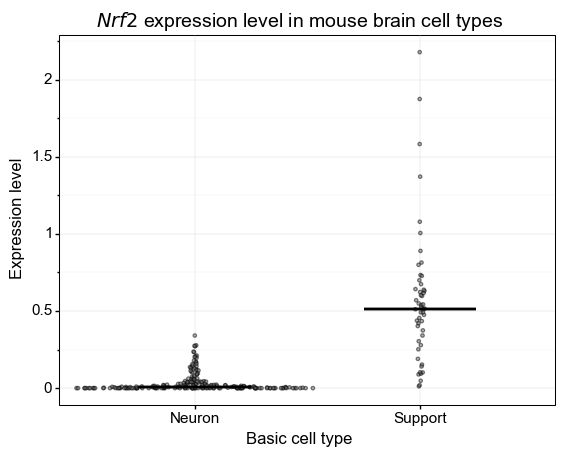

<ggplot: (8754954886870)>

In [37]:
# make plot
Figure_1A = (
    p9.ggplot(data = plotting_df.loc[plotting_df['gene'] == "Nfe2l2",], \
        mapping = p9.aes(x="Basic class", y="expression")) + 
    p9.geom_sina(mapping = p9.aes(group = "Basic class"), maxwidth = 1.1, size = 0.9,
        method = "density", scale = "area", color = "black", fill = "dimgray", alpha = 0.5) + 
    p9.scales.scale_color_manual(values = ({'Neurons' : "royalblue", 'PeripheralGlia' : "olivedrab", 
       'Vascular' : "red", 'Oligos' : "slategrey", 'Astrocytes' : "forestgreen",
       'Ependymal' : "orange", 'Immune' : "blueviolet"})) +
    p9.labs(x = "Basic cell type", y = "Expression level", 
        title = "$Nrf2$ expression level in mouse brain cell types") +
    p9.geom_errorbar(data = summ_df.loc[summ_df['gene'] == "Nfe2l2",], \
        inherit_aes = False, size = 1, mapping = p9.aes(x="Basic class", ymin="expression_median", ymax="expression_median"))
    )

# output
Figure_1A

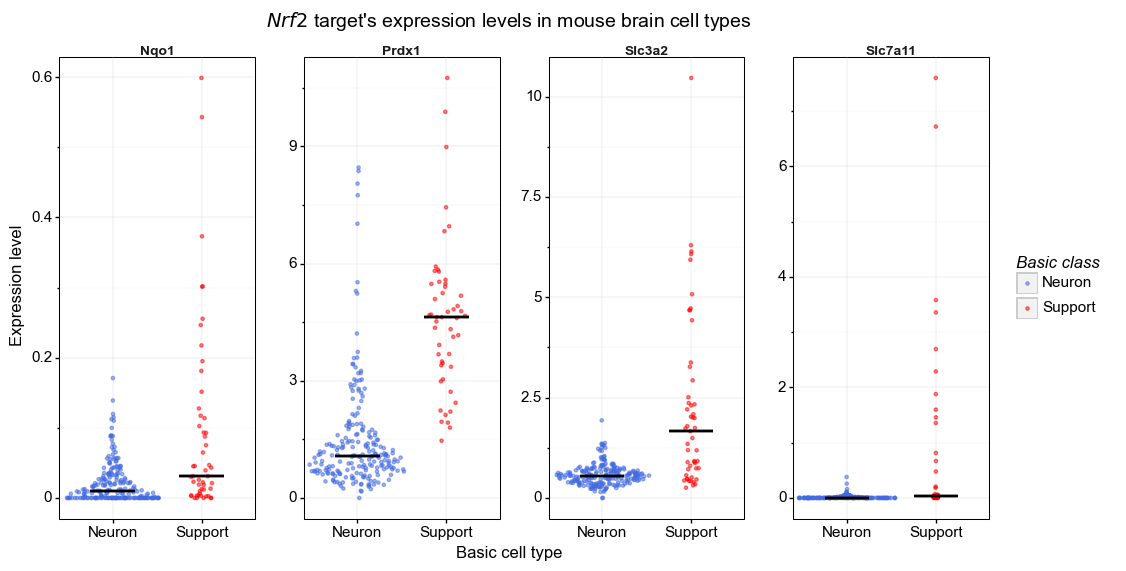

<ggplot: (8754954752260)>

In [38]:
# make target plots
Figure_4 = (
    p9.ggplot(data = plotting_df.loc[plotting_df['gene'] != "Nfe2l2",], \
        mapping = p9.aes(x="Basic class", y="expression", color = "Basic class")) + 
    p9.geom_sina(mapping = p9.aes(group = "Basic class"), maxwidth = 1.1, size = 0.9,
        method = "density", scale = "area", alpha = 0.5) + 
    p9.scales.scale_color_manual(values = ({'Neuron' : "royalblue", 'Support' : "red"})) +
    p9.labs(x = "Basic cell type", y = "Expression level", 
        title = "$Nrf2$ target's expression levels in mouse brain cell types") +
    p9.geom_errorbar(data = summ_df.loc[summ_df['gene'] != "Nfe2l2",], \
        inherit_aes = False, size = 1, mapping = p9.aes(x="Basic class", ymin="expression_median", ymax="expression_median")) +
    p9.facet_wrap(facets = "gene", nrow = 1, scales = 'free_y', shrink = False) +
    p9.theme(figure_size=(12,6))
    )

# output
Figure_4

In [39]:
# Close the mba object
mba.close()

<br>

## Mouse developing brain scRNA-seq

Now plot the [mouse development](http://mousebrain.org/development/downloads.html) data from the Linnarsson lab.  First import the data.  

In [40]:
# Import data
mba = loompy.connect("dev_all.agg.loom")

# Check dataset
mba[0:6, 0:6]

array([[9.09090909e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.81818182e+00, 3.46153846e-01, 4.56621005e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.81818182e-01, 7.69230769e-02, 6.84931507e-03, 0.00000000e+00,
        1.28205128e-02, 3.17460317e-02],
       [7.09090909e+00, 4.61538462e-01, 2.21461187e-01, 4.69387755e-01,
        0.00000000e+00, 0.00000000e+00],
       [7.27272727e-01, 3.84615385e-02, 4.56621005e-03, 3.67346939e-01,
        3.84615385e-02, 3.17460317e-02],
       [1.07272727e+01, 2.69230769e-01, 9.13242009e-03, 3.06122449e-01,
        1.28205128e-02, 1.58730159e-02]])

Check and get the appropriate columns (cell/phenotype data).  

In [41]:
# Check what data is available
mba.ra.keys()
mba.ca.keys()

['Accession',
 'Chromosome',
 'End',
 'Gamma',
 'Gene',
 'HPF',
 'HPF_beta',
 'MultilevelMarkers',
 'Selected',
 'Start',
 'Strand',
 'Valid']

['Age_e10_0',
 'Age_e11_0',
 'Age_e12_0',
 'Age_e12_5',
 'Age_e13_0',
 'Age_e13_5',
 'Age_e14_0',
 'Age_e14_5',
 'Age_e15_0',
 'Age_e15_5',
 'Age_e16_0',
 'Age_e16_25',
 'Age_e16_5',
 'Age_e17_0',
 'Age_e17_5',
 'Age_e18_0',
 'Age_e7_0',
 'Age_e8_0',
 'Age_e8_5',
 'Age_e9_0',
 'AutoAnnotation',
 'Class',
 'ClusterName',
 'Clusters',
 'Location_E9_E11',
 'MarkerGenes',
 'MarkerRobustness',
 'MarkerSelectivity',
 'MarkerSpecificity',
 'NCells',
 'Outliers',
 'SampleID_10X08_1',
 'SampleID_10X10_2',
 'SampleID_10X10_3',
 'SampleID_10X12_2',
 'SampleID_10X12_3',
 'SampleID_10X12_4',
 'SampleID_10X13_4',
 'SampleID_10X13_5',
 'SampleID_10X14_2',
 'SampleID_10X14_3',
 'SampleID_10X14_4',
 'SampleID_10X15_2',
 'SampleID_10X15_3',
 'SampleID_10X15_4',
 'SampleID_10X15_5',
 'SampleID_10X16_2',
 'SampleID_10X16_3',
 'SampleID_10X16_4',
 'SampleID_10X16_5',
 'SampleID_10X17_2',
 'SampleID_10X17_3',
 'SampleID_10X17_4',
 'SampleID_10X17_5',
 'SampleID_10X18_2',
 'SampleID_10X18_3',
 'SampleID_10X1

In [42]:
# Get the basic celltype (neuron, astrocyte, etc)
agg_Class = mba.ca.Class.astype('U')

# Fix one value that was incorrect (found later in script)
# was 'misannotated' as undefined
agg_Class[378] = "Neuron"

# Get the clusters
agg_Clusters = mba.ca.Clusters
agg_ClusterName = mba.ca.ClusterName.astype('U')
agg_Subclass = mba.ca.Subclass.astype('U')

# Get number of cells per cluster
agg_NCells = mba.ca.NCells

In [43]:
# Fix the ClusterNames to remove NaNs and put _ at beginning for renaming columns later
nan_str = np.array([np.nan]).astype(str)[0]
fixed_ClusterName = []
for x in agg_ClusterName:
    if x == nan_str:
        fixed_ClusterName.append(str(''))
    else:
        fixed_ClusterName.append(str("_" + x))
del(x, nan_str)

In [44]:
# List all column keys that correspond to age
column_idx = []
idx = 0
regex_age = re.compile("Age_.*")
for i in mba.ca.keys():
    if regex_age.match(i):
        column_idx.append(idx)
    idx += 1
del(idx, i)
mba_colnames = mba.ca.keys()
[mba_colnames[i] for i in column_idx]

['Age_e10_0',
 'Age_e11_0',
 'Age_e12_0',
 'Age_e12_5',
 'Age_e13_0',
 'Age_e13_5',
 'Age_e14_0',
 'Age_e14_5',
 'Age_e15_0',
 'Age_e15_5',
 'Age_e16_0',
 'Age_e16_25',
 'Age_e16_5',
 'Age_e17_0',
 'Age_e17_5',
 'Age_e18_0',
 'Age_e7_0',
 'Age_e8_0',
 'Age_e8_5',
 'Age_e9_0']

Now aggregate and calculate the mean/median embryo stage for each cell cluster/type (as well as making three developmental 'ages' for mature neurons).

In [45]:
# aggregate these into a dataframe - it shows the number of cells from each stage for each cell type
embryo_stage_df = pd.DataFrame({'7.0' : np.array(mba.ca.Age_e7_0), '8.0' : np.array(mba.ca.Age_e8_0), '8.5' : np.array(mba.ca.Age_e8_5),
    '9.0' : np.array(mba.ca.Age_e9_0), '10.0' : np.array(mba.ca.Age_e10_0), '11.0' : np.array(mba.ca.Age_e11_0), '12.0' : np.array(mba.ca.Age_e12_0),
    '12.5' : np.array(mba.ca.Age_e12_5), '13.0' : np.array(mba.ca.Age_e13_0), '13.5' : np.array(mba.ca.Age_e13_5), '14.0' : np.array(mba.ca.Age_e14_0),
    '14.5' : np.array(mba.ca.Age_e14_5), '15.0' : np.array(mba.ca.Age_e15_0), '15.5' : np.array(mba.ca.Age_e15_5), '16.0' : np.array(mba.ca.Age_e16_0),
    '16.25' : np.array(mba.ca.Age_e16_25), '16.5' : np.array(mba.ca.Age_e16_5), '17.0' : np.array(mba.ca.Age_e17_0), '17.5' : np.array(mba.ca.Age_e17_5),
    '18.0' : np.array(mba.ca.Age_e18_0)})

# Now get total cells per cluster/celltype (row sum) and compare to NCells
truth_check = []
check_cell_no = pd.DataFrame({'embryo_stage' : np.array(embryo_stage_df.sum(axis=1)), 'NCells' : np.array(agg_NCells)})
for idx, row in check_cell_no.iterrows():
    truth_check.append(row['embryo_stage'] == row['NCells'])
all(truth_check)
del(truth_check, idx, row, check_cell_no)

True

In [46]:
# Now 'expand' each row of cells so that the number of cells at each embryo stage is a separate 'count'
# and calculate the median and average embryo stage for each cell type
embryo_stage_med = []
embryo_stage_mean = []
total_10_to_13 = []
total_13_5_to_16 = []
total_16_25_to_18 = []
for idx, row in embryo_stage_df.iterrows():
    tmp = []
    # row = embryo_stage_df.iloc[542,:]
    for i in range(0,len(row)):
        tmp.extend([float(embryo_stage_df.columns[i])] * int(row[i]))
    total_10_to_13.append(row['10.0'] + row['11.0'] + row['12.0'] + row['12.5'] + row['13.0'])
    total_13_5_to_16.append(row['13.5'] + row['14.0'] + row['14.5'] + row['15.0'] + row['15.5'] + row['16.0'])
    total_16_25_to_18.append(row['16.25'] + row['16.5'] + row['17.0'] + row['17.5'] + row['18.0'])
    embryo_stage_med.append(statistics.median(tmp))
    embryo_stage_mean.append(statistics.mean(tmp))
del(idx, row, tmp, i)

# Make unique column name by combining the values above
unique_colnames = []
for i in range(0,len(agg_Clusters)):
    unique_colnames.append("c" + str(agg_Clusters[i]).zfill(3) + "_" + agg_Class[i] + fixed_ClusterName[i])
del(i)

Also get row data (gene names, etc), and the actual cell cluster-aggregated expression values.

In [47]:
# Now 'download' row attributes- gene names, etc
agg_row_ENSMUSG = mba.ra.Accession.astype('U')
agg_row_GeneName = mba.ra.Gene.astype('U')
agg_row_MultilevelMarkers = np.array(list(itertools.chain(*mba.ra.MultilevelMarkers)))
agg_row_Selected = mba.ra.Selected
agg_row_Valid = mba.ra.Valid

In [48]:
# Now, convert the dataset array and these data into dataframes
expr_orig = pd.DataFrame(mba[:,:], index = agg_row_ENSMUSG, columns = unique_colnames)

# Check it
expr_orig.shape
expr_orig.iloc[0:6, 0:6]
all_genes_num = expr_orig.shape[0]

# Check library size distribution
np.quantile((np.array(expr_orig.sum(axis = 0))), q = [0.01, 0.25,0.5,0.75,.99])

(31053, 798)

,c000_Gastrulation_ParEndo,c001_Gastrulation,c002_Gastrulation_TrophEct,c003_Gastrulation_FGut4,c004_Gastrulation_FGut1,c005_Gastrulation_FGut3
ENSMUSG00000038751,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000030762,1.818182,0.346154,0.004566,0.000000,0.000000,0.000000
ENSMUSG00000035121,0.181818,0.076923,0.006849,0.000000,0.012821,0.031746
ENSMUSG00000026478,7.090909,0.461538,0.221461,0.469388,0.000000,0.000000
ENSMUSG00000057092,0.727273,0.038462,0.004566,0.367347,0.038462,0.031746
ENSMUSG00000032796,10.727273,0.269231,0.009132,0.306122,0.012821,0.015873


array([ 2858.71123513,  4765.99485196,  5786.57103885,  7954.11835373,
       20405.84015843])

In [49]:
# Now calculate the total mean UMI across all genes in each cell type and
# library size-normalize with those numbers
expr_df = (expr_orig / (expr_orig.sum(axis = 0)))*10000 # multiply by 10000 to scale up a bit

# Check
expr_df.iloc[0:1,] 

,c000_Gastrulation_ParEndo,c001_Gastrulation,c002_Gastrulation_TrophEct,c003_Gastrulation_FGut4,c004_Gastrulation_FGut1,c005_Gastrulation_FGut3,c006_Gastrulation_FGut2,c007_Gastrulation_VEnd1,c008_Gastrulation_VEnd3,c009_Gastrulation_VEnd2,...,c788_Neuron_Neur788,c789_Neuron_Neur789,c790_Neuron_Neur790,c791_Neuron_Neur791,c792_Neuron_Neur792,c793_Neuron_Neur793,c794_Neuron_Neur794,c795_Neuron_Neur795,c796_Neuron_Neur796,c797_Neuron_Neur797
ENSMUSG00000038751,0.133269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Combine phenotype and expression data into a plotting dataframe and annotate cells as categories of developmental neural, or other.  

In [50]:
# Now put together relevent column data into dataframe of sample characteristics
col_df = pd.DataFrame({'Cluster' : agg_Clusters, 'ClusterName' : unique_colnames, 'Class' : agg_Class, 'Subclass' : agg_Subclass,
    'Number_of_cells' : agg_NCells, 'median_embryo_stage' : embryo_stage_med, 'mean_embryo_stage' : embryo_stage_mean,
    'e10_to_13' : total_10_to_13, 'e13.5_to_16' : total_13_5_to_16, 'e16.25_to_18' : total_16_25_to_18}).join(embryo_stage_df)

# Convert the 3 categorical columns of neuron stages (e10 - 13, e13.5 - 15.5, e16 - 18) to proportion/fraction
col_df['e10_to_13'] = col_df['e10_to_13']/col_df['Number_of_cells'] 
col_df['e13.5_to_16'] = col_df['e13.5_to_16']/col_df['Number_of_cells'] 
col_df['e16.25_to_18'] = col_df['e16.25_to_18']/col_df['Number_of_cells'] 

# Now loop over rows and assign each cell type as 'early', 'mid', 'late', NULL based on the fraction in those three categories
cell_stage_category = []
for idx, row in col_df.iterrows():
    if (row['e10_to_13'] > 0.5):
        cell_stage_category.append('early')
    elif (row['e13.5_to_16'] > 0.5):
        cell_stage_category.append('mid')
    elif (row['e16.25_to_18'] > 0.5):
        cell_stage_category.append('late')
    else:
        cell_stage_category.append('')
# Make this into a categorical value/df and join to the col_df
cell_stage_category = pd.Categorical(cell_stage_category, categories = 
    ['early', 'mid', 'late', ''])
col_df['stage_category'] = cell_stage_category
del(idx, row)

In [51]:
# Check how many in each category (for Neurons specifically)
col_df.loc[col_df['Class'] == "Neuron",'stage_category'].value_counts()

late     112
early     90
mid       79
          26
Name: stage_category, dtype: int64

In [52]:
# Find all classes that are 'neur' in them
neuron_idx = []
idx = 0
regex_neuron = re.compile(".*[Nn]eur(on|al).*")
for i in agg_Class:
    if regex_neuron.match(i):
        neuron_idx.append(idx)
    idx += 1

# Find all subclasses that contain 'neur' in them
neuron_idx_2 = []
idx = 0
for i in agg_Subclass:
    if regex_neuron.match(i):
        neuron_idx_2.append(idx)
    idx += 1
del(idx, i)

# Combine the 2 and get unique row indices
neuron_idx = np.sort(np.unique(np.array(list(itertools.chain(*[neuron_idx, neuron_idx_2])))))

In [53]:
# Make pandas dataframe of all row attributes
row_df = pd.DataFrame({"ENSMUSG" : agg_row_ENSMUSG, "Gene_symbol" : agg_row_GeneName, 
    "MultilevelMarkers" : agg_row_MultilevelMarkers, "Selected" : agg_row_Selected,
    "Valid" : agg_row_Valid})

# Get index of Nrf2
Nrf2_idx = int(np.transpose(np.where(agg_row_GeneName == "Nfe2l2")))

# Get index of Keap1
Keap1_idx = int(np.transpose(np.where(agg_row_GeneName == "Keap1")))

# put together
genes_idx = [Nrf2_idx, Keap1_idx]

In [54]:
# Check
row_df.iloc[Nrf2_idx, :]
expr_df.iloc[Nrf2_idx, 0:6]

ENSMUSG              ENSMUSG00000015839
Gene_symbol                      Nfe2l2
MultilevelMarkers                   0.0
Selected                              0
Valid                                 1
Name: 1619, dtype: object

c000_Gastrulation_ParEndo     0.266539
c001_Gastrulation             0.698113
c002_Gastrulation_TrophEct    0.633547
c003_Gastrulation_FGut4       0.822983
c004_Gastrulation_FGut1       0.501292
c005_Gastrulation_FGut3       0.780721
Name: ENSMUSG00000015839, dtype: float64

In [55]:
# Now, get the expression of Nrf2 and Keap1 in each cell type and put in plotting df with 
# the column attributes
plotting_df_3 = col_df.copy()
plotting_df_3 = plotting_df_3.merge(right = pd.concat([pd.DataFrame(\
    {'ClusterName' : expr_df.columns}), pd.DataFrame(expr_df.iloc[genes_idx\
    ].transpose().reset_index(drop = True), copy = True).set_axis(labels = \
    [str(x) for x in agg_row_GeneName[genes_idx]], axis = 1)], \
    axis = 1, ignore_index=False), left_on = "ClusterName", right_on = "ClusterName") 

In [56]:
# Check all the possible basic cell-type classes
pd.unique(plotting_df_3["Class"])

# Make a new column, and define things as Neuron or Non-neuron
basic_class=[]
for i in plotting_df_3["Class"]:
    if(i == "Neuron"):
        basic_class.append("Neuron")
    elif(i == "Neural tube"):
        basic_class.append("Neural tube")
    elif(i == "Neural crest"):
        basic_class.append("Neural crest")
    elif(i == "Neuroblast"):
        basic_class.append("Neuroblast")
    else:
        basic_class.append("Other")
plotting_df_3["Basic class"] = basic_class

array(['Gastrulation', 'Radial glia', 'Mesenchyme', 'Neural tube',
       'Mesoderm', 'Neural crest', 'Bad cells', 'Endoderm', 'Ectoderm',
       'Blood', 'Fibroblast', 'Vascular', 'Immune', 'Glioblast',
       'Choroid plexus', 'Ependymal', 'Pineal gland',
       'Subcommissural organ', 'Olfactory ensheathing cell',
       'Schwann cell', 'Oligodendrocyte', 'Neuroblast', 'Neuron'],
      dtype=object)

In [57]:
# Check sample
plotting_df_3.iloc[:, [0,1,2,3,33,4,5,6,7,31,32]].head()

,Cluster,ClusterName,Class,Subclass,Basic class,Number_of_cells,median_embryo_stage,mean_embryo_stage,e10_to_13,Nfe2l2,Keap1
0,0,c000_Gastrulation_ParEndo,Gastrulation,Parietal endoderm,Other,11,7.0,7.090909,0.0,0.266539,0.666347
1,1,c001_Gastrulation,Gastrulation,Undefined,Other,26,7.0,7.153846,0.0,0.698113,0.432165
2,2,c002_Gastrulation_TrophEct,Gastrulation,Extraembryonic ectoderm,Other,438,7.0,7.000000,0.0,0.633547,0.378997
3,3,c003_Gastrulation_FGut4,Gastrulation,Endoderm,Other,49,8.0,7.979592,0.0,0.822983,0.325764
4,4,c004_Gastrulation_FGut1,Gastrulation,Endoderm,Other,78,8.0,7.717949,0.0,0.501292,0.355082


In [58]:
# Make summary dataframe also
summ_df_3 = plotting_df_3.drop(plotting_df_3.columns[0:31], axis = 1).groupby(['Basic class'], axis = 0).agg(['mean','median'])

# Collapse 'MultiIndex' returned by summarizing to flattened col index
summ_df_3.columns = ['_'.join(col) for col in summ_df_3.columns.values]
summ_df_3.reset_index(inplace = True)

# Check
summ_df_3

,Basic class,Nfe2l2_mean,Nfe2l2_median,Keap1_mean,Keap1_median
0,Neural crest,0.248477,0.240912,0.228335,0.225506
1,Neural tube,0.191967,0.185155,0.270792,0.251429
2,Neuroblast,0.163971,0.135316,0.383470,0.381731
3,Neuron,0.033143,0.020530,0.547582,0.545976
4,Other,0.486744,0.332205,0.408313,0.413152


<br>

Do Mann-Whitney U test to compare the neuron subgroups and support cells

In [59]:
# Get values for Neuron and Support - Nrf2
devdata_neurons = plotting_df_3.loc[plotting_df_3['Basic class'] == "Neuron", 'Nfe2l2'].tolist()
devdata_dev_neuro = plotting_df_3.loc[plotting_df_3['Basic class'].isin(["Neuroblast", "Neural tube", "Neural crest"]), 'Nfe2l2'].tolist()
devdata_support = plotting_df_3.loc[plotting_df_3['Basic class'] == "Other", 'Nfe2l2'].tolist()

# Do tests for Nfe2l2
# Neurons vs developing neural populations
print(f"Nfe2l2\nNeurons vs dev neurons: p-value = { mannwhitneyu(devdata_neurons, devdata_dev_neuro)[1] },\n" \
      + f"Bonferroni padj = { mannwhitneyu(devdata_neurons, devdata_dev_neuro)[1] * all_genes_num }")

# Neurons vs Support/Other
print(f"\nSupport vs Neurons: p-value = { mannwhitneyu(devdata_neurons, devdata_support)[1] },\n" \
      + f"Bonferroni padj = { mannwhitneyu(devdata_neurons, devdata_support)[1] * all_genes_num }")

# Support/Other vs developing neural populations
print(f"\nDev neurons vs Support: p-value = { mannwhitneyu(devdata_support, devdata_dev_neuro)[1] },\n" \
      + f"Bonferroni padj = { mannwhitneyu(devdata_support, devdata_dev_neuro)[1] * all_genes_num }")

Nfe2l2
Neurons vs dev neurons: p-value = 3.91363397885419e-55,
Bonferroni padj = 1.2153007594535916e-50

Support vs Neurons: p-value = 3.676678136673215e-89,
Bonferroni padj = 1.1417188617811334e-84

Dev neurons vs Support: p-value = 9.243564646683392e-33,
Bonferroni padj = 2.8704041297345936e-28


In [60]:
# Get values for Neuron and Support - Keap1
devdata_neurons = plotting_df_3.loc[plotting_df_3['Basic class'] == "Neuron", 'Keap1'].tolist()
devdata_dev_neuro = plotting_df_3.loc[plotting_df_3['Basic class'].isin(["Neuroblast", "Neural tube", "Neural crest"]), 'Keap1'].tolist()
devdata_support = plotting_df_3.loc[plotting_df_3['Basic class'] == "Other", 'Keap1'].tolist()

# Do tests for Keap1
# Neurons vs developing neural populations
print(f"Keap1\nNeurons vs dev neurons: p-value = { mannwhitneyu(devdata_neurons, devdata_dev_neuro)[1] },\n" \
      + f"Bonferroni padj = { mannwhitneyu(devdata_neurons, devdata_dev_neuro)[1] * all_genes_num }")

# Neurons vs Support/Other
print(f"\nSupport vs Neurons: p-value = { mannwhitneyu(devdata_neurons, devdata_support)[1] },\n" \
      + f"Bonferroni padj = { mannwhitneyu(devdata_neurons, devdata_support)[1] * all_genes_num }")

# Support/Other vs developing neural populations
print(f"\nDev neurons vs Support: p-value = { mannwhitneyu(devdata_support, devdata_dev_neuro)[1] },\n" \
      + f"Bonferroni padj = { mannwhitneyu(devdata_support, devdata_dev_neuro)[1] * all_genes_num }")

Keap1
Neurons vs dev neurons: p-value = 2.0370847342208115e-39,
Bonferroni padj = 6.325759225175886e-35

Support vs Neurons: p-value = 1.6613237754445947e-35,
Bonferroni padj = 5.1589087198881e-31

Dev neurons vs Support: p-value = 0.004419404487436621,
Bonferroni padj = 137.23576754836938


In [61]:
# Make basic class a categorical variable
plotting_df_3['Basic class'] = pd.Categorical(plotting_df_3['Basic class'], categories = 
    ['Neuron', 'Neuroblast', 'Neural tube', 'Neural crest', 'Other'])

# Reorder rows by median expression value
plotting_df_3.sort_values(by = ['median_embryo_stage'], ascending = False, inplace = True)

# Now get counts for each neural developmental stage
plotting_df_3['Basic class'].value_counts()

Other           311
Neuron          307
Neuroblast      170
Neural tube       6
Neural crest      4
Name: Basic class, dtype: int64

Plot the developmental data as sina plots.  

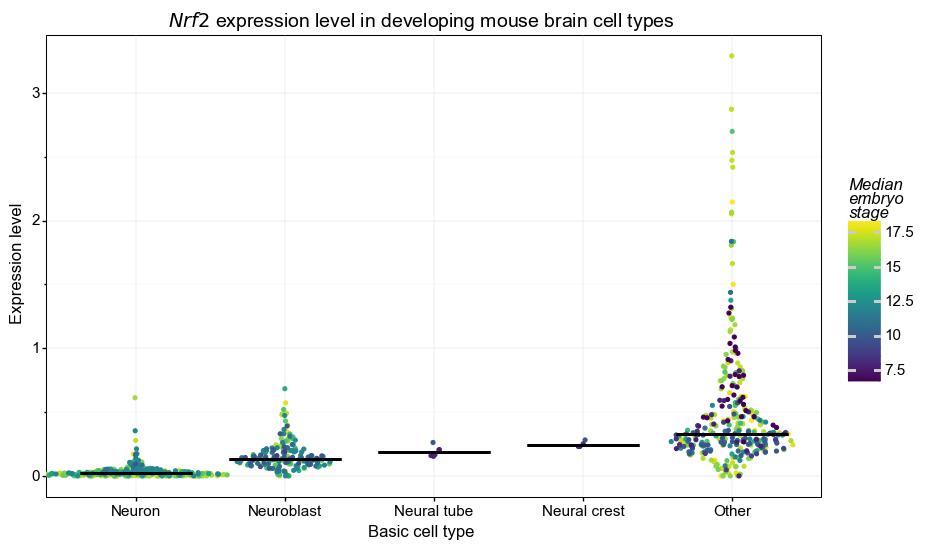

<ggplot: (8754952505619)>

In [62]:
# Plot Nrf2 expression between neurons and non-neurons
Figure_3 = (
    p9.ggplot(mapping = p9.aes(x="Basic class", y="Nfe2l2")) + 
    p9.geom_sina(data = pd.DataFrame(plotting_df_3.loc[plotting_df_3['Basic class'] == "Neuron", :], 
    copy = True).reset_index(drop = True), mapping = p9.aes(color = "median_embryo_stage"), 
        maxwidth = 1.3, size = 1.1, method = "density", scale = "width") +
    p9.geom_sina(data = pd.DataFrame(plotting_df_3.loc[plotting_df_3['Basic class'] == "Neuroblast", :], 
    copy = True).reset_index(drop = True), mapping = p9.aes(color = "median_embryo_stage"), 
        maxwidth = 0.65, size = 1.1, method = "density", scale = "width") +
    p9.geom_sina(data = pd.DataFrame(plotting_df_3.loc[plotting_df_3['Basic class'] == "Neural crest", :], 
    copy = True).reset_index(drop = True), mapping = p9.aes(color = "median_embryo_stage"), 
        maxwidth = 0.1, size = 1.1, method = "density", scale = "width") +
    p9.geom_sina(data = pd.DataFrame(plotting_df_3.loc[plotting_df_3['Basic class'] == "Neural tube", :], 
    copy = True).reset_index(drop = True), mapping = p9.aes(color = "median_embryo_stage"), 
        maxwidth = 0.1, size = 1.1, method = "density", scale = "width") +
    p9.geom_sina(data = pd.DataFrame(plotting_df_3.loc[plotting_df_3['Basic class'] == "Other", :], 
    copy = True).reset_index(drop = True), mapping = p9.aes(color = "median_embryo_stage"), 
        maxwidth = 0.85, size = 1.1, method = "density", scale = "width") +
    p9.labs(x = "Basic cell type", y = "Expression level", color = "Median\nembryo\nstage\n\n", 
        title = "$Nrf2$ expression level in developing mouse brain cell types") +
    p9.geom_errorbar(data = summ_df_3, inherit_aes = False, size = 1.2, width = 0.75,
        mapping = p9.aes(x="Basic class", ymin="Nfe2l2_median", ymax="Nfe2l2_median")) +
    p9.theme(strip_background = p9.element_blank(), strip_text = p9.element_blank(), 
        legend_position = "right", figure_size=(10,6))
    )

Figure_3

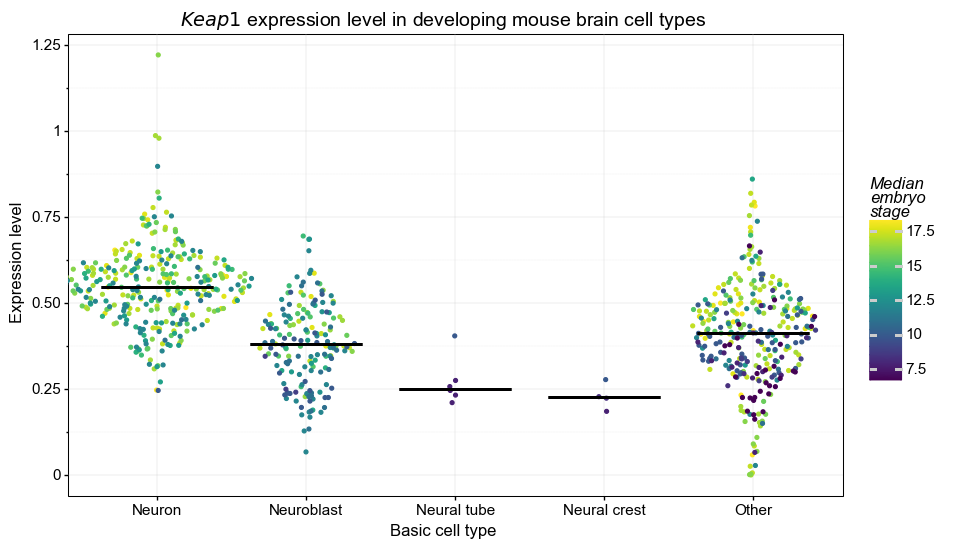

<ggplot: (8754955044566)>

In [63]:
# Plot Keap1 expression between neurons and non-neurons
Figure_S6 = (
    p9.ggplot(mapping = p9.aes(x="Basic class", y="Keap1")) + 
    p9.geom_sina(data = pd.DataFrame(plotting_df_3.loc[plotting_df_3['Basic class'] == "Neuron", :], 
    copy = True).reset_index(drop = True), mapping = p9.aes(color = "median_embryo_stage"), 
        maxwidth = 1.3, size = 1.1, method = "density", scale = "width") +
    p9.geom_sina(data = pd.DataFrame(plotting_df_3.loc[plotting_df_3['Basic class'] == "Neuroblast", :], 
    copy = True).reset_index(drop = True), mapping = p9.aes(color = "median_embryo_stage"), 
        maxwidth = 0.65, size = 1.1, method = "density", scale = "width") +
    p9.geom_sina(data = pd.DataFrame(plotting_df_3.loc[plotting_df_3['Basic class'] == "Neural crest", :], 
    copy = True).reset_index(drop = True), mapping = p9.aes(color = "median_embryo_stage"), 
        maxwidth = 0.1, size = 1.1, method = "density", scale = "width") +
    p9.geom_sina(data = pd.DataFrame(plotting_df_3.loc[plotting_df_3['Basic class'] == "Neural tube", :], 
    copy = True).reset_index(drop = True), mapping = p9.aes(color = "median_embryo_stage"), 
        maxwidth = 0.1, size = 1.1, method = "density", scale = "width") +
    p9.geom_sina(data = pd.DataFrame(plotting_df_3.loc[plotting_df_3['Basic class'] == "Other", :], 
    copy = True).reset_index(drop = True), mapping = p9.aes(color = "median_embryo_stage"), 
        maxwidth = 0.85, size = 1.1, method = "density", scale = "width") +
    p9.labs(x = "Basic cell type", y = "Expression level", color = "Median\nembryo\nstage\n\n", 
        title = "$Keap1$ expression level in developing mouse brain cell types") +
    p9.geom_errorbar(data = summ_df_3, inherit_aes = False, size = 1.2, width = 0.75,
        mapping = p9.aes(x="Basic class", ymin="Keap1_median", ymax="Keap1_median")) +
    p9.theme(strip_background = p9.element_blank(), strip_text = p9.element_blank(), 
        legend_position = "right", figure_size=(10,6))
    )

Figure_S6

In [64]:
# Also plot Nrf2 expression between neurons and non-neurons on log scale
# First have to convert 0's to non-zero values for log scale
log_plotting_df = plotting_df_3.copy()
for idx, row in log_plotting_df.iterrows():
    if row['Nfe2l2'] == 0:
        log_plotting_df.loc[idx, 'Nfe2l2'] = 0.0001

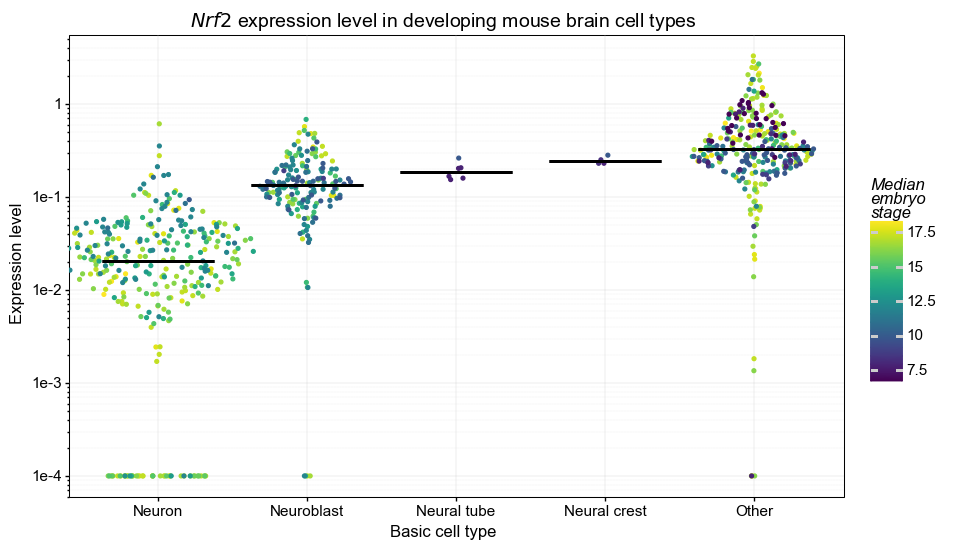

<ggplot: (8754955095562)>

In [65]:
# Now plot
Figure_S3 = (
    p9.ggplot(mapping = p9.aes(x="Basic class", y="Nfe2l2")) + 
    p9.geom_sina(data = pd.DataFrame(log_plotting_df.loc[log_plotting_df['Basic class'] == \
        "Neuron", :], copy = True).reset_index(drop = True), \
        mapping = p9.aes(color = "median_embryo_stage"), \
        maxwidth = 1.3, size = 1.1, method = "density", scale = "width") +
    p9.geom_sina(data = pd.DataFrame(log_plotting_df.loc[log_plotting_df['Basic class'] == \
        "Neuroblast", :], copy = True).reset_index(drop = True), \
        mapping = p9.aes(color = "median_embryo_stage"), \
        maxwidth = 0.65, size = 1.1, method = "density", scale = "width") +
    p9.geom_sina(data = pd.DataFrame(log_plotting_df.loc[log_plotting_df['Basic class'] == \
        "Neural crest", :], copy = True).reset_index(drop = True), \
        mapping = p9.aes(color = "median_embryo_stage"), \
        maxwidth = 0.1, size = 1.1, method = "density", scale = "width") +
    p9.geom_sina(data = pd.DataFrame(log_plotting_df.loc[log_plotting_df['Basic class'] == \
        "Neural tube", :], copy = True).reset_index(drop = True), \
        mapping = p9.aes(color = "median_embryo_stage"), \
        maxwidth = 0.1, size = 1.1, method = "density", scale = "width") +
    p9.geom_sina(data = pd.DataFrame(log_plotting_df.loc[log_plotting_df['Basic class'] == \
        "Other", :], copy = True).reset_index(drop = True), \
        mapping = p9.aes(color = "median_embryo_stage"), \
        maxwidth = 0.85, size = 1.1, method = "density", scale = "width") +
    p9.labs(x = "Basic cell type", y = "Expression level", \
        color = "Median\nembryo\nstage\n\n", \
        title = "$Nrf2$ expression level in developing mouse brain cell types") +
    p9.geom_errorbar(data = summ_df_3, inherit_aes = False, size = 1.2, width = 0.75, \
        mapping = p9.aes(x="Basic class", ymin="Nfe2l2_median", ymax="Nfe2l2_median")) +
    p9.scale_y_log10() + 
    p9.theme(strip_background = p9.element_blank(), strip_text = p9.element_blank(), 
        legend_position = "right", figure_size=(10,6))
    )

Figure_S3

In [66]:
# Close connector/object
mba.close()

In [67]:
# Delete unused objects
del(Keap1_idx, Nrf2_idx, agg_Class, agg_ClusterName, agg_Clusters, agg_Description, agg_NCells, agg_OriginalClusters, agg_Region, agg_Subclass, agg_row_ENSMUSG, agg_row_GeneName, agg_row_LogCV, agg_row_LogMean, agg_row_MultilevelMarkers, agg_row_Selected, agg_row_Total, agg_row_Valid, basic_class, cell_stage_category, col_df, column_idx, devdata_dev_neuro, devdata_neurons, devdata_support, embryo_stage_df, embryo_stage_mean, embryo_stage_med, expr_df, expr_orig, fixed_ClusterName, genes_idx, genes_of_interest, i, mba, mba_colnames, neuron_idx, neuron_idx_2, plotting_df, plotting_df_3, log_plotting_df, plotting_df_orig, regex_age, regex_neuron, row_df, summ_df, summ_df_3, total_10_to_13, total_13_5_to_16, total_16_25_to_18)

<br>

## Human brain singl cell RNA-seq  

Now plot the [human cellbrowser data](https://cells.ucsc.edu/?ds=dev-brain-regions+wholebrain) in a similar format.  Note, these aggregated datasets were generated by downloading the data from human cell browser and then using the following R commands/code (version 4.1.0):

```R version 4.1.0
# Load packages
library("doParallel")
library("BiocParallel")
library("Matrix")
library("Seurat")
library("tidyverse")
library("magrittr")
library("data.table")
library("SingleCellExperiment")

# Get the data
download.file("https://cells.ucsc.edu/dev-brain-regions/wholebrain/exprMatrix.tsv.gz", 
    "exprMatrix.tsv.gz")
download.file("https://cells.ucsc.edu/dev-brain-regions/wholebrain/meta.tsv", 
    "meta.tsv")

# import expression matrix
mat <- fread(input = "exprMatrix.tsv.gz", nThread = 108, data.table = F) 

# check sample of object and size
mat[1:6, 1:6]
format(object.size(mat), units = "GB") # 80 GB

# gene names of expression matrix
genes <- as.character(unlist(mat[,1]))
genes <- gsub(".+[|]", "", genes)

# Now re-make expression matrix into Sparse Matrix
dat <- as(as.matrix(mat[,-1]), "dgCMatrix") # takes 2 min
rownames(dat) <- genes
dim(dat)

# read in cell info
meta <- read.table("meta.tsv", header=T, sep="\t", as.is=T, row.names=1)

# check
head(meta)
dim(meta)

# Create Seurat object
Seurat_obj <- CreateSeuratObject(counts = dat, project = "human_cellbrowser", meta.data=meta)

# Get average counts so that comparable with the Linnarsson lab's data on mouse brain
avg_counts <- AverageExpression(object = Seurat_obj, slot = "counts", group.by = "cell_cluster")

# Add gene names back
avg_counts_df <- cbind(data.frame(gene = rownames(avg_counts[["RNA"]])), 
    as.data.frame(avg_counts[["RNA"]])) %>% set_rownames(NULL)

# Check sample and NRF2 expression across cell types
dim(avg_counts_df)
avg_counts_df[1:6, 1:6]
avg_counts_df[avg_counts_df$gene == "NFE2L2",2:181] %>% sort()

# Write out to compressed table text file
write.table(x = avg_counts_df, file = gzfile("human_cellbrowser_mean-counts-per-cluster.tsv.gz"), 
    quote = F, sep = "\t", eol = "\n", na = "", dec = ".", row.names = F, col.names = T)
```

<br>

Now I use Python to import these values and plot them similar to the mouse brain atlas data.  

In [68]:
# Import cell metadata
metadata = pd.read_table(filepath_or_buffer = "human_cellbrowser_metadata.tsv.gz", delimiter= "\t")

# Check
metadata.head()
metadata.shape
metadata.columns

,cell_name,structure,area,subarea,lamina,cell_class,cell_type,cell_cluster,age,individual,ngene,numi,percent_mito,percent_ribo,ncount_rna,nfeature_rna,color
0,GW14_CGE_AAACCTGGTAAAGGAG,ganglionic eminence,caudal,NaN,all,glia,radial glia,RG_4,14,GW14,869,1481,1.290000e-13,0.232275,1481,869,#D020D0
1,GW14_CGE_AAACCTGGTTCCGTCT,ganglionic eminence,caudal,NaN,all,dividing,dividing,Dividing_3,14,GW14,805,1845,1.220000e-37,0.270461,1845,805,#505050
2,GW14_CGE_AAACCTGTCGTCCAGG,ganglionic eminence,caudal,NaN,all,dividing,dividing,Dividing_5,14,GW14,1131,3101,5.790000e-19,0.341503,3101,1131,#505050
3,GW14_CGE_AAACGGGCAGCCAGAA,ganglionic eminence,caudal,NaN,all,neuron,neuron,Neuron_4,14,GW14,776,1451,4.320000e-34,0.216402,1451,776,#FFCC00
4,GW14_CGE_AAACGGGGTGAACCTT,ganglionic eminence,caudal,NaN,all,dividing,dividing,Dividing_5,14,GW14,1097,2780,2.550000e-46,0.267986,2780,1097,#505050


(691928, 17)

Index(['cell_name', 'structure', 'area', 'subarea', 'lamina', 'cell_class',
       'cell_type', 'cell_cluster', 'age', 'individual', 'ngene', 'numi',
       'percent_mito', 'percent_ribo', 'ncount_rna', 'nfeature_rna', 'color'],
      dtype='object')

In [69]:
# If I look at rows with unique age, structure, area and cell-type cluster, there's many
metadata[['structure', 'area', 'cell_class', 'cell_type', 'cell_cluster', 'age']].drop_duplicates().shape

# Filter/consolidate to only include a single row for each cell-type cluster
cell_clust_meta = metadata[['cell_class', 'cell_type', 'cell_cluster']].drop_duplicates()
cell_clust_meta.head()
cell_clust_meta.shape

(2225, 6)

,cell_class,cell_type,cell_cluster
0,glia,radial glia,RG_4
1,dividing,dividing,Dividing_3
2,dividing,dividing,Dividing_5
3,neuron,neuron,Neuron_4
5,neuron,neuron,Neuron_37


(180, 3)

In [70]:
# Import expression dataset using Pandas (average gene counts/expression per cluster)
human_expr_orig = pd.read_table("human_cellbrowser_mean-counts-per-cluster.tsv.gz", index_col = 0)

# Check it
human_expr_orig.shape
human_expr_orig.iloc[0:5, 0:5]
all_genes_num = human_expr_orig.shape[0]

# Check library size distribution
np.quantile((np.array(human_expr_orig.sum(axis = 0))), q = [0.01, 0.25,0.5,0.75,.99])

(30741, 180)

,Astrocyte_1,Astrocyte_2,Astrocyte_3,Astrocyte_4,Astrocyte_5
gene,,,,,
RP11-34P13.7,0.000514,0.000000,0.000000,0.001158,0.000000
FO538757.2,0.113508,0.148860,0.160500,0.122258,0.168831
AP006222.2,0.201849,0.212579,0.176688,0.106985,0.272727
RP4-669L17.10,0.006163,0.008239,0.003700,0.003836,0.012987
RP11-206L10.9,0.022599,0.031859,0.012951,0.016214,0.006494


array([ 1750.07890112,  2710.40134059,  3664.6824137 ,  5568.31337749,
       26725.02873957])

In [71]:
# Now calculate the total mean UMI across all genes in each cell type and
# library size-normalize with those numbers
human_expr_df = pd.DataFrame((human_expr_orig / (human_expr_orig.sum(axis = 0)))*10000, copy = True) # multiply by 10000 to scale up a bit

# Check
human_expr_df.iloc[0:6, 0:5] 

,Astrocyte_1,Astrocyte_2,Astrocyte_3,Astrocyte_4,Astrocyte_5
gene,,,,,
RP11-34P13.7,0.001042,0.000000,0.000000,0.004321,0.000000
FO538757.2,0.230320,0.254486,0.618833,0.456095,0.626268
AP006222.2,0.409574,0.363417,0.681251,0.399117,1.011663
RP4-669L17.10,0.012506,0.014086,0.014267,0.014312,0.048174
RP11-206L10.9,0.045856,0.054466,0.049935,0.060489,0.024087
LINC00115,0.027096,0.030989,0.058852,0.029164,0.024087


In [72]:
# Check column names and colsums
human_expr_df.columns
human_expr_df.sum(axis = 0)

Index(['Astrocyte_1', 'Astrocyte_2', 'Astrocyte_3', 'Astrocyte_4',
       'Astrocyte_5', 'Astrocyte_6', 'Dividing_1', 'Dividing_10',
       'Dividing_11', 'Dividing_12',
       ...
       'RG_46', 'RG_47', 'RG_5', 'RG_50', 'RG_52', 'RG_59', 'RG_6', 'RG_7',
       'RG_8', 'RG_9'],
      dtype='object', length=180)

Astrocyte_1    10000.0
Astrocyte_2    10000.0
Astrocyte_3    10000.0
Astrocyte_4    10000.0
Astrocyte_5    10000.0
                ...   
RG_59          10000.0
RG_6           10000.0
RG_7           10000.0
RG_8           10000.0
RG_9           10000.0
Length: 180, dtype: float64

In [73]:
# Get index of NRF2 and other genes I need to plot
genes_idx = [int(np.transpose(np.where(human_expr_df.index == "NFE2L2"))), \
    int(np.transpose(np.where(human_expr_df.index == "MAPT"))), \
    int(np.transpose(np.where(human_expr_df.index == "GFAP"))), \
    int(np.transpose(np.where(human_expr_df.index == "RBFOX2"))), \
    int(np.transpose(np.where(human_expr_df.index == "AQP4"))), \
    int(np.transpose(np.where(human_expr_df.index == "SLC1A3")))]

# Check
pd.DataFrame(data = human_expr_df.iloc[genes_idx, 0:6]).transpose()

gene,NFE2L2,MAPT,GFAP,RBFOX2,AQP4,SLC1A3
Astrocyte_1,0.609671,1.230806,7.811083,0.414785,33.447486,6.601121
Astrocyte_2,1.219840,1.014655,3.032697,0.668611,7.168322,7.035914
Astrocyte_3,0.786471,0.419094,7.076454,0.344192,12.824290,9.519686
Astrocyte_4,1.251089,1.268911,6.512790,0.499571,18.718804,7.106875
Astrocyte_5,0.843053,0.554006,1.926977,0.674442,2.890466,5.491885
Astrocyte_6,0.812076,0.549978,3.918591,0.494121,2.234284,4.537316


In [74]:
# Now pull this data and put together with attributes to plot
plotting_df = pd.concat([pd.DataFrame({'cell_cluster' : human_expr_df.columns}, copy = True), \
    human_expr_df.iloc[genes_idx, :].transpose().reset_index(drop = True)], axis = 1,\
    ignore_index=False) 
plotting_df = plotting_df.merge(right = cell_clust_meta, left_on = 'cell_cluster', \
    right_on = 'cell_cluster', how = 'left')

# Check all the possible basic cell-type classes
pd.unique(plotting_df["cell_class"])
pd.unique(plotting_df["cell_type"])

# Make a new column, and define things as Neuron or Non-neuron
basic_class=[]
for i in plotting_df["cell_class"]:
    if(i == "neuron"):
        basic_class.append("Neuron")
    else:
        basic_class.append("Support")
plotting_df["Basic class"] = basic_class

array(['glia', 'dividing', 'endothelial', 'microglia', 'neuron',
       'outlier'], dtype=object)

array(['astrocyte', 'dividing', 'endothelial', 'microglia', 'neuron',
       'oligodendrocyte', 'outlier', 'radial glia', 'interneuron',
       'intermediate progenitor cell'], dtype=object)

In [75]:
# Make backup copy
plotting_df_orig = plotting_df.copy()

In [76]:
# Convert to long format with melt
plotting_df = plotting_df_orig.melt(id_vars=plotting_df_orig.columns[list(flatten([0,1,range(7,10)]))], \
    var_name = 'gene', value_name='expression')

<br>

Now, summarize the expression data by the new basic cell classes I designated.  Specifically, calculate the median and mean expression in each of these basic cell classes.  

In [77]:
summ_df = plotting_df.drop(['cell_cluster', 'cell_class', 'cell_type'], axis = 1).groupby(['Basic class', 'gene'], axis = 0, ).agg(['mean','median'])

Flatten the summarized data so I have a 'simple' data frame again (and reset index).  Then check the summarized values.  

In [78]:
summ_df.columns = ['_'.join(col) for col in summ_df.columns.values]
summ_df.reset_index(inplace = True)

In [79]:
summ_df

,Basic class,gene,NFE2L2_mean,NFE2L2_median,expression_mean,expression_median
0,Neuron,AQP4,0.159141,0.080560,0.450372,0.012730
1,Neuron,GFAP,0.159141,0.080560,0.237002,0.037787
2,Neuron,MAPT,0.159141,0.080560,4.490740,4.260176
3,Neuron,RBFOX2,0.159141,0.080560,3.508645,3.453303
4,Neuron,SLC1A3,0.159141,0.080560,0.394091,0.109392
5,Support,AQP4,0.898501,0.786557,2.696705,0.324633
6,Support,GFAP,0.898501,0.786557,1.970594,0.722603
7,Support,MAPT,0.898501,0.786557,1.003995,0.730399
8,Support,RBFOX2,0.898501,0.786557,1.066644,0.700535
9,Support,SLC1A3,0.898501,0.786557,2.849783,2.269814


Also do Mann-Whitney U test to compare Neurons and Support cells.

In [80]:
# Get values for Neuron and Support - NFE2l2
# filter on 'another gene' so that I only get one value per cell for NRF2
x = plotting_df.loc[(plotting_df['Basic class'] == "Neuron") \
    & (plotting_df['gene'] == "MAPT"), 'NFE2L2'].tolist()
y = plotting_df.loc[(plotting_df['Basic class'] == "Support") \
    & (plotting_df['gene'] == "MAPT"), 'NFE2L2'].tolist()

# Do test - NFE2L2
print(f"NFE2L2\nNeurons vs Support: p-value = { mannwhitneyu(x, y)[1] },\n" \
      + f"Bonferroni padj = { mannwhitneyu(x, y)[1] * all_genes_num }")

NFE2L2
Neurons vs Support: p-value = 2.7051958204525524e-23,
Bonferroni padj = 8.316042471653192e-19


In [81]:
for gene in plotting_df['gene'].unique():
    # Get values for Neuron and Support for gene
    x = plotting_df.loc[(plotting_df['Basic class'] == "Neuron") \
        & (plotting_df['gene'] == gene), 'expression'].tolist()
    y = plotting_df.loc[(plotting_df['Basic class'] == "Support") \
        & (plotting_df['gene'] == gene), 'expression'].tolist()

    # Do test 
    print(f"\n{ gene }\nNeurons vs Support: p-value = { mannwhitneyu(x, y)[1] },\n" \
      + f"Bonferroni padj = { mannwhitneyu(x, y)[1] * all_genes_num }")


MAPT
Neurons vs Support: p-value = 2.2835355350898518e-20,
Bonferroni padj = 7.019816588419713e-16

GFAP
Neurons vs Support: p-value = 2.7193588108956603e-13,
Bonferroni padj = 8.35958092057435e-09

RBFOX2
Neurons vs Support: p-value = 3.0269587556435885e-22,
Bonferroni padj = 9.305173910723956e-18

AQP4
Neurons vs Support: p-value = 4.480883109502158e-08,
Bonferroni padj = 0.0013774682766920586

SLC1A3
Neurons vs Support: p-value = 1.6960718171039603e-19,
Bonferroni padj = 5.213894372959285e-15


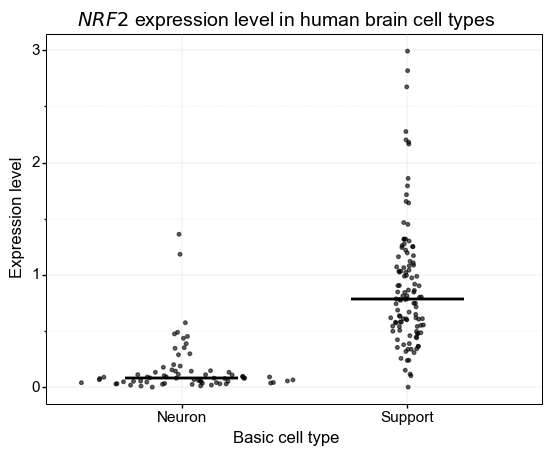

<ggplot: (8754951966690)>

In [82]:
# Plot NRF2 expression between neurons and non-neurons
# again filter on another gene than NFE2L2 to get only single values per cell
Figure_1B = (
    p9.ggplot(data = plotting_df.loc[plotting_df['gene'] == "MAPT",], \
        mapping = p9.aes(x="Basic class", y="NFE2L2")) + 
    p9.geom_sina(color = "black", maxwidth = 1, size = 1, alpha = 0.6,
        method = "density", scale = "area") + 
    p9.scales.scale_color_manual(values = ({'Neuron' : "royalblue", 'Support' : "red"})) +
    p9.labs(x = "Basic cell type", y = "Expression level", 
        title = "$NRF2$ expression level in human brain cell types") +
    p9.geom_errorbar(data = summ_df.loc[summ_df['gene'] == "MAPT",], \
        inherit_aes = False, size = 1, mapping = p9.aes(x="Basic class", \
        ymin="NFE2L2_median", ymax="NFE2L2_median"))
    )

# check the plot
Figure_1B

<br>

Next I generate plots corresponding to Figures 1B' & B", and S2A-C  

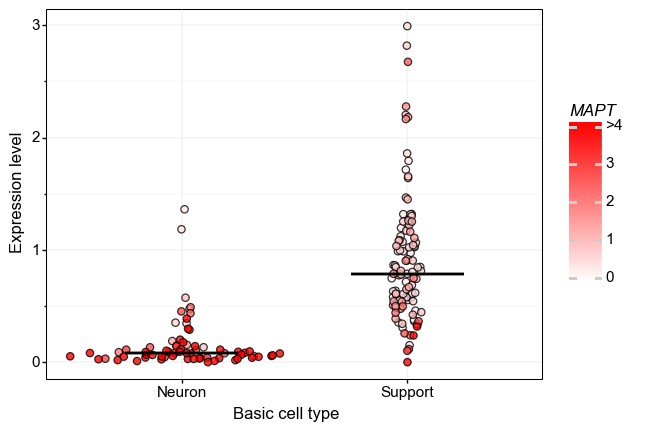

<ggplot: (8754951934717)>

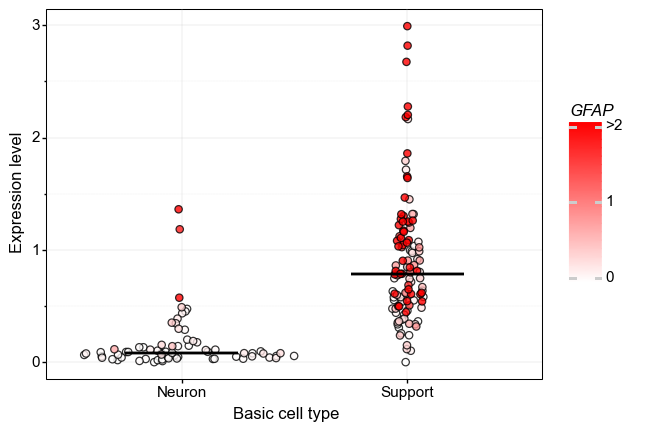

<ggplot: (8754951883394)>

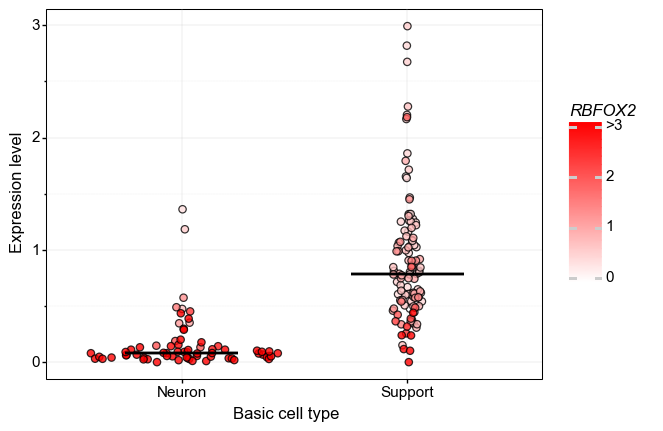

<ggplot: (8754951824381)>

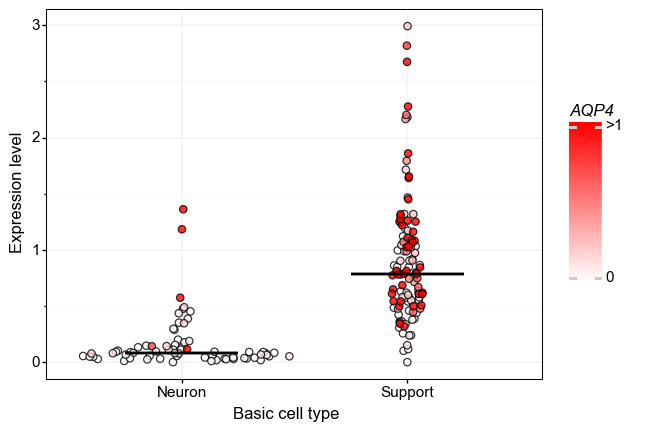

<ggplot: (8754951799399)>

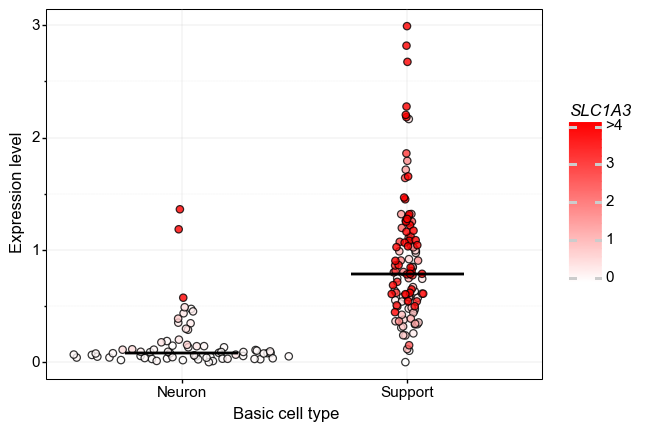

<ggplot: (8754954911359)>

In [83]:
# Now plot other genes in loop using a linear color scale
for gene in plotting_df['gene'].unique():
    # test
    # gene = "AQP4"
    
    # Get dataframe with only expression values for that specific gene
    tmp_plotting_df = pd.DataFrame(plotting_df.loc[plotting_df['gene'] == gene,], \
        copy = True).reset_index(drop = True)

    # calculate ~75th percentile (to the nearest 10 digits) and make this the max
    abs_max_expr = max(tmp_plotting_df['expression'])
    max_expr = math.floor(np.quantile(a = tmp_plotting_df['expression'], q = 0.8))
    col_steps = math.ceil(max_expr/5)
    col_breaks = np.concatenate([list(range(0, max_expr, col_steps)), [max_expr]])
    col_labels = np.concatenate([list(str(x) for x in range(0, max_expr, col_steps)), [">" + str(max_expr)]])

    # Recreate plotting_df and have the highest expression on top
    tmp_plotting_df_2 = tmp_plotting_df.sort_values(by = 'expression')
    
    # now plot
    Human_brain_genes_expr_plot = (
        p9.ggplot(data = tmp_plotting_df_2, mapping = p9.aes(x="Basic class", y="NFE2L2")) + 
        p9.geom_sina(mapping = p9.aes(fill = 'expression'), color = "black", alpha = 0.8, \
            maxwidth = 1, size = 2.5, method = "density", scale = "area") + 
        p9.scales.scale_fill_gradient(name = gene, low = "white", high = "red", \
            limits = np.array([0, max_expr]), breaks = np.array(col_breaks), labels = col_labels) +
        p9.labs(x = "Basic cell type", y = "Expression level") +
        p9.geom_errorbar(data = summ_df.loc[summ_df['gene'] == gene], \
            inherit_aes = False, size = 1, mapping = p9.aes(x="Basic class", \
            ymin="NFE2L2_median", ymax="NFE2L2_median")) +
        p9.theme(plot_title = p9.element_blank())
        )

    # check the plot
    Human_brain_genes_expr_plot


<br>

And now the PCA in Figure S2D  

In [84]:
# Now do PCA using all genes and all cell types
# First get values for PCA and the labels for each cell type
# have to transpose dataframe and use genes as columns and cells as rows
T_human_expr_df = pd.DataFrame(data = human_expr_df.transpose(), copy = True).values
PC_cells = pd.DataFrame({'cell_cluster' : human_expr_df.columns}).merge(right = cell_clust_meta,\
    left_on = "cell_cluster", right_on = "cell_cluster")
T_human_expr_df = sk.preprocessing.StandardScaler().fit_transform(T_human_expr_df)

# now do principal components analysis
pca = sk.decomposition.PCA(n_components = 2)

# extract 
principalComponents = pca.fit_transform(T_human_expr_df)
principalDf = pd.concat([pd.DataFrame(data = principalComponents, \
    columns = ['PC1', 'PC2']), PC_cells], axis = 1)

# Check variance explained
pca.explained_variance_ratio_

# Add additional column and only keep text for cell cluster names of interest
plot_cell_labels = []
for label in principalDf['cell_cluster']:
    if(any(label == x for x in ["Neuron_11", "Neuron_36", "Neuron_64"])):
        plot_cell_labels.append(label)
    else:
        plot_cell_labels.append('')
principalDf['cell labels'] = plot_cell_labels
del(plot_cell_labels, label)

array([0.07443569, 0.05854074])

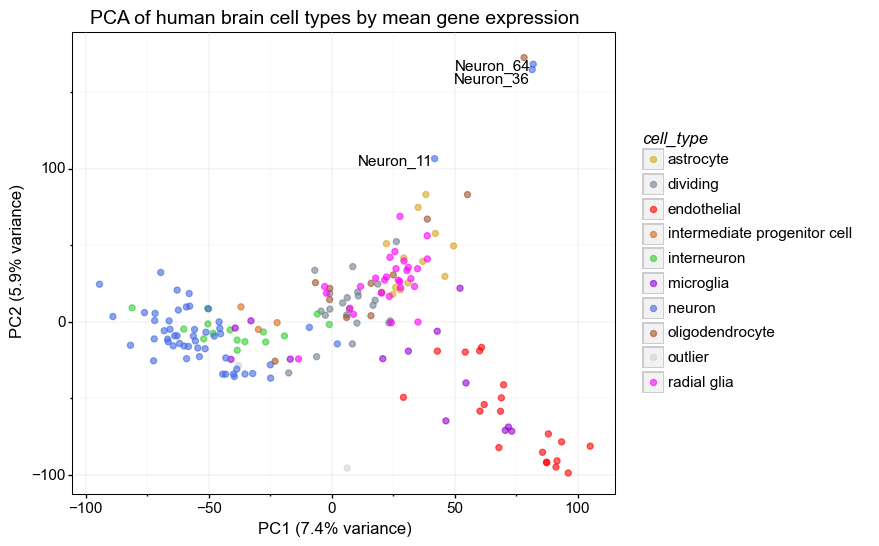

<ggplot: (8754951395853)>

In [85]:
# and plot with plotnine
PCA_cell_type = (
    p9.ggplot(data = principalDf, mapping = p9.aes(x="PC1", y="PC2", \
        color = "cell_type", fill = "cell_type")) + 
    p9.geom_point(size = 2, alpha = 0.6) + 
    p9.geom_text(data = principalDf.loc[principalDf["cell_cluster"] != "Neuron_36", :], 
        mapping = p9.aes(label = "cell labels"), size = 11, color = "black", \
            ha = "right", va = "top",
        nudge_x = -1, nudge_y = 3) +
    p9.geom_text(data = principalDf.loc[principalDf["cell_cluster"] == "Neuron_36", :], 
        mapping = p9.aes(label = "cell labels"), size = 11, color = "black", \
            ha = "right", va = "top",
        nudge_x = -1, nudge_y = -2) +
    p9.scales.scale_color_manual(aesthetics = ['fill', 'color'], values = ({'neuron' : "royalblue", \
        'interneuron' : "limegreen", 'astrocyte' : "goldenrod", 'dividing' : "slategray", \
        'endothelial' : "red", 'microglia' : "darkviolet", 'oligodendrocyte' : "sienna", \
        'outlier' : "lightgray", 'radial glia' : "fuchsia", \
        'intermediate progenitor cell' : "chocolate"})) +
    p9.labs(x = 'PC1 (7.4% variance)', y = 'PC2 (5.9% variance)', 
        title = "PCA of human brain cell types by mean gene expression") +
    p9.theme(figure_size = (7, 6))
    )

# check the plot
PCA_cell_type

In [86]:
# Clean up environment
del(Human_brain_genes_expr_plot, PCA_cell_type, PC_cells, T_human_expr_df, abs_max_expr, basic_class, cell_clust_meta, \
    col_breaks, col_labels, col_steps, date, gene, genes_idx, human_expr_df, human_expr_orig, i, idx, max_expr, \
    metadata, pca, plotting_df, plotting_df_orig, principalComponents, principalDf, row, summ_df, tmp_plotting_df, \
    tmp_plotting_df_2, unique_colnames, x, y)

<br>

## Human disease scRNA-seq  

Now plot the disease single-cell data for [Alzheimer's](https://cellxgene.cziscience.com/collections/180bff9c-c8a5-4539-b13b-ddbc00d643e6), [Multiple Sclerosis](https://cells.ucsc.edu/?ds=ms) and [Autism](https://autism.cells.ucsc.edu/).  The papers and data associated with these datasets are listed below.  

The Alzheimer's data was loaded directly as a Seurat object from [CZ CELLxGENE](https://cellxgene.cziscience.com/collections) using the ```readRDS``` function and cell metadata was obtained from the Seurat object (example code below).  The cell clusters were already separated by diagnosis in the Alzheimer's data, so average expression was calculated by grouping only by cluster.  

>```R version 4.1.0
>Seurat_obj <- readRDS("Leng21_Superior-frontal-gyrus.rds")
>write.table(x = Seurat_obj@meta.data, file = gzfile("Leng21-SFG_metadata.tsv.gz"), 
>    quote = F, sep = "\t", na = "")
>summarized_expr_all <- AverageExpression(Seurat_obj, slot = "counts", group.by = "clusterAssignment")
>```

<br>

For the Multiple Sclerosis and Autism datasets, the data were loaded from [UCSC Cell Browser](https://cells.ucsc.edu/) and processed in a nearly identical fashion to the human brain scRNA-seq dataset above.  For these datasets, the only difference for how the cell-cluster gene expression values were generated is that 1) the data was loaded in via MTX files and 2) the cells were grouped by cell cluster __*and*__ diagnosis (example code below).    

<br> 

R code example:
>```R version 4.1.0
>dat <- ReadMtx(mtx = "raw_matrix.mtx.gz", features = "genes.tsv.gz", cells = "barcodes.tsv.gz")
>meta <- read.table("meta.tsv.gz", header=T, sep="\t", as.is=T, row.names=1)
>Seurat_obj <- CreateSeuratObject(counts = dat, project = "autism_cellbrowser", meta.data=meta)
>summarized_expr <- AverageExpression(object = Seurat_obj, slot = "counts", group.by = c("cluster", "diagnosis"))
>```

<br><br>

#### Relevant papers and data:  

*Paper*  
[Leng, K., et al., *Molecular characterization of selectively vulnerable*](https://doi.org/10.1038/s41593-020-00764-7)  
[*neurons in Alzheimer's disease.* Nat Neurosci, 2021. **24**(2): p. 276-287.](https://doi.org/10.1038/s41593-020-00764-7)  

*Data*  
superior frontal gyrus and entorhinal cortex downloaded as Seurat (RDS) objects from:  
https://cellxgene.cziscience.com/collections/e9e6bc5e-6ac7-4a1a-8b5b-00918ad5e9be  

<br><br>

*Paper*  
[Schirmer, L., et al., *Neuronal vulnerability and multilineage diversity*](https://doi.org/10.1038/s41586-019-1404-z)  
[*in multiple sclerosis.* Nature, 2019. **573**(7772): p. 75-82.](https://doi.org/10.1038/s41586-019-1404-z)  

*Data*  
[https://cells.ucsc.edu/ms/rawMatrix.zip](https://cells.ucsc.edu/ms/rawMatrix.zip)  
[https://cells.ucsc.edu/ms/meta.tsv](https://cells.ucsc.edu/ms/meta.tsv)  

<br><br>

*Paper*  
[Velmeshev, D., et al., *Single-cell genomics identifies cell type-specific*](https://doi.org/10.1126/science.aav8130)  
[*molecular changes in autism.* Science, 2019. **364**(6441): p. 685-689.](https://doi.org/10.1126/science.aav8130)  

*Data*  
[https://cells.ucsc.edu/autism/rawMatrix.zip](https://cells.ucsc.edu/autism/rawMatrix.zip)  
[https://cells.ucsc.edu/autism/meta.tsv](https://cells.ucsc.edu/autism/meta.tsv)  

<br><br>

### Alzheimer's  

Now I will show the analysis of the Alzheimer's data in Python:  

In [87]:
# Import cell metadata
metadata = pd.read_table(filepath_or_buffer = "AD-Leng21-SFG_metadata.tsv.gz", delimiter= "\t")

# Check
metadata.head()
metadata.shape
metadata.columns

,SampleID,donor_id,BraakStage,SampleBatch,nUMI,nGene,initialClusterAssignments,seurat.clusters,clusterAssignment,clusterCellType,...,is_primary_data,organism_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage
SFG2_AAACCTGAGATGGCGT,SFG2,2,0,C,529,449,SFG:c1,1,SFG:Oligo.2,Oligo,...,True,NCBITaxon:9606,oligodendrocyte,10x 3' v2,Alzheimer disease,Homo sapiens,male,superior frontal gyrus,unknown,60-year-old human stage
SFG2_AAACCTGAGCGATCCC,SFG2,2,0,C,1063,806,SFG:c1,1,SFG:Oligo.2,Oligo,...,True,NCBITaxon:9606,oligodendrocyte,10x 3' v2,Alzheimer disease,Homo sapiens,male,superior frontal gyrus,unknown,60-year-old human stage
SFG2_AAACCTGAGGAATCGC,SFG2,2,0,C,890,738,SFG:c4,4,SFG:Micro,Micro,...,True,NCBITaxon:9606,mature microglial cell,10x 3' v2,Alzheimer disease,Homo sapiens,male,superior frontal gyrus,unknown,60-year-old human stage
SFG2_AAACCTGAGGATGCGT,SFG2,2,0,C,1421,1038,SFG:c1,0,SFG:Oligo.1,Oligo,...,True,NCBITaxon:9606,oligodendrocyte,10x 3' v2,Alzheimer disease,Homo sapiens,male,superior frontal gyrus,unknown,60-year-old human stage
SFG2_AAACCTGAGGCACATG,SFG2,2,0,C,871,643,SFG:c1,1,SFG:Oligo.2,Oligo,...,True,NCBITaxon:9606,oligodendrocyte,10x 3' v2,Alzheimer disease,Homo sapiens,male,superior frontal gyrus,unknown,60-year-old human stage


(63608, 27)

Index(['SampleID', 'donor_id', 'BraakStage', 'SampleBatch', 'nUMI', 'nGene',
       'initialClusterAssignments', 'seurat.clusters', 'clusterAssignment',
       'clusterCellType', 'tissue_ontology_term_id',
       'cell_type_ontology_term_id', 'assay_ontology_term_id',
       'disease_ontology_term_id', 'ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'sex_ontology_term_id',
       'is_primary_data', 'organism_ontology_term_id', 'cell_type', 'assay',
       'disease', 'organism', 'sex', 'tissue', 'ethnicity',
       'development_stage'],
      dtype='object')

In [88]:
# If I look at rows with unique stage, region and cell-type cluster, there's many
metadata[['clusterCellType', 'cell_type', 'clusterAssignment', 'SampleID', 'SampleBatch', 
          'BraakStage', 'disease', 'tissue', 'sex']].drop_duplicates().shape

(180, 9)

In [89]:
# Filter/consolidate to only include a single row for each cell-type cluster + disease condition
cell_clust_meta = metadata[['clusterAssignment', 'clusterCellType', 'cell_type']].drop_duplicates()
cell_clust_meta.sort_values(axis = 0, by = ['clusterAssignment'], inplace = True)
cell_clust_meta.reset_index(drop = True, inplace = True)

In [90]:
# Add region as abbreviation
cell_clust_meta['region'] = 'SFG'

# Change column names so that 'cell_type' is 'cell_description'
cell_clust_meta.columns = ['clusterAssignment', 'clusterCellType', 'cell_description', 'region']
cell_clust_meta.columns

Index(['clusterAssignment', 'clusterCellType', 'cell_description', 'region'], dtype='object')

In [91]:
# Rename clusterAssignment (remove SFG:)
cell_clust_meta['cell_clust'] = cell_clust_meta['clusterAssignment'].replace(to_replace = "SFG:",
    value = "", regex = True)

# Add count of cell number per cell type
cell_clust_meta = cell_clust_meta.merge(pd.DataFrame(metadata[['cell_type', 
    'clusterAssignment']].groupby(['clusterAssignment']).count(), 
    copy = False).reset_index().rename(columns = {'cell_type' : 'cell_number'}))

# Check resulting dataframe
cell_clust_meta.iloc[[0,1,2,3,4,5], [3,2,4]]
cell_clust_meta.shape

,region,cell_description,cell_clust
0,SFG,mature astrocyte,Astro.1
1,SFG,mature astrocyte,Astro.2
2,SFG,endothelial cell,Endo
3,SFG,glutamatergic neuron,Exc.1
4,SFG,glutamatergic neuron,Exc.2
5,SFG,glutamatergic neuron,Exc.3


(18, 6)

In [92]:
# Import expression dataset using Pandas (average gene counts/expression per cluster) - careful it takes a minute/2 to load
human_expr_orig = pd.read_table("human_AD-Leng-SFG_cellxgene_mean-counts-per-cellcluster.tsv.gz", index_col = 0)

# Change ordering of cell_clust_meta rows to match columns of expr matrix -
# also, make into it's own dataframe
cell_clust_meta = pd.DataFrame(cell_clust_meta.iloc[[0,1,2,3,4,5,6,7,8,9,10,
    11,12,13,14,16,17,15],:], copy = True)

# Rename columns to get rid of SFG
human_expr_orig.columns = [re.sub(string = x, pattern = "_SFG", repl = "") for x in human_expr_orig.columns]

# Check it
human_expr_orig.shape
human_expr_orig.iloc[0:5, 0:3]

(32826, 18)

,Astro.1,Astro.2,Endo
gene,,,
ENSG00000100568,0.016586,0.028230,0.056550
ENSG00000101440,0.017277,0.036374,0.007874
ENSG00000249847,0.000000,0.000000,0.000000
ENSG00000136630,0.001152,0.001900,0.003579
ENSG00000231731,0.008523,0.017915,0.005011


In [93]:
# Check that expression df (cols) and sample table (rows) have same ordering
pd.DataFrame({'expr_cols' : human_expr_orig.columns.tolist(),
    'sample_rows' :cell_clust_meta['cell_clust'].tolist()})

,expr_cols,sample_rows
0,Astro.1,Astro.1
1,Astro.2,Astro.2
2,Endo,Endo
3,Exc.1,Exc.1
4,Exc.2,Exc.2
5,Exc.3,Exc.3
6,Exc.4,Exc.4
7,Exc.5,Exc.5
8,Exc.6,Exc.6
9,Exc.7,Exc.7


In [94]:
# Import dictionary of genes with ENSG and symbol from other dataset
all_genes = pd.read_table("genes_MS-Schirmer.tsv.gz", 
    header = None).set_axis(['ENSG', 'symbol'], axis = 1, copy = True)

# Import all genes from this dataset (ENSG) and join with 'dictionary'
genes_df = pd.DataFrame({'ENSG' : human_expr_orig.index}, copy = True).merge(all_genes,
    how = "left")

# Check for NaN's/NA's and infinites
human_expr_orig.isna().sum()

Astro.1    0
Astro.2    0
Endo       0
Exc.1      0
Exc.2      0
Exc.3      0
Exc.4      0
Exc.5      0
Exc.6      0
Exc.7      0
Inh.1      0
Inh.2      0
Inh.3      0
Inh.4      0
Micro      0
Oligo.1    0
Oligo.2    0
OPC        0
dtype: int64

In [95]:
# Check library size distribution
np.quantile((np.array(human_expr_orig.sum(axis = 0))), q = [0.01, 0.25,0.5,0.75,.99])

# Now calculate the total mean UMI across all genes in each cell type and
# library size-normalize with those numbers
human_expr_df = pd.DataFrame((human_expr_orig / (human_expr_orig.sum(axis = 0)))*10000, \
    copy = True) # multiply by 10000 to scale up a bit

# Check
human_expr_df.shape
human_expr_df.iloc[0:6, 0:3] 
all_genes_num = human_expr_df.shape[0]

# Check column names and colsums
human_expr_df.columns
human_expr_df.sum(axis = 0)

array([  832.80851629,  1366.64933606,  2336.71412716,  5462.88457619,
       10203.82548164])

(32826, 18)

,Astro.1,Astro.2,Endo
gene,,,
ENSG00000100568,0.163329,0.145004,0.557019
ENSG00000101440,0.170135,0.186832,0.077560
ENSG00000249847,0.000000,0.000000,0.000000
ENSG00000136630,0.011342,0.009760,0.035254
ENSG00000231731,0.083933,0.092022,0.049356
ENSG00000155330,0.117960,0.138033,0.119865


Index(['Astro.1', 'Astro.2', 'Endo', 'Exc.1', 'Exc.2', 'Exc.3', 'Exc.4',
       'Exc.5', 'Exc.6', 'Exc.7', 'Inh.1', 'Inh.2', 'Inh.3', 'Inh.4', 'Micro',
       'Oligo.1', 'Oligo.2', 'OPC'],
      dtype='object')

Astro.1    10000.0
Astro.2    10000.0
Endo       10000.0
Exc.1      10000.0
Exc.2      10000.0
Exc.3      10000.0
Exc.4      10000.0
Exc.5      10000.0
Exc.6      10000.0
Exc.7      10000.0
Inh.1      10000.0
Inh.2      10000.0
Inh.3      10000.0
Inh.4      10000.0
Micro      10000.0
Oligo.1    10000.0
Oligo.2    10000.0
OPC        10000.0
dtype: float64

In [96]:
# Get index of NRF2 in gene list
NRF2_idx = genes_df.loc[genes_df['symbol'] == "NFE2L2",].index

# Check that the index matches expression dataframe
human_expr_df.iloc[NRF2_idx,].index

# Check a sample
human_expr_df.iloc[int(NRF2_idx[0]), 0:6]

Index(['ENSG00000116044'], dtype='object', name='gene')

Astro.1    1.773938
Astro.2    2.034243
Endo       1.960141
Exc.1      0.674820
Exc.2      0.601061
Exc.3      0.723267
Name: ENSG00000116044, dtype: float64

In [97]:
# Make dataframe for plotting, with relevant sample/cell info
plotting_df = pd.DataFrame(cell_clust_meta, copy = True)

# Check all the possible basic cell-type classes
pd.unique(plotting_df["cell_clust"])

# Now add the expression data to the plotting data
plotting_df = pd.DataFrame(plotting_df.merge(right = pd.DataFrame(human_expr_df.iloc[
    NRF2_idx].transpose(), copy = True).reset_index().rename(columns = {'index' : 'cell_clust'}),  
    left_on = "cell_clust", right_on = "cell_clust"), copy = True)

# Check
plotting_df.columns
plotting_df.loc[0:6, plotting_df.columns[[1,2,5,6]]]
plotting_df.shape

array(['Astro.1', 'Astro.2', 'Endo', 'Exc.1', 'Exc.2', 'Exc.3', 'Exc.4',
       'Exc.5', 'Exc.6', 'Exc.7', 'Inh.1', 'Inh.2', 'Inh.3', 'Inh.4',
       'Micro', 'Oligo.1', 'Oligo.2', 'OPC'], dtype=object)

Index(['clusterAssignment', 'clusterCellType', 'cell_description', 'region',
       'cell_clust', 'cell_number', 'ENSG00000116044'],
      dtype='object')

,clusterCellType,cell_description,cell_number,ENSG00000116044
0,Astro,mature astrocyte,4341,1.773938
1,Astro,mature astrocyte,3684,2.034243
2,Endo,endothelial cell,1397,1.960141
3,Exc,glutamatergic neuron,4678,0.674820
4,Exc,glutamatergic neuron,4009,0.601061
5,Exc,glutamatergic neuron,3735,0.723267
6,Exc,glutamatergic neuron,3514,0.759038


(18, 7)

In [98]:
# 'Save' this version
original_plotting_df_SFG = plotting_df.copy()

In [99]:
# Make dataframe with all genes for doing multiple testing correction statistics
stats_df = plotting_df[['clusterAssignment', 'clusterCellType', 'cell_description', 'region',
       'cell_clust', 'cell_number']].copy()
stats_df = stats_df.merge(right = pd.DataFrame(human_expr_df.transpose(), copy = True).reset_index(\
    ).rename(columns = {'index' : 'cell_clust'}), left_on = "cell_clust", right_on = "cell_clust")

<br>

Multiple testing correction for SFG

In [100]:
# Make a new column, and define things as Neuron or Non-neuron
Neuron_types = ['Exc', 'Inh']
basic_class=[]
for i in stats_df["clusterCellType"]:
    if(any(i == x for x in Neuron_types)):
        basic_class.append("Neuron")
    else:
        basic_class.append("Support")
stats_df["Basic class"] = basic_class

In [101]:
stats_df.columns

Index(['clusterAssignment', 'clusterCellType', 'cell_description', 'region',
       'cell_clust', 'cell_number', 'ENSG00000100568', 'ENSG00000101440',
       'ENSG00000249847', 'ENSG00000136630',
       ...
       'ENSG00000223394', 'ENSG00000256574', 'ENSG00000257000',
       'ENSG00000254659', 'ENSG00000163162', 'ENSG00000185189',
       'ENSG00000188352', 'ENSG00000008394', 'ENSG00000267658', 'Basic class'],
      dtype='object', length=32833)

In [102]:
# loop through all genes and get pvalue by Matt-Whitney U test
all_p = list()
all_gene = list()
# Get the values for each Basic class and do statistical tests
for gene in stats_df.columns[6:-1]:
    neur_SFG = stats_df.loc[stats_df['Basic class'] == 'Neuron', gene]
    supp_SFG = stats_df.loc[stats_df['Basic class'] == 'Support', gene]
    all_gene.append(gene)
    all_p.append(mannwhitneyu(neur_SFG, supp_SFG)[1])

# Do FDR correction
all_padj = statsmodels.stats.multitest.fdrcorrection(all_p, alpha=0.05, method='indep', is_sorted=False)

In [103]:
# Check the number of genes with p < 0.05 and FDR < 0.05
print(f"number of genes p < 0.05 = { len(np.array(all_p)[[(x < 0.05) for x in all_p]]) }")
print(f"\nnumber of genes FDR < 0.05 = { len(all_padj[1][all_padj[1] < 0.05]) }")

number of genes p < 0.05 = 9858

number of genes FDR < 0.05 = 6257


In [104]:
# output FDR for NFE2L2 only
for i in range(0,len(all_gene)):
    if all_gene[i] == "ENSG00000116044":
        print(f"{ all_gene[i] }")
        print(f"\nSFG p = { all_p[i]}")
        print(f"\nSFG FDR = {all_padj[1][i]}")

ENSG00000116044

SFG p = 6.284565108094519e-05

SFG FDR = 0.0014981636473370419


<br>

Now import data for entorhinal cortex (EC) as well.  I want to replicate all the steps above and process this data exactly the same, and then combine with the plotting data for the SFG- so I can plot both together.

In [105]:
# Import cell metadata
metadata = pd.read_table(filepath_or_buffer = "AD-Leng21-EC_metadata.tsv.gz", delimiter= "\t")

# Check
metadata.head()
metadata.shape
metadata.columns

,SampleID,donor_id,BraakStage,SampleBatch,nUMI,nGene,initialClusterAssignments,seurat.clusters,clusterAssignment,clusterCellType,...,is_primary_data,organism_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage
EC2_AAACCTGAGGATGCGT,EC2,2,0,C,11301,4620,EC:c15,10,EC:Exc.5,Exc,...,True,NCBITaxon:9606,glutamatergic neuron,10x 3' v2,Alzheimer disease,Homo sapiens,male,entorhinal cortex,unknown,60-year-old human stage
EC2_AAACCTGAGTCAATAG,EC2,2,0,C,4558,2562,EC:c15,10,EC:Exc.5,Exc,...,True,NCBITaxon:9606,glutamatergic neuron,10x 3' v2,Alzheimer disease,Homo sapiens,male,entorhinal cortex,unknown,60-year-old human stage
EC2_AAACCTGCATACTCTT,EC2,2,0,C,6163,3069,EC:c10,7,EC:Exc.3,Exc,...,True,NCBITaxon:9606,glutamatergic neuron,10x 3' v2,Alzheimer disease,Homo sapiens,male,entorhinal cortex,unknown,60-year-old human stage
EC2_AAACCTGGTCCAACTA,EC2,2,0,C,1243,937,EC:c20,4,EC:Exc.1,Exc,...,True,NCBITaxon:9606,glutamatergic neuron,10x 3' v2,Alzheimer disease,Homo sapiens,male,entorhinal cortex,unknown,60-year-old human stage
EC2_AAACCTGGTTATCACG,EC2,2,0,C,372,317,EC:c3,3,EC:OPC,OPC,...,True,NCBITaxon:9606,oligodendrocyte precursor cell,10x 3' v2,Alzheimer disease,Homo sapiens,male,entorhinal cortex,unknown,60-year-old human stage


(42528, 27)

Index(['SampleID', 'donor_id', 'BraakStage', 'SampleBatch', 'nUMI', 'nGene',
       'initialClusterAssignments', 'seurat.clusters', 'clusterAssignment',
       'clusterCellType', 'tissue_ontology_term_id',
       'cell_type_ontology_term_id', 'assay_ontology_term_id',
       'disease_ontology_term_id', 'ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'sex_ontology_term_id',
       'is_primary_data', 'organism_ontology_term_id', 'cell_type', 'assay',
       'disease', 'organism', 'sex', 'tissue', 'ethnicity',
       'development_stage'],
      dtype='object')

In [106]:
# If I look at rows with unique stage, region and cell-type cluster, there's many
metadata[['clusterCellType', 'cell_type', 'clusterAssignment', 'SampleID', 'SampleBatch', 
          'BraakStage', 'disease', 'tissue', 'sex']].drop_duplicates().shape

(130, 9)

In [107]:
# Filter/consolidate to only include a single row for each cell-type cluster + disease condition
cell_clust_meta = metadata[['clusterAssignment', 'clusterCellType', 'cell_type']].drop_duplicates()
cell_clust_meta.sort_values(axis = 0, by = ['clusterAssignment'], inplace = True)
cell_clust_meta.reset_index(drop = True, inplace = True)

In [108]:
# Add region as abbreviation
cell_clust_meta['region'] = 'EC'

# Change column names so that 'cell_type' is 'cell_description'
cell_clust_meta.columns = ['clusterAssignment', 'clusterCellType', 'cell_description', 'region']
cell_clust_meta.columns

Index(['clusterAssignment', 'clusterCellType', 'cell_description', 'region'], dtype='object')

In [109]:
# Rename clusterAssignment (remove EC:)
cell_clust_meta['cell_clust'] = cell_clust_meta['clusterAssignment'].replace(to_replace = "EC:",
    value = "", regex = True)

# Add count of cell number per cell type
cell_clust_meta = cell_clust_meta.merge(pd.DataFrame(metadata[['cell_type', 
    'clusterAssignment']].groupby(['clusterAssignment']).count(), 
    copy = False).reset_index().rename(columns = {'cell_type' : 'cell_number'}))

# Check resulting dataframe
cell_clust_meta.iloc[[0,1,2,3,4,5], [3,2,4]]
cell_clust_meta.shape

,region,cell_description,cell_clust
0,EC,mature astrocyte,Astro
1,EC,endothelial cell,Endo
2,EC,glutamatergic neuron,Exc.1
3,EC,glutamatergic neuron,Exc.2
4,EC,glutamatergic neuron,Exc.3
5,EC,glutamatergic neuron,Exc.4


(13, 6)

In [110]:
# Import expression dataset using Pandas (average gene counts/expression per cluster) - careful it takes a minute/2 to load
human_expr_orig = pd.read_table("human_AD-Leng-EC_cellxgene_mean-counts-per-cellcluster.tsv.gz", index_col = 0)

# Change ordering of cell_clust_meta rows to match columns of expr matrix -
# also, make into it's own dataframe
cell_clust_meta = pd.DataFrame(cell_clust_meta.iloc[list(flatten([range(0,11),12,11])),
    :], copy = True)

# Rename columns to get rid of EC
human_expr_orig.columns = [re.sub(string = x, pattern = "_EC", repl = "") for x in human_expr_orig.columns]

# Check it
human_expr_orig.shape
human_expr_orig.iloc[0:5, 0:3]

(32826, 13)

,Astro,Endo,Exc.1
gene,,,
ENSG00000100568,0.019101,0.057534,0.023194
ENSG00000101440,0.032116,0.024658,0.004563
ENSG00000249847,0.000000,0.000000,0.000000
ENSG00000136630,0.001352,0.008219,0.000000
ENSG00000231731,0.015889,0.010959,0.001141


In [111]:
# Check that expression df (cols) and sample table (rows) have same ordering
pd.DataFrame({'expr_cols' : human_expr_orig.columns.tolist(),
    'sample_rows' :cell_clust_meta['cell_clust'].tolist()})

,expr_cols,sample_rows
0,Astro,Astro
1,Endo,Endo
2,Exc.1,Exc.1
3,Exc.2,Exc.2
4,Exc.3,Exc.3
5,Exc.4,Exc.4
6,Exc.5,Exc.5
7,Inh.1,Inh.1
8,Inh.2,Inh.2
9,Inh.3,Inh.3


In [112]:
# Import dictionary of genes with ENSG and symbol from other dataset
all_genes = pd.read_table("genes_MS-Schirmer.tsv.gz", 
    header = None).set_axis(['ENSG', 'symbol'], axis = 1, copy = True)

# Import all genes from this dataset (ENSG) and join with 'dictionary'
genes_df = pd.DataFrame({'ENSG' : human_expr_orig.index}, copy = True).merge(all_genes,
    how = "left")

# Check for NaN's/NA's and infinites
human_expr_orig.isna().sum()

Astro    0
Endo     0
Exc.1    0
Exc.2    0
Exc.3    0
Exc.4    0
Exc.5    0
Inh.1    0
Inh.2    0
Inh.3    0
Micro    0
Oligo    0
OPC      0
dtype: int64

In [113]:
# Check library size distribution
np.quantile((np.array(human_expr_orig.sum(axis = 0))), q = [0.01, 0.25,0.5,0.75,.99])

# Now calculate the total mean UMI across all genes in each cell type and
# library size-normalize with those numbers
human_expr_df = pd.DataFrame((human_expr_orig / (human_expr_orig.sum(axis = 0)))*10000, \
    copy = True) # multiply by 10000 to scale up a bit

# Check
human_expr_df.iloc[0:6, 0:3] 

# Check column names and colsums
human_expr_df.columns
human_expr_df.sum(axis = 0)

array([ 675.17956932, 1165.9711219 , 1973.91747778, 4164.88675714,
       5492.94352352])

,Astro,Endo,Exc.1
gene,,,
ENSG00000100568,0.144685,0.435827,0.346389
ENSG00000101440,0.243276,0.186783,0.068142
ENSG00000249847,0.000000,0.000000,0.000000
ENSG00000136630,0.010243,0.062261,0.000000
ENSG00000231731,0.120358,0.083015,0.017036
ENSG00000155330,0.151087,0.114145,0.346389


Index(['Astro', 'Endo', 'Exc.1', 'Exc.2', 'Exc.3', 'Exc.4', 'Exc.5', 'Inh.1',
       'Inh.2', 'Inh.3', 'Micro', 'Oligo', 'OPC'],
      dtype='object')

Astro    10000.0
Endo     10000.0
Exc.1    10000.0
Exc.2    10000.0
Exc.3    10000.0
Exc.4    10000.0
Exc.5    10000.0
Inh.1    10000.0
Inh.2    10000.0
Inh.3    10000.0
Micro    10000.0
Oligo    10000.0
OPC      10000.0
dtype: float64

In [114]:
# Get index of NRF2 in gene list
NRF2_idx = genes_df.loc[genes_df['symbol'] == "NFE2L2",].index.tolist()

# Check that the index matches expression dataframe
human_expr_df.iloc[NRF2_idx,].index

# Check a sample
human_expr_df.iloc[int(NRF2_idx[0]), 0:6]

Index(['ENSG00000116044'], dtype='object', name='gene')

Astro    1.759269
Endo     1.847075
Exc.1    0.664385
Exc.2    0.523349
Exc.3    0.715701
Exc.4    0.586194
Name: ENSG00000116044, dtype: float64

In [115]:
# Make dataframe for plotting, with relevant sample/cell info
plotting_df = pd.DataFrame(cell_clust_meta, copy = True)

# Check all the possible basic cell-type classes
pd.unique(plotting_df["cell_clust"])

# Now add the expression data to the plotting data
plotting_df = pd.DataFrame(plotting_df.merge(right = pd.DataFrame(human_expr_df.iloc[
    NRF2_idx].transpose(), copy = True).reset_index().rename(columns = {'index' : 'cell_clust'}),  
    left_on = "cell_clust", right_on = "cell_clust"), copy = True)

# Check
plotting_df.columns
plotting_df.loc[0:6, plotting_df.columns[[1,2,5,6]]]
plotting_df.shape

array(['Astro', 'Endo', 'Exc.1', 'Exc.2', 'Exc.3', 'Exc.4', 'Exc.5',
       'Inh.1', 'Inh.2', 'Inh.3', 'Micro', 'Oligo', 'OPC'], dtype=object)

Index(['clusterAssignment', 'clusterCellType', 'cell_description', 'region',
       'cell_clust', 'cell_number', 'ENSG00000116044'],
      dtype='object')

,clusterCellType,cell_description,cell_number,ENSG00000116044
0,Astro,mature astrocyte,5916,1.759269
1,Endo,endothelial cell,730,1.847075
2,Exc,glutamatergic neuron,2630,0.664385
3,Exc,glutamatergic neuron,2356,0.523349
4,Exc,glutamatergic neuron,2137,0.715701
5,Exc,glutamatergic neuron,2013,0.586194
6,Exc,glutamatergic neuron,1644,0.595018


(13, 7)

In [116]:
# 'Save' this version
original_plotting_df_EC = plotting_df.copy()

<br>

Multiple testing correction for EC

In [117]:
# Make dataframe with all genes for doing multiple testing correction statistics
stats_df = plotting_df[['clusterAssignment', 'clusterCellType', 'cell_description', 'region',
       'cell_clust', 'cell_number']].copy()
stats_df = stats_df.merge(right = pd.DataFrame(human_expr_df.transpose(), copy = True).reset_index(\
    ).rename(columns = {'index' : 'cell_clust'}), left_on = "cell_clust", right_on = "cell_clust")

In [118]:
# Make a new column, and define things as Neuron or Non-neuron
Neuron_types = ['Exc', 'Inh']
basic_class=[]
for i in stats_df["clusterCellType"]:
    if(any(i == x for x in Neuron_types)):
        basic_class.append("Neuron")
    else:
        basic_class.append("Support")
stats_df["Basic class"] = basic_class

In [119]:
stats_df.columns

Index(['clusterAssignment', 'clusterCellType', 'cell_description', 'region',
       'cell_clust', 'cell_number', 'ENSG00000100568', 'ENSG00000101440',
       'ENSG00000249847', 'ENSG00000136630',
       ...
       'ENSG00000223394', 'ENSG00000256574', 'ENSG00000257000',
       'ENSG00000254659', 'ENSG00000163162', 'ENSG00000185189',
       'ENSG00000188352', 'ENSG00000008394', 'ENSG00000267658', 'Basic class'],
      dtype='object', length=32833)

In [120]:
# loop through all genes and get pvalue by Matt-Whitney U test
all_p = list()
all_gene = list()
# Get the values for each Basic class and do statistical tests
for gene in stats_df.columns[6:-1]:
    neur_EC = stats_df.loc[stats_df['Basic class'] == 'Neuron', gene]
    supp_EC = stats_df.loc[stats_df['Basic class'] == 'Support', gene]
    all_gene.append(gene)
    all_p.append(mannwhitneyu(neur_EC, supp_EC)[1])

# Do FDR correction
all_padj = statsmodels.stats.multitest.fdrcorrection(all_p, alpha=0.05, method='indep', is_sorted=False)

In [121]:
# Check the number of genes with p < 0.05 and FDR < 0.05
print(f"number of genes p < 0.05 = { len(np.array(all_p)[[(x < 0.05) for x in all_p]]) }")
print(f"\nnumber of genes FDR < 0.05 = { len(all_padj[1][all_padj[1] < 0.05]) }")

number of genes p < 0.05 = 8273

number of genes FDR < 0.05 = 3115


In [122]:
# output FDR for NFE2L2 only
for i in range(0,len(all_gene)):
    if all_gene[i] == "ENSG00000116044":
        print(f"{ all_gene[i] }")
        print(f"\nEC p = { all_p[i]}")
        print(f"\nEC FDR = {all_padj[1][i]}")

ENSG00000116044

EC p = 0.001554001554001554

EC FDR = 0.023239933946084288


<br>

Now combine SFG and EC data and plot

In [123]:
plotting_df.columns

Index(['clusterAssignment', 'clusterCellType', 'cell_description', 'region',
       'cell_clust', 'cell_number', 'ENSG00000116044'],
      dtype='object')

In [124]:
# Make sure all columns line up
tmp = pd.DataFrame({'SFG_cols' : original_plotting_df_SFG.columns.tolist(),
    'EC_cols' :  original_plotting_df_EC.columns.tolist()})
for (rowName, rowData) in tmp.iterrows():
    if rowData['SFG_cols'] == rowData['EC_cols']:
        print("SFG and EC column", rowName, "are the same.")
    else:
        print("SFG and EC column", rowName, "are DIFFERENT!")
del(rowName, rowData, tmp)

SFG and EC column 0 are the same.
SFG and EC column 1 are the same.
SFG and EC column 2 are the same.
SFG and EC column 3 are the same.
SFG and EC column 4 are the same.
SFG and EC column 5 are the same.
SFG and EC column 6 are the same.


In [125]:
# Make final plotting df, with combined data
plotting_df = pd.concat([pd.DataFrame(original_plotting_df_SFG, copy = True), 
    pd.DataFrame(original_plotting_df_EC, copy = True)], axis = 0)

# Check description types
plotting_df['clusterCellType'].unique()

array(['Astro', 'Endo', 'Exc', 'Inh', 'Micro', 'Oligo', 'OPC'],
      dtype=object)

In [126]:
# Make a new column, and define things as Neuron or Non-neuron
Neuron_types = ['Exc', 'Inh']
basic_class=[]
for i in plotting_df["clusterCellType"]:
    if(any(i == x for x in Neuron_types)):
        basic_class.append("Neuron")
    else:
        basic_class.append("Support")
plotting_df["Basic class"] = basic_class

In [127]:
# Also combine diagnosis and basic class and make into categorical
plotting_df["Basic class sub"] = pd.Categorical(plotting_df["Basic class"] + 
    "\n" + plotting_df['region'], categories = ['Neuron\nSFG', 'Support\nSFG', 
    'Neuron\nEC', 'Support\nEC',])

# Check the amount of each basic class
plotting_df["Basic class sub"].value_counts()

Neuron\nSFG     11
Neuron\nEC       8
Support\nSFG     7
Support\nEC      5
Name: Basic class sub, dtype: int64

In [128]:
plotting_df.columns

Index(['clusterAssignment', 'clusterCellType', 'cell_description', 'region',
       'cell_clust', 'cell_number', 'ENSG00000116044', 'Basic class',
       'Basic class sub'],
      dtype='object')

In [129]:
# Rearrange so these classifications are *before* the expression data
plotting_df = pd.DataFrame(plotting_df.iloc[:,[0,1,2,3,4,7,8,5,6]], copy = True)

# Check
plotting_df.head()

,clusterAssignment,clusterCellType,cell_description,region,cell_clust,Basic class,Basic class sub,cell_number,ENSG00000116044
0,SFG:Astro.1,Astro,mature astrocyte,SFG,Astro.1,Support,Support\nSFG,4341,1.773938
1,SFG:Astro.2,Astro,mature astrocyte,SFG,Astro.2,Support,Support\nSFG,3684,2.034243
2,SFG:Endo,Endo,endothelial cell,SFG,Endo,Support,Support\nSFG,1397,1.960141
3,SFG:Exc.1,Exc,glutamatergic neuron,SFG,Exc.1,Neuron,Neuron\nSFG,4678,0.674820
4,SFG:Exc.2,Exc,glutamatergic neuron,SFG,Exc.2,Neuron,Neuron\nSFG,4009,0.601061


In [130]:
# Now calculate summary values for all expression columns - mean and median
summ_df = plotting_df.drop(['clusterAssignment', 'clusterCellType', 'cell_description', 
    'region', 'cell_clust', 'Basic class', 'cell_number'],
    axis = 1).groupby(['Basic class sub'], axis = 0).agg(['mean','median'])

# Collapse 'MultiIndex' returned by summarizing to flattened col index
summ_df.columns = ['_'.join(col) for col in summ_df.columns.values]
summ_df.reset_index(inplace = True)

# Check
summ_df.iloc[0:4, list(flatten([0,1,2]))]


,Basic class sub,ENSG00000116044_mean,ENSG00000116044_median
0,Neuron\nSFG,0.849534,0.870434
1,Support\nSFG,2.179798,2.034243
2,Neuron\nEC,0.733665,0.690043
3,Support\nEC,2.060981,1.847075


In [131]:
plotting_df.columns

Index(['clusterAssignment', 'clusterCellType', 'cell_description', 'region',
       'cell_clust', 'Basic class', 'Basic class sub', 'cell_number',
       'ENSG00000116044'],
      dtype='object')

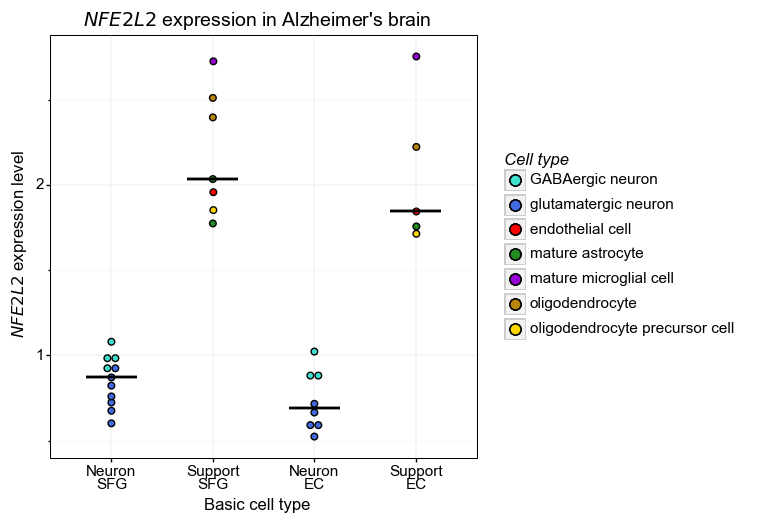

<ggplot: (8754949621185)>

In [132]:
# Now plot the data
gene = "ENSG00000116044"
gene_symbol = np.array(genes_df.loc[genes_df['ENSG'] == gene, 'symbol'])[0]

# calculate expression level max
abs_max_expr = max(plotting_df[gene])
abs_min_expr = min(plotting_df[gene])

# Calculate optimal dot size and bin width for geom_dotplot
binsize_calc = signif((abs_max_expr - abs_min_expr)/87, digits = 2)
dotsize_calc = 1.5

Figure_2A = (
    p9.ggplot(data = plotting_df, mapping = p9.aes(x="Basic class sub", y=gene)) + 
    p9.geom_dotplot(data = plotting_df.loc[plotting_df["Basic class sub"] == "Neuron\nSFG",], \
        mapping = p9.aes(fill = "cell_description"), color = "black", stackdir = "center", \
        binaxis = "y", dotsize = dotsize_calc, binwidth = binsize_calc, position = "identity", \
        stackgroups = True, stackratio = 1.2, binpositions = "all") +
    p9.geom_dotplot(data = plotting_df.loc[plotting_df["Basic class sub"] == "Neuron\nEC",], \
        mapping = p9.aes(fill = "cell_description"), color = "black", stackdir = "center", \
        binaxis = "y", dotsize = dotsize_calc, binwidth = binsize_calc, position = "identity", \
        stackgroups = True, stackratio = 1.2, binpositions = "all") +
    p9.geom_dotplot(data = plotting_df.loc[plotting_df["Basic class sub"] == "Support\nSFG",], \
        mapping = p9.aes(fill = "cell_description"), color = "black", stackdir = "center", \
        binaxis = "y", dotsize = dotsize_calc, binwidth = binsize_calc, position = "identity", \
        stackgroups = True, stackratio = 1.2, binpositions = "all") +
    p9.geom_dotplot(data = plotting_df.loc[plotting_df["Basic class sub"] == "Support\nEC",], \
        mapping = p9.aes(fill = "cell_description"), color = "black", stackdir = "center", \
        binaxis = "y", dotsize = dotsize_calc, binwidth = binsize_calc, position = "identity", \
        stackgroups = True, stackratio = 1.2, binpositions = "all") +
    p9.scales.scale_color_manual(aesthetics =  {"fill", "color"}, 
        values = ({'mature astrocyte' : "forestgreen", 'endothelial cell' : "red", 'glutamatergic neuron' : \
        "royalblue", 'GABAergic neuron' : "turquoise", 'mature microglial cell' : "darkviolet", \
        'oligodendrocyte' : "darkgoldenrod", 'oligodendrocyte precursor cell' : "gold"})) +
    p9.labs(x = "Basic cell type", y = str("$" + gene_symbol + "$ expression level"), fill = "Cell type", \
        title = str("$" + gene_symbol + "$ expression in Alzheimer's brain")) +
    p9.geom_errorbar(data = summ_df, inherit_aes = False, size = 1, \
        mapping = p9.aes(x="Basic class sub", ymin=str(gene + "_median"), ymax=str(gene + "_median"))) +
    p9.theme(strip_background = p9.element_blank(), strip_text = p9.element_blank(), \
        panel_spacing_x = 0.5, figure_size = (5.5, 5.5))
    )

Figure_2A

In [133]:
# Clean up environment
del(NRF2_idx, Neuron_types, abs_max_expr, abs_min_expr, all_genes, basic_class, binsize_calc, cell_clust_meta, \
    dotsize_calc, gene, gene_symbol, genes_df, human_expr_df, human_expr_orig, i, metadata, neur_EC, \
    neur_SFG, original_plotting_df_EC, original_plotting_df_SFG, plotting_df, summ_df, supp_EC, supp_SFG)

<br>

## Multiple Sclerosis  

In [134]:
# Import cell metadata
metadata = pd.read_table(filepath_or_buffer = "meta_MS-Schirmer.tsv.gz", delimiter= "\t")

# Check
metadata.head()
metadata.shape
metadata.columns

,cell,tsne1,tsne2,cluster_original,sample,diagnosis,stage,age,sex,region,...,genes,UMIs,mito_perc,ribo_perc,lesion_stage,cluster,cell_type,DMGM_UL,DMGM_DL,DMWM
0,AAACCTGGTCCATGAT-1_5981_BA9,19.121044,-20.540960,3,5981_BA9,Control,Control,44,female,prefrontal,...,3674,9333,0.005143,0.002357,0,3,EN-L5-6,NaN,NaN,NaN
1,AAACGGGAGTAGCCGA-1_5981_BA9,5.136135,-13.751351,4,5981_BA9,Control,Control,44,female,prefrontal,...,2407,4853,0.004945,0.003709,0,L2-3,EN-L2-3-MS,NaN,NaN,NaN
2,AAACGGGCATCGGTTA-1_5981_BA9,-28.210752,-20.764837,6A,5981_BA9,Control,Control,44,female,prefrontal,...,3593,7668,0.018519,0.006129,0,6A,IN-PV,NaN,NaN,NaN
3,AAACGGGTCCATGAAC-1_5981_BA9,29.946121,-15.725056,2,5981_BA9,Control,Control,44,female,prefrontal,...,3288,6940,0.016427,0.007061,0,2,EN-L4,NaN,NaN,NaN
4,AAAGATGCACGACTCG-1_5981_BA9,25.065271,-19.422704,3,5981_BA9,Control,Control,44,female,prefrontal,...,4161,10297,0.007672,0.003108,0,3,EN-L5-6,NaN,NaN,NaN


(48919, 24)

Index(['cell', 'tsne1', 'tsne2', 'cluster_original', 'sample', 'diagnosis',
       'stage', 'age', 'sex', 'region', 'Capbatch', 'Seqbatch', 'RIN', 'PMI',
       'genes', 'UMIs', 'mito_perc', 'ribo_perc', 'lesion_stage', 'cluster',
       'cell_type', 'DMGM_UL', 'DMGM_DL', 'DMWM'],
      dtype='object')

In [135]:
# If I look at rows with unique age, structure, area and cell-type cluster, there's many
metadata[['cluster_original', 'cluster', 'sample', 'age', 'stage', 'region', 'sex', 'diagnosis']].drop_duplicates().shape

# Filter/consolidate to only include a single row for each cell-type cluster + disease condition
cell_clust_meta = metadata[['cluster_original', 'cluster', 'cell_type', 'diagnosis']].drop_duplicates()
cell_clust_meta.sort_values(axis = 0, by = ['cell_type', 'diagnosis'], inplace = True)
cell_clust_meta.reset_index(drop = True, inplace = True)

(412, 8)

In [136]:
# Make cell type dictionary (full names)
celltype_dict = dict({'Astrocytes' : "astrocytes", 'B cells' : "B cells", 
    'EN-L2-3-Cntl' : "layer 2/3 excitatory neurons (control)", 
    'EN-L2-3-MS' : "layer 2/3 excitatory neurons (MS)", 'EN-L4' : "layer 4 excitatory neurons", 
    'EN-L5-6' : "layer 5/6 excitatory neurons", 'EN-MIX' : "excitatory neurons (mixed)", 
    'EN-PYR' : "pyramidal excitatory neurons", 'Endo cells' : "endothelial", 
    'Glia-MIX' : "glial", 'IN-PV' : "parvalbumin interneurons", 
    'IN-SST' : "somatostatin interneurons", 'IN-SV2C' : "SVC2 interneurons", 
    'IN-VIP' : "VIP interneurons", 'Microglia' : "microglia", 
    'OL-Cntl' : "oligodendrocytes (Control)", 'OL-MS-1' : "oligodendrocytes (MS-1)", 
    'OL-MS-2' : "oligodendrocytes (MS-2)", 'OPC' : "oligodendrocyte precursors", 
    'Phagocytes' : "phagocytes", 'Stromal cells' : "stromal cells", 'T cells' : "T cells"})

# Combine back with cell metadata
cell_clust_meta = cell_clust_meta.merge(pd.DataFrame(celltype_dict.items()).rename(columns = {0 : "cell_type", 1 : "celltype_name"}))

# Make additional column combining cluster/celltype and diagnosis
cell_clust_meta['cell_class'] = cell_clust_meta['cell_type'] + "_" + cell_clust_meta['diagnosis']

# Also do the same for the full dataframe
metadata['cell_class'] = metadata['cell_type'] + "_" + metadata['diagnosis']

# Add count of cell number per cell type
cell_clust_meta = cell_clust_meta.merge(pd.DataFrame(metadata[['cell_class', 
    'cell']].groupby(['cell_class']).count(), copy = False).reset_index().rename(columns = 
    {'cell' : 'cell_number'}))

# Check resulting dataframe
cell_clust_meta.iloc[[0,1,2,3,4,5], [4,5,6]]
cell_clust_meta.shape

,celltype_name,cell_class,cell_number
0,astrocytes,Astrocytes_Control,1571
1,astrocytes,Astrocytes_MS,3810
2,B cells,B cells_MS,53
3,layer 2/3 excitatory neurons (control),EN-L2-3-Cntl_Control,2418
4,layer 2/3 excitatory neurons (control),EN-L2-3-Cntl_MS,411
5,layer 2/3 excitatory neurons (MS),EN-L2-3-MS_Control,1063


(43, 7)

In [137]:
# Import all genes (both gene name and Ensembl symbol)
genes_df = pd.read_table("genes_MS-Schirmer.tsv.gz", header = None).set_axis(['ENSG', 'symbol'], axis = 1, copy = False)

# Import expression dataset using Pandas (average gene counts/expression per cluster) - careful it takes a minute/2 to load
human_expr_orig = pd.read_table("human_MS-Schirmer_cellbrowser_mean-counts-per-celltype-&-diagnosis.tsv.gz", index_col = 0)

# Check it
human_expr_orig.shape
human_expr_orig.iloc[0:5, 0:3]
all_genes_num = human_expr_orig.shape[0]

(65217, 43)

,Astrocytes_Control,Astrocytes_MS,B cells_MS
gene,,,
DDX11L1,0.000000,0.000000,0.0
WASH7P,0.010185,0.015486,0.0
MIR6859-3,0.000000,0.000000,0.0
RP11-34P13.3,0.000000,0.000262,0.0
MIR1302-9,0.000000,0.000000,0.0


In [138]:
# Check for NaN's/NA's and infinites
human_expr_orig.isna().sum()

# Check library size distribution
np.quantile((np.array(human_expr_orig.sum(axis = 0))), q = [0.01, 0.25,0.5,0.75,.99])

Astrocytes_Control       0
Astrocytes_MS            0
B cells_MS               0
EN-L2-3-Cntl_Control     0
EN-L2-3-Cntl_MS          0
EN-L2-3-MS_Control       0
EN-L2-3-MS_MS            0
EN-L4_Control            0
EN-L4_MS                 0
EN-L5-6_Control          0
EN-L5-6_MS               0
EN-MIX_Control           0
EN-MIX_MS                0
EN-PYR_Control           0
EN-PYR_MS                0
Endo cells_Control       0
Endo cells_MS            0
Glia-MIX_Control         0
Glia-MIX_MS              0
IN-PV_Control            0
IN-PV_MS                 0
IN-SST_Control           0
IN-SST_MS                0
IN-SV2C_Control          0
IN-SV2C_MS               0
IN-VIP_Control           0
IN-VIP_MS                0
Microglia_Control        0
Microglia_MS             0
OL-Cntl_Control          0
OL-Cntl_MS               0
OL-MS-1_Control          0
OL-MS-1_MS               0
OL-MS-2_Control          0
OL-MS-2_MS               0
OPC_Control              0
OPC_MS                   0
P

array([ 1288.82412371,  1650.46601942,  2455.03773585,  6095.99372474,
       13229.74057049])

In [139]:
# Now calculate the total mean UMI across all genes in each cell type and
# library size-normalize with those numbers
human_expr_df = pd.DataFrame((human_expr_orig / (human_expr_orig.sum(axis = 0)))*10000, copy = True) # multiply by 10000 to scale up a bit

# Check
human_expr_df.iloc[0:6, 0:3] 

# Check column names and colsums
human_expr_df.columns
human_expr_df.sum(axis = 0)

,Astrocytes_Control,Astrocytes_MS,B cells_MS
gene,,,
DDX11L1,0.00000,0.000000,0.0
WASH7P,0.04895,0.064042,0.0
MIR6859-3,0.00000,0.000000,0.0
RP11-34P13.3,0.00000,0.001085,0.0
MIR1302-9,0.00000,0.000000,0.0
FAM138A,0.00000,0.000000,0.0


Index(['Astrocytes_Control', 'Astrocytes_MS', 'B cells_MS',
       'EN-L2-3-Cntl_Control', 'EN-L2-3-Cntl_MS', 'EN-L2-3-MS_Control',
       'EN-L2-3-MS_MS', 'EN-L4_Control', 'EN-L4_MS', 'EN-L5-6_Control',
       'EN-L5-6_MS', 'EN-MIX_Control', 'EN-MIX_MS', 'EN-PYR_Control',
       'EN-PYR_MS', 'Endo cells_Control', 'Endo cells_MS', 'Glia-MIX_Control',
       'Glia-MIX_MS', 'IN-PV_Control', 'IN-PV_MS', 'IN-SST_Control',
       'IN-SST_MS', 'IN-SV2C_Control', 'IN-SV2C_MS', 'IN-VIP_Control',
       'IN-VIP_MS', 'Microglia_Control', 'Microglia_MS', 'OL-Cntl_Control',
       'OL-Cntl_MS', 'OL-MS-1_Control', 'OL-MS-1_MS', 'OL-MS-2_Control',
       'OL-MS-2_MS', 'OPC_Control', 'OPC_MS', 'Phagocytes_Control',
       'Phagocytes_MS', 'Stromal cells_Control', 'Stromal cells_MS',
       'T cells_Control', 'T cells_MS'],
      dtype='object')

Astrocytes_Control       10000.0
Astrocytes_MS            10000.0
B cells_MS               10000.0
EN-L2-3-Cntl_Control     10000.0
EN-L2-3-Cntl_MS          10000.0
EN-L2-3-MS_Control       10000.0
EN-L2-3-MS_MS            10000.0
EN-L4_Control            10000.0
EN-L4_MS                 10000.0
EN-L5-6_Control          10000.0
EN-L5-6_MS               10000.0
EN-MIX_Control           10000.0
EN-MIX_MS                10000.0
EN-PYR_Control           10000.0
EN-PYR_MS                10000.0
Endo cells_Control       10000.0
Endo cells_MS            10000.0
Glia-MIX_Control         10000.0
Glia-MIX_MS              10000.0
IN-PV_Control            10000.0
IN-PV_MS                 10000.0
IN-SST_Control           10000.0
IN-SST_MS                10000.0
IN-SV2C_Control          10000.0
IN-SV2C_MS               10000.0
IN-VIP_Control           10000.0
IN-VIP_MS                10000.0
Microglia_Control        10000.0
Microglia_MS             10000.0
OL-Cntl_Control          10000.0
OL-Cntl_MS

In [140]:
# First compare gene list to gene name dataframe
NRF2_idx = genes_df.loc[genes_df['symbol'] == "NFE2L2",].index.tolist()

# Check and make sure they match the expression df
human_expr_df.iloc[NRF2_idx,].index

# Check
human_expr_df.iloc[NRF2_idx, 0:6]

Index(['NFE2L2'], dtype='object', name='gene')

,Astrocytes_Control,Astrocytes_MS,B cells_MS,EN-L2-3-Cntl_Control,EN-L2-3-Cntl_MS,EN-L2-3-MS_Control
gene,,,,,,
NFE2L2,1.655123,1.539183,1.075955,0.311526,0.348326,0.235319


In [141]:
# Check and make sure cell namesy are the same between metadata and expr df
cell_clust_meta.columns
cell_clust_meta['cell_class'].tolist()
human_expr_df.columns.tolist()

# Make dataframe for plotting, with relevant sample/cell info
plotting_df = pd.DataFrame(cell_clust_meta, copy = True)

# Check all the possible basic cell-type classes
pd.unique(plotting_df["cell_type"])

Index(['cluster_original', 'cluster', 'cell_type', 'diagnosis',
       'celltype_name', 'cell_class', 'cell_number'],
      dtype='object')

['Astrocytes_Control',
 'Astrocytes_MS',
 'B cells_MS',
 'EN-L2-3-Cntl_Control',
 'EN-L2-3-Cntl_MS',
 'EN-L2-3-MS_Control',
 'EN-L2-3-MS_MS',
 'EN-L4_Control',
 'EN-L4_MS',
 'EN-L5-6_Control',
 'EN-L5-6_MS',
 'EN-MIX_Control',
 'EN-MIX_MS',
 'EN-PYR_Control',
 'EN-PYR_MS',
 'Endo cells_Control',
 'Endo cells_MS',
 'Glia-MIX_Control',
 'Glia-MIX_MS',
 'IN-PV_Control',
 'IN-PV_MS',
 'IN-SST_Control',
 'IN-SST_MS',
 'IN-SV2C_Control',
 'IN-SV2C_MS',
 'IN-VIP_Control',
 'IN-VIP_MS',
 'Microglia_Control',
 'Microglia_MS',
 'OL-Cntl_Control',
 'OL-Cntl_MS',
 'OL-MS-1_Control',
 'OL-MS-1_MS',
 'OL-MS-2_Control',
 'OL-MS-2_MS',
 'OPC_Control',
 'OPC_MS',
 'Phagocytes_Control',
 'Phagocytes_MS',
 'Stromal cells_Control',
 'Stromal cells_MS',
 'T cells_Control',
 'T cells_MS']

['Astrocytes_Control',
 'Astrocytes_MS',
 'B cells_MS',
 'EN-L2-3-Cntl_Control',
 'EN-L2-3-Cntl_MS',
 'EN-L2-3-MS_Control',
 'EN-L2-3-MS_MS',
 'EN-L4_Control',
 'EN-L4_MS',
 'EN-L5-6_Control',
 'EN-L5-6_MS',
 'EN-MIX_Control',
 'EN-MIX_MS',
 'EN-PYR_Control',
 'EN-PYR_MS',
 'Endo cells_Control',
 'Endo cells_MS',
 'Glia-MIX_Control',
 'Glia-MIX_MS',
 'IN-PV_Control',
 'IN-PV_MS',
 'IN-SST_Control',
 'IN-SST_MS',
 'IN-SV2C_Control',
 'IN-SV2C_MS',
 'IN-VIP_Control',
 'IN-VIP_MS',
 'Microglia_Control',
 'Microglia_MS',
 'OL-Cntl_Control',
 'OL-Cntl_MS',
 'OL-MS-1_Control',
 'OL-MS-1_MS',
 'OL-MS-2_Control',
 'OL-MS-2_MS',
 'OPC_Control',
 'OPC_MS',
 'Phagocytes_Control',
 'Phagocytes_MS',
 'Stromal cells_Control',
 'Stromal cells_MS',
 'T cells_Control',
 'T cells_MS']

array(['Astrocytes', 'B cells', 'EN-L2-3-Cntl', 'EN-L2-3-MS', 'EN-L4',
       'EN-L5-6', 'EN-MIX', 'EN-PYR', 'Endo cells', 'Glia-MIX', 'IN-PV',
       'IN-SST', 'IN-SV2C', 'IN-VIP', 'Microglia', 'OL-Cntl', 'OL-MS-1',
       'OL-MS-2', 'OPC', 'Phagocytes', 'Stromal cells', 'T cells'],
      dtype=object)

In [142]:
# Make a new column, and define things as Neuron or Non-neuron
Neuron_types = ['EN-L2-3-Cntl', 'EN-L2-3-MS', 'EN-L4', 'EN-L5-6', 'EN-MIX', 
    'EN-PYR',  'IN-PV', 'IN-SST', 'IN-SV2C', 'IN-VIP']
basic_class=[]
for i in plotting_df["cell_type"]:
    if(any(i == x for x in Neuron_types)):
        basic_class.append("Neuron")
    else:
        basic_class.append("Support")
plotting_df["Basic class"] = basic_class

# Also combine diagnosis and basic class and make into categorical
plotting_df["Basic class sub"] = pd.Categorical(plotting_df["Basic class"] + 
    "\n" + plotting_df['diagnosis'], categories = ['Neuron\nControl', 'Support\nControl', 
    'Neuron\nMS', 'Support\nMS'])

# Check the amount of each basic class
plotting_df["Basic class sub"].value_counts()

# Check
plotting_df.head()

Support\nMS         12
Support\nControl    11
Neuron\nControl     10
Neuron\nMS          10
Name: Basic class sub, dtype: int64

,cluster_original,cluster,cell_type,diagnosis,celltype_name,cell_class,cell_number,Basic class,Basic class sub
0,8,8,Astrocytes,Control,astrocytes,Astrocytes_Control,1571,Support,Support\nControl
1,8,8,Astrocytes,MS,astrocytes,Astrocytes_MS,3810,Support,Support\nMS
2,15DB,15DB,B cells,MS,B cells,B cells_MS,53,Support,Support\nMS
3,10,L2-3,EN-L2-3-Cntl,Control,layer 2/3 excitatory neurons (control),EN-L2-3-Cntl_Control,2418,Neuron,Neuron\nControl
4,10,L2-3,EN-L2-3-Cntl,MS,layer 2/3 excitatory neurons (control),EN-L2-3-Cntl_MS,411,Neuron,Neuron\nMS


In [143]:
# 'Save' this version
original_plotting_df = plotting_df.copy()

<br>

Now I will do multiple testing correction statistics on the MS data

In [144]:
# Make dataframe with all genes for doing multiple testing correction statistics
stats_df = plotting_df.copy()
stats_df = stats_df.merge(right = pd.DataFrame(human_expr_df.transpose(), copy = True).reset_index(\
    ).rename(columns = {'index' : 'cell_class'}), left_on = "cell_class", right_on = "cell_class")

In [145]:
stats_df.columns

Index(['cluster_original', 'cluster', 'cell_type', 'diagnosis',
       'celltype_name', 'cell_class', 'cell_number', 'Basic class',
       'Basic class sub', 'DDX11L1',
       ...
       'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', length=65226)

In [146]:
# loop through all genes and get pvalue by Matt-Whitney U test
all_p_ctrl = list()
all_p_MS = list()
all_gene = list()

# Get the values for each Basic class sub and do statistical tests
for gene in stats_df.columns[9:]:
    neur_ctrl = stats_df.loc[stats_df['Basic class sub'] == 'Neuron\nControl', gene]
    supp_ctrl = stats_df.loc[stats_df['Basic class sub'] == 'Support\nControl', gene]
    neur_MS = stats_df.loc[stats_df['Basic class sub'] == 'Neuron\nMS', gene]
    supp_MS = stats_df.loc[stats_df['Basic class sub'] == 'Support\nMS', gene]
    all_gene.append(gene)
    all_p_ctrl.append(mannwhitneyu(neur_ctrl, supp_ctrl)[1])
    all_p_MS.append(mannwhitneyu(neur_MS, supp_MS)[1])

# Do FDR correction
all_padj_ctrl = statsmodels.stats.multitest.fdrcorrection(all_p_ctrl, alpha=0.05, method='indep', is_sorted=False)
all_padj_MS = statsmodels.stats.multitest.fdrcorrection(all_p_MS, alpha=0.05, method='indep', is_sorted=False)

In [147]:
# Check the number of genes with p < 0.05 and FDR < 0.05
print(f"Control: number of genes p < 0.05 = { len(np.array(all_p_ctrl)[[(x < 0.05) for x in all_p_ctrl]]) }")
print(f"\nControl: number of genes FDR < 0.05 = { len(all_padj_ctrl[1][all_padj_ctrl[1] < 0.05]) }")
print(f"\nMS: number of genes p < 0.05 = { len(np.array(all_p_MS)[[(x < 0.05) for x in all_p_MS]]) }")
print(f"\nMS: number of genes FDR < 0.05 = { len(all_padj_MS[1][all_padj_MS[1] < 0.05]) }")

Control: number of genes p < 0.05 = 12718

Control: number of genes FDR < 0.05 = 3691

MS: number of genes p < 0.05 = 11007

MS: number of genes FDR < 0.05 = 4749


In [148]:
# output FDR for NFE2L2 only
for i in range(0,len(all_gene)):
    if all_gene[i] == "NFE2L2":
        print(f"{all_gene[i]}\n")
        print(f"Control NFE2L2 p = {all_p_ctrl[i]}")
        print(f"\nControl NFE2L2 FDR = {all_padj_ctrl[1][i]}")
        print(f"\nMS NFE2L2 p = {all_p_MS[i]}")
        print(f"\nMS NFE2L2 FDR = {all_padj_MS[1][i]}")

NFE2L2

Control NFE2L2 p = 0.00172678648453393

Control NFE2L2 FDR = 0.03818780405623917

MS NFE2L2 p = 8.733926588357827e-05

MS NFE2L2 FDR = 0.009497558922559724


In [149]:
# Now add the expression data to the plotting data
plotting_df = original_plotting_df.merge(right = pd.DataFrame(human_expr_df.iloc[ \
    NRF2_idx].transpose(), copy = True).reset_index().rename(columns = {'index' : 'cell_class'}), \
    left_on = "cell_class", right_on = "cell_class")

# Check
plotting_df.columns
plotting_df.loc[0:6, plotting_df.columns[[5,4,6,9]]]
plotting_df.shape

Index(['cluster_original', 'cluster', 'cell_type', 'diagnosis',
       'celltype_name', 'cell_class', 'cell_number', 'Basic class',
       'Basic class sub', 'NFE2L2'],
      dtype='object')

,cell_class,celltype_name,cell_number,NFE2L2
0,Astrocytes_Control,astrocytes,1571,1.655123
1,Astrocytes_MS,astrocytes,3810,1.539183
2,B cells_MS,B cells,53,1.075955
3,EN-L2-3-Cntl_Control,layer 2/3 excitatory neurons (control),2418,0.311526
4,EN-L2-3-Cntl_MS,layer 2/3 excitatory neurons (control),411,0.348326
5,EN-L2-3-MS_Control,layer 2/3 excitatory neurons (MS),1063,0.235319
6,EN-L2-3-MS_MS,layer 2/3 excitatory neurons (MS),2228,0.244733


(43, 10)

In [150]:
# Now calculate summary values for all expression columns - mean and median
summ_df = plotting_df.drop(['cluster_original', 'cluster', 'cell_type', 'diagnosis', \
    'celltype_name', 'cell_class', 'cell_number', 'Basic class'], \
    axis = 1).groupby(['Basic class sub'], axis = 0).agg(['mean','median'])

# Collapse 'MultiIndex' returned by summarizing to flattened col index
summ_df.columns = ['_'.join(col) for col in summ_df.columns.values]
summ_df.reset_index(inplace = True)

# Check
summ_df.iloc[0:4, 0:5]

,Basic class sub,NFE2L2_mean,NFE2L2_median
0,Neuron\nControl,0.349317,0.351426
1,Support\nControl,1.547884,1.655123
2,Neuron\nMS,0.368887,0.364685
3,Support\nMS,1.640565,1.594030


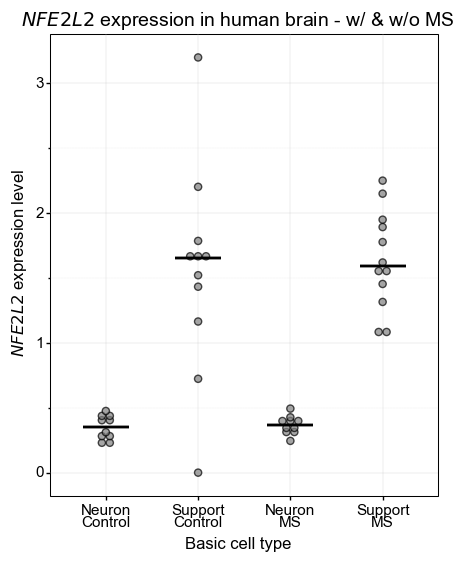

<ggplot: (8754944176204)>

In [151]:
# Now plot the data
gene = "NFE2L2"

# calculate expression level max
abs_max_expr = max(plotting_df[gene])
abs_min_expr = min(plotting_df[gene])

# Calculate optimal dot size and bin width for geom_dotplot
binsize_calc = signif((abs_max_expr - abs_min_expr)/87, digits = 2)
dotsize_calc = 1.5

Figure_2B = (
        p9.ggplot(data = plotting_df, mapping = p9.aes(x="Basic class sub", y=gene)) + 
        p9.geom_dotplot(data = plotting_df.loc[plotting_df["Basic class sub"] == "Neuron\nControl",], 
            color = "black", fill = "gray", alpha = 0.7, stackdir = "center", 
            binaxis = "y", dotsize = dotsize_calc, binwidth = binsize_calc, position = "identity", 
            stackgroups = True, stackratio = 1.1, binpositions = "all") +
        p9.geom_dotplot(data = plotting_df.loc[plotting_df["Basic class sub"] == "Support\nControl",], 
            color = "black", fill = "gray", alpha = 0.7, stackdir = "center", 
            binaxis = "y", dotsize = dotsize_calc, binwidth = binsize_calc, position = "identity",
            stackgroups = True, stackratio = 1.1, binpositions = "all") +
        p9.geom_dotplot(data = plotting_df.loc[plotting_df["Basic class sub"] == "Neuron\nMS",], 
            color = "black", fill = "gray", alpha = 0.7, stackdir = "center", 
            binaxis = "y", dotsize = dotsize_calc, binwidth = binsize_calc, position = "identity", 
            stackgroups = True, stackratio = 1.1, binpositions = "all") +
        p9.geom_dotplot(data = plotting_df.loc[plotting_df["Basic class sub"] == "Support\nMS",], 
            color = "black", fill = "gray", alpha = 0.7, stackdir = "center", 
            binaxis = "y", dotsize = dotsize_calc, binwidth = binsize_calc, position = "identity", 
            stackgroups = True, stackratio = 1.1, binpositions = "all") +
        p9.labs(x = "Basic cell type", y = str("$" + gene + "$ expression level"),
            title = str("$" + gene + "$ expression in human brain - w/ & w/o MS")) +
        p9.geom_errorbar(data = summ_df, inherit_aes = False, size = 1,
            mapping = p9.aes(x="Basic class sub", ymin=str(gene + "_median"), ymax=str(gene + "_median"))) +
        p9.theme(strip_background = p9.element_blank(), strip_text = p9.element_blank(),
                 panel_spacing_x = 0.5, figure_size = (5, 6), legend_position = "none")
        )

Figure_2B

In [152]:
# Clean up environment
del(basic_class, binsize_calc, cell_clust_meta, celltype_dict, dotsize_calc, gene, genes_df, human_expr_df, \
    human_expr_orig, metadata, neur_ctrl, neur_MS, original_plotting_df, plotting_df, summ_df, supp_ctrl, supp_MS)

<br>

## Autism  

In [153]:
# Import cell metadata
metadata = pd.read_table(filepath_or_buffer = "meta_autism.tsv.gz", delimiter= "\t")

# Check
metadata.head()
metadata.shape
metadata.columns

,cell,cluster,sample,individual,region,age,sex,diagnosis,Capbatch,Seqbatch,post-mortem interval (hours),RNA Integrity Number,genes,UMIs,RNA mitochondr. percent,RNA ribosomal percent
0,AAACCTGGTACGCACC-1_1823_BA24,Neu-NRGN-II,1823_BA24,1823,ACC,15,M,Control,CB8,SB3,18,7.0,622,774,2.454780,1.421189
1,AAACGGGCACCAGATT-1_1823_BA24,L5/6,1823_BA24,1823,ACC,15,M,Control,CB8,SB3,18,7.0,6926,24042,0.445055,0.428417
2,AAAGATGAGTCCAGGA-1_1823_BA24,Oligodendrocytes,1823_BA24,1823,ACC,15,M,Control,CB8,SB3,18,7.0,624,830,0.240964,0.722892
3,AAAGATGTCTTGAGGT-1_1823_BA24,OPC,1823_BA24,1823,ACC,15,M,Control,CB8,SB3,18,7.0,1192,1771,0.225861,1.806889
4,AAAGCAAGTAATCACC-1_1823_BA24,Oligodendrocytes,1823_BA24,1823,ACC,15,M,Control,CB8,SB3,18,7.0,691,895,0.558659,0.670391


(104559, 16)

Index(['cell', 'cluster', 'sample', 'individual', 'region', 'age', 'sex',
       'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)',
       'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent',
       'RNA ribosomal percent'],
      dtype='object')

In [154]:
# If I look at rows with unique age, structure, area and cell-type cluster, there's many
metadata[['cluster', 'sample', 'age', 'region', 'diagnosis', 'sex']].drop_duplicates().shape

# Filter/consolidate to only include a single row for each cell-type cluster + disease condition
cell_clust_meta = metadata[['cluster', 'diagnosis']].drop_duplicates()
cell_clust_meta.sort_values(axis = 0, by = ['cluster', 'diagnosis'], inplace = True)
cell_clust_meta.reset_index(drop = True, inplace = True)
cell_clust_meta.head()
cell_clust_meta.shape

(691, 6)

,cluster,diagnosis
0,AST-FB,ASD
1,AST-FB,Control
2,AST-PP,ASD
3,AST-PP,Control
4,Endothelial,ASD


(34, 2)

In [155]:
# Cell type dictionary
celltype_dict = dict({'AST-FB' : "fibrous astrocytes", 'AST-PP' : "protoplasmic astrocytes", 
    'Endothelial' : "endothelial", 'IN-PV' : "parvalbumin interneurons", 'IN-SST' : "somatostatin interneurons",
    'IN-SV2C' : "SV2C interneurons", 'IN-VIP' : "VIP interneurons", 'L2/3' : "layer 2/3 excitatory neurons",
    'L4' : "layer 4 excitatory neurons", 'L5/6' : "layer 5/6 corticofugal projection neurons", 
    'L5/6-CC' : "layer 5/6 cortico-cortical projection neurons", 'Microglia' : "microglia", 
    'Neu-NRGN-I' : "NRGN-expressing neurons I", 'Neu-NRGN-II' : "NRGN-expressing neurons II",
    'Neu-mat' : "maturing neurons", 'OPC' : "oligodedrocyte precursors", 
    'Oligodendrocytes' : "oligodendrocytes"})

# Combine back with cell metadata
cell_clust_meta = cell_clust_meta.merge(pd.DataFrame(celltype_dict.items()).rename(columns = {0 : "cluster", 1 : "celltype_name"}))

# Make additional column combining cluster/celltype and diagnosis
cell_clust_meta['cell_class'] = cell_clust_meta['cluster'] + "_" + cell_clust_meta['diagnosis']

In [156]:
# Import all genes (both gene name and Ensembl symbol)
genes_df = pd.read_table("genes_autism.tsv.gz", header = None).set_axis(['ENSG', 'symbol'], axis = 1, copy = False)

# Import expression dataset using Pandas (average gene counts/expression per cluster) - careful it takes a minute/2 to load
human_expr_orig = pd.read_table("human_autism_cellbrowser_mean-counts-per-cluster-&-diagnosis.tsv.gz", index_col = 0)

# Check it
human_expr_orig.shape
human_expr_orig.iloc[0:5, 0:5]
all_genes_num = human_expr_orig.shape[0]

(65217, 34)

,AST-FB_ASD,AST-FB_Control,AST-PP_ASD,AST-PP_Control,Endothelial_ASD
gene,,,,,
DDX11L1,0.000000,0.000000,0.000000,0.000000,0.000000
WASH7P,0.013889,0.006623,0.014244,0.018182,0.014286
MIR6859-3,0.000000,0.000000,0.000000,0.000000,0.000000
RP11-34P13.3,0.000000,0.000000,0.000195,0.000000,0.000000
MIR1302-9,0.000000,0.000000,0.000000,0.000000,0.000000


In [157]:
# Check for NaN's/NA's and infinites
human_expr_orig.isna().sum()

# Check library size distribution
np.quantile((np.array(human_expr_orig.sum(axis = 0))), q = [0.01, 0.25,0.5,0.75,.99])

AST-FB_ASD                  0
AST-FB_Control              0
AST-PP_ASD                  0
AST-PP_Control              0
Endothelial_ASD             0
Endothelial_Control         0
IN-PV_ASD                   0
IN-PV_Control               0
IN-SST_ASD                  0
IN-SST_Control              0
IN-SV2C_ASD                 0
IN-SV2C_Control             0
IN-VIP_ASD                  0
IN-VIP_Control              0
L2/3_ASD                    0
L2/3_Control                0
L4_ASD                      0
L4_Control                  0
L5/6_ASD                    0
L5/6_Control                0
L5/6-CC_ASD                 0
L5/6-CC_Control             0
Microglia_ASD               0
Microglia_Control           0
Neu-mat_ASD                 0
Neu-mat_Control             0
Neu-NRGN-I_ASD              0
Neu-NRGN-I_Control          0
Neu-NRGN-II_ASD             0
Neu-NRGN-II_Control         0
Oligodendrocytes_ASD        0
Oligodendrocytes_Control    0
OPC_ASD                     0
OPC_Contro

array([  812.11509392,  1575.02827117,  2370.61829472,  8209.10455784,
       20741.31649489])

In [158]:
# Now calculate the total mean UMI across all genes in each cell type and
# library size-normalize with those numbers
human_expr_df = pd.DataFrame((human_expr_orig / (human_expr_orig.sum(axis = 0)))*10000, copy = True) # multiply by 10000 to scale up a bit

# Check
human_expr_df.iloc[0:6, 0:5] 

,AST-FB_ASD,AST-FB_Control,AST-PP_ASD,AST-PP_Control,Endothelial_ASD
gene,,,,,
DDX11L1,0.000000,0.000000,0.000000,0.000000,0.000000
WASH7P,0.140162,0.062442,0.072159,0.074638,0.068451
MIR6859-3,0.000000,0.000000,0.000000,0.000000,0.000000
RP11-34P13.3,0.000000,0.000000,0.000988,0.000000,0.000000
MIR1302-9,0.000000,0.000000,0.000000,0.000000,0.000000
FAM138A,0.000000,0.000000,0.000000,0.000000,0.000000


In [159]:
# Check column names and colsums
human_expr_df.columns
human_expr_df.sum(axis = 0)

Index(['AST-FB_ASD', 'AST-FB_Control', 'AST-PP_ASD', 'AST-PP_Control',
       'Endothelial_ASD', 'Endothelial_Control', 'IN-PV_ASD', 'IN-PV_Control',
       'IN-SST_ASD', 'IN-SST_Control', 'IN-SV2C_ASD', 'IN-SV2C_Control',
       'IN-VIP_ASD', 'IN-VIP_Control', 'L2/3_ASD', 'L2/3_Control', 'L4_ASD',
       'L4_Control', 'L5/6_ASD', 'L5/6_Control', 'L5/6-CC_ASD',
       'L5/6-CC_Control', 'Microglia_ASD', 'Microglia_Control', 'Neu-mat_ASD',
       'Neu-mat_Control', 'Neu-NRGN-I_ASD', 'Neu-NRGN-I_Control',
       'Neu-NRGN-II_ASD', 'Neu-NRGN-II_Control', 'Oligodendrocytes_ASD',
       'Oligodendrocytes_Control', 'OPC_ASD', 'OPC_Control'],
      dtype='object')

AST-FB_ASD                  10000.0
AST-FB_Control              10000.0
AST-PP_ASD                  10000.0
AST-PP_Control              10000.0
Endothelial_ASD             10000.0
Endothelial_Control         10000.0
IN-PV_ASD                   10000.0
IN-PV_Control               10000.0
IN-SST_ASD                  10000.0
IN-SST_Control              10000.0
IN-SV2C_ASD                 10000.0
IN-SV2C_Control             10000.0
IN-VIP_ASD                  10000.0
IN-VIP_Control              10000.0
L2/3_ASD                    10000.0
L2/3_Control                10000.0
L4_ASD                      10000.0
L4_Control                  10000.0
L5/6_ASD                    10000.0
L5/6_Control                10000.0
L5/6-CC_ASD                 10000.0
L5/6-CC_Control             10000.0
Microglia_ASD               10000.0
Microglia_Control           10000.0
Neu-mat_ASD                 10000.0
Neu-mat_Control             10000.0
Neu-NRGN-I_ASD              10000.0
Neu-NRGN-I_Control          

In [160]:
# Get all rows from the expression matrix that match these genes
# First compare gene list to gene name dataframe
NRF2_idx = genes_df.loc[genes_df['symbol'] == "NFE2L2", ].index.tolist()

# Check and make sure they match the expression df
human_expr_df.iloc[NRF2_idx,].index

# Check
human_expr_df.iloc[NRF2_idx, 0:6]

Index(['NFE2L2'], dtype='object', name='gene')

,AST-FB_ASD,AST-FB_Control,AST-PP_ASD,AST-PP_Control,Endothelial_ASD,Endothelial_Control
gene,,,,,,
NFE2L2,1.521169,1.413857,1.710061,1.3873,1.433191,1.431079


In [161]:
# Check and make sure cell namesy are the same between metadata and expr df
cell_clust_meta.columns
cell_clust_meta['cell_class'].tolist()
human_expr_df.columns.tolist()

# Make dataframe for plotting, with relevant sample/cell info
plotting_df = cell_clust_meta.copy()

# Check all the possible basic cell-type classes
pd.unique(plotting_df["cluster"])

Index(['cluster', 'diagnosis', 'celltype_name', 'cell_class'], dtype='object')

['AST-FB_ASD',
 'AST-FB_Control',
 'AST-PP_ASD',
 'AST-PP_Control',
 'Endothelial_ASD',
 'Endothelial_Control',
 'IN-PV_ASD',
 'IN-PV_Control',
 'IN-SST_ASD',
 'IN-SST_Control',
 'IN-SV2C_ASD',
 'IN-SV2C_Control',
 'IN-VIP_ASD',
 'IN-VIP_Control',
 'L2/3_ASD',
 'L2/3_Control',
 'L4_ASD',
 'L4_Control',
 'L5/6_ASD',
 'L5/6_Control',
 'L5/6-CC_ASD',
 'L5/6-CC_Control',
 'Microglia_ASD',
 'Microglia_Control',
 'Neu-NRGN-I_ASD',
 'Neu-NRGN-I_Control',
 'Neu-NRGN-II_ASD',
 'Neu-NRGN-II_Control',
 'Neu-mat_ASD',
 'Neu-mat_Control',
 'OPC_ASD',
 'OPC_Control',
 'Oligodendrocytes_ASD',
 'Oligodendrocytes_Control']

['AST-FB_ASD',
 'AST-FB_Control',
 'AST-PP_ASD',
 'AST-PP_Control',
 'Endothelial_ASD',
 'Endothelial_Control',
 'IN-PV_ASD',
 'IN-PV_Control',
 'IN-SST_ASD',
 'IN-SST_Control',
 'IN-SV2C_ASD',
 'IN-SV2C_Control',
 'IN-VIP_ASD',
 'IN-VIP_Control',
 'L2/3_ASD',
 'L2/3_Control',
 'L4_ASD',
 'L4_Control',
 'L5/6_ASD',
 'L5/6_Control',
 'L5/6-CC_ASD',
 'L5/6-CC_Control',
 'Microglia_ASD',
 'Microglia_Control',
 'Neu-mat_ASD',
 'Neu-mat_Control',
 'Neu-NRGN-I_ASD',
 'Neu-NRGN-I_Control',
 'Neu-NRGN-II_ASD',
 'Neu-NRGN-II_Control',
 'Oligodendrocytes_ASD',
 'Oligodendrocytes_Control',
 'OPC_ASD',
 'OPC_Control']

array(['AST-FB', 'AST-PP', 'Endothelial', 'IN-PV', 'IN-SST', 'IN-SV2C',
       'IN-VIP', 'L2/3', 'L4', 'L5/6', 'L5/6-CC', 'Microglia',
       'Neu-NRGN-I', 'Neu-NRGN-II', 'Neu-mat', 'OPC', 'Oligodendrocytes'],
      dtype=object)

In [162]:

# Make a new column, and define things as Neuron or Non-neuron
Neuron_types = ['IN-PV', 'IN-SST', 'IN-SV2C', 'IN-VIP', 'L2/3', 'L4', 'L5/6', 'L5/6-CC', 
       'Neu-NRGN-I', 'Neu-NRGN-II', 'Neu-mat']
basic_class=[]
for i in plotting_df["cluster"]:
    if(any(i == x for x in Neuron_types)):
        basic_class.append("Neuron")
    else:
        basic_class.append("Support")
plotting_df["Basic class"] = basic_class

# Also combine diagnosis and basic class and make into categorical
plotting_df["Basic class sub"] = pd.Categorical(plotting_df["Basic class"] + 
    "\n" + plotting_df['diagnosis'], categories = ['Neuron\nControl', 'Support\nControl', 
    'Neuron\nASD', 'Support\nASD'])

# Check the amount of each basic class
plotting_df["Basic class sub"].value_counts()

# Check
plotting_df.head()

Neuron\nControl     11
Neuron\nASD         11
Support\nControl     6
Support\nASD         6
Name: Basic class sub, dtype: int64

,cluster,diagnosis,celltype_name,cell_class,Basic class,Basic class sub
0,AST-FB,ASD,fibrous astrocytes,AST-FB_ASD,Support,Support\nASD
1,AST-FB,Control,fibrous astrocytes,AST-FB_Control,Support,Support\nControl
2,AST-PP,ASD,protoplasmic astrocytes,AST-PP_ASD,Support,Support\nASD
3,AST-PP,Control,protoplasmic astrocytes,AST-PP_Control,Support,Support\nControl
4,Endothelial,ASD,endothelial,Endothelial_ASD,Support,Support\nASD


In [163]:
# 'Save' this version
original_plotting_df = pd.DataFrame(plotting_df, copy = True)

In [164]:
# Make dataframe with all genes for doing multiple testing correction statistics
stats_df = plotting_df.copy()
stats_df = stats_df.merge(right = pd.DataFrame(human_expr_df.transpose(), copy = True).reset_index(\
    ).rename(columns = {'index' : 'cell_class'}), left_on = "cell_class", right_on = "cell_class")

In [165]:
stats_df.columns

Index(['cluster', 'diagnosis', 'celltype_name', 'cell_class', 'Basic class',
       'Basic class sub', 'DDX11L1', 'WASH7P', 'MIR6859-3', 'RP11-34P13.3',
       ...
       'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', length=65223)

In [166]:
# loop through all genes and get pvalue by Matt-Whitney U test
all_p_ctrl = list()
all_p_ASD = list()
all_gene = list()

# Get the values for each Basic class sub and do statistical tests
for gene in stats_df.columns[9:]:
    neur_ctrl = stats_df.loc[stats_df['Basic class sub'] == 'Neuron\nControl', gene]
    supp_ctrl = stats_df.loc[stats_df['Basic class sub'] == 'Support\nControl', gene]
    neur_ASD = stats_df.loc[stats_df['Basic class sub'] == 'Neuron\nASD', gene]
    supp_ASD = stats_df.loc[stats_df['Basic class sub'] == 'Support\nASD', gene]
    all_gene.append(gene)
    all_p_ctrl.append(mannwhitneyu(neur_ctrl, supp_ctrl)[1])
    all_p_ASD.append(mannwhitneyu(neur_ASD, supp_ASD)[1])

# Do FDR correction
all_padj_ctrl = statsmodels.stats.multitest.fdrcorrection(all_p_ctrl, alpha=0.05, method='indep', is_sorted=False)
all_padj_ASD = statsmodels.stats.multitest.fdrcorrection(all_p_ASD, alpha=0.05, method='indep', is_sorted=False)

In [167]:
# Check the number of genes with p < 0.05 and FDR < 0.05
print(f"Control: number of genes p < 0.05 = { len(np.array(all_p_ctrl)[[(x < 0.05) for x in all_p_ctrl]]) }")
print(f"\nControl: number of genes FDR < 0.05 = { len(all_padj_ctrl[1][all_padj_ctrl[1] < 0.05]) }")
print(f"\nASD: number of genes p < 0.05 = { len(np.array(all_p_ASD)[[(x < 0.05) for x in all_p_ASD]]) }")
print(f"\nASD: number of genes FDR < 0.05 = { len(all_padj_ASD[1][all_padj_ASD[1] < 0.05]) }")

Control: number of genes p < 0.05 = 9253

Control: number of genes FDR < 0.05 = 2920

ASD: number of genes p < 0.05 = 9622

ASD: number of genes FDR < 0.05 = 3338


In [168]:
# output FDR for NFE2L2 only
for i in range(0,len(all_gene)):
    if all_gene[i] == "NFE2L2":
        print(f"{all_gene[i]}\n")
        print(f"Control NFE2L2 p = {all_p_ctrl[i]}")
        print(f"\nControl NFE2L2 FDR = {all_padj_ctrl[1][i]}")
        print(f"\nASD NFE2L2 p = {all_p_ASD[i]}")
        print(f"\nASD NFE2L2 FDR = {all_padj_ASD[1][i]}")

NFE2L2

Control NFE2L2 p = 0.00016160310277957336

Control NFE2L2 FDR = 0.008589066621570577

ASD NFE2L2 p = 0.00016160310277957336

ASD NFE2L2 FDR = 0.007054072787595112


In [169]:
# Now add the expression data to the plotting data
plotting_df = original_plotting_df.merge(right = pd.DataFrame(human_expr_df.iloc[
    NRF2_idx].transpose(), copy = True).reset_index().rename(columns = {'index' : 'cell_class'}),  
    left_on = "cell_class", right_on = "cell_class")

# Check
plotting_df.columns


Index(['cluster', 'diagnosis', 'celltype_name', 'cell_class', 'Basic class',
       'Basic class sub', 'NFE2L2'],
      dtype='object')

In [170]:
plotting_df.loc[0:6, plotting_df.columns[[3,4,6]]]
plotting_df.shape

,cell_class,Basic class,NFE2L2
0,AST-FB_ASD,Support,1.521169
1,AST-FB_Control,Support,1.413857
2,AST-PP_ASD,Support,1.710061
3,AST-PP_Control,Support,1.387300
4,Endothelial_ASD,Support,1.433191
5,Endothelial_Control,Support,1.431079
6,IN-PV_ASD,Neuron,0.378772


(34, 7)

In [171]:
# Now calculate summary values for all expression columns - mean and median
summ_df = plotting_df.drop(['cluster', 'diagnosis', 'celltype_name', 'cell_class', 'Basic class'], \
    axis = 1).groupby(['Basic class sub'], axis = 0).agg(['mean','median'])

# Collapse 'MultiIndex' returned by summarizing to flattened col index
summ_df.columns = ['_'.join(col) for col in summ_df.columns.values]
summ_df.reset_index(inplace = True)

# Check
summ_df.iloc[0:4, 0:5]

,Basic class sub,NFE2L2_mean,NFE2L2_median
0,Neuron\nControl,0.336933,0.340684
1,Support\nControl,1.467076,1.422468
2,Neuron\nASD,0.307113,0.294999
3,Support\nASD,1.483482,1.493960


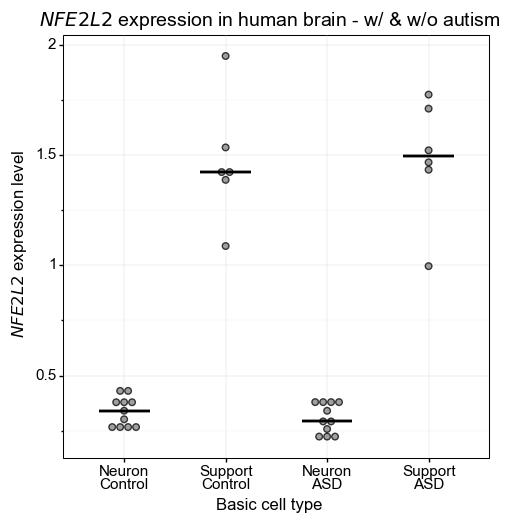

<ggplot: (8754943658439)>

In [172]:
# Now plot the data
gene = "NFE2L2"

# calculate expression level max
abs_max_expr = max(plotting_df[gene])
abs_min_expr = min(plotting_df[gene])

# Calculate optimal dot size and bin width for geom_dotplot
binsize_calc = signif((abs_max_expr - abs_min_expr)/87, digits = 2)
dotsize_calc = 1.5

# Now plot
Figure_2C = (
        p9.ggplot(data = plotting_df, mapping = p9.aes(x="Basic class sub", y=gene)) + 
        p9.geom_dotplot(data = plotting_df.loc[plotting_df["Basic class sub"] == "Neuron\nControl",], 
            color = "black", fill = "gray", alpha = 0.75, stackdir = "center", 
            binaxis = "y", dotsize = dotsize_calc, binwidth = binsize_calc, position = "identity", 
            stackgroups = True, stackratio = 1.2, binpositions = "all") +
        p9.geom_dotplot(data = plotting_df.loc[plotting_df["Basic class sub"] == "Support\nControl",], 
            color = "black", fill = "gray", alpha = 0.75, stackdir = "center", 
            binaxis = "y", dotsize = dotsize_calc, binwidth = binsize_calc, position = "identity",
            stackgroups = True, stackratio = 1.2, binpositions = "all") +
        p9.geom_dotplot(data = plotting_df.loc[plotting_df["Basic class sub"] == "Neuron\nASD",], 
            color = "black", fill = "gray", alpha = 0.75, stackdir = "center", 
            binaxis = "y", dotsize = dotsize_calc, binwidth = binsize_calc, position = "identity", 
            stackgroups = True, stackratio = 1.2, binpositions = "all") +
        p9.geom_dotplot(data = plotting_df.loc[plotting_df["Basic class sub"] == "Support\nASD",], 
            color = "black", fill = "gray", alpha = 0.75, stackdir = "center", 
            binaxis = "y", dotsize = dotsize_calc, binwidth = binsize_calc, position = "identity", 
            stackgroups = True, stackratio = 1.2, binpositions = "all") +
        p9.labs(x = "Basic cell type", y = str("$" + gene + "$ expression level"), 
            title = str("$" + gene + "$ expression in human brain - w/ & w/o autism")) +
        p9.geom_errorbar(data = summ_df, inherit_aes = False, size = 1,
            mapping = p9.aes(x="Basic class sub", ymin=str(gene + "_median"), ymax=str(gene + "_median"))) +
        p9.theme(strip_background = p9.element_blank(), strip_text = p9.element_blank(),
                 panel_spacing_x = 0.5, figure_size = (5.5, 5.5), 
                 legend_position = "none")
        )

Figure_2C

In [173]:
# Clean environment - check objects to delete with %who
del(NRF2_idx, Neuron_types, abs_max_expr, abs_min_expr, basic_class, binsize_calc, cell_clust_meta, \
    celltype_dict, dotsize_calc, gene, genes_df, human_expr_df, human_expr_orig, i, metadata, neur_ASD, \
    neur_ctrl, original_plotting_df, plotting_df, summ_df, supp_ASD, supp_ctrl)

<br>

## Mouse snATAC-seq data  

Next I plot ATAC-seq data from [CATLAS](http://catlas.org/mousebrain/#!/) where single nuclei ATAC-seq signal has been already aggregated by cell type.  The shell code below was used to generate the 'cropped' bigwig files for plotting, using the *bigWigToWig* and *wigToBigWig* commands from [UCSC tools](http://hgdownload.cse.ucsc.edu/admin/exe/).  

```bash
# Download CATLAS dataset of cell type-aggregated bigwigs
wget -r -nH --cut-dirs=5 http://catlas.org/catlas_downloads/mousebrain/bigwig/ -R index.html -R blank.gif -R index.html.tmp -R back.gif -R unknown.gif

# Download mm10 chromosome sizes
wget "https://hgdownload-test.gi.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes" -O mm10.len

# Now set the boundaries of the region I want to 'extract'/crop to in the final bigwigs
chrom_sizes="mm10.len" # file with chromosome sizes/coordinates for mm10
region_chrom="chr2"
region_start=75650000
region_end=75725000

# Make folder to store results in
outfolder="bigwigs"
mkdir -p "$outfolder"

# Now loop through all the bigwigs and crop and save to output folder
for file in `ls *.bw`
do
    # Set naming variables
    name=${file/.bw/}
    
    # mention file
    echo "# Working on $name."
    echo ""

    echo "# Crop the bigwig."
    bigWigToWig -chrom="$region_chrom" -start=$region_start -end=$region_end \
        "$file" "${name}.wig" 
    echo ""

    # Now convert back to bigwig - takes a long time
    echo "# Convert WIG back to bigWig."
    wigToBigWig "${name}.wig" "$chrom_sizes" "${outfolder}/${name}_Nrf2-region.bigwig"
    echo ""

    # Clean up
    rm "${name}.wig"
done
```

<br>

#### Set up data import  

Initialize some lists for storing bigwig names and location/path and then 'scan' the bigwig directory using *regex* and save the names and paths to these lists:  

In [174]:
# Initialize lists
bigwig_paths = []
bigwig_names = []
bigwig_dir = os.getcwd() + "/bigwigs/"

# Scan directory using regex and save to lists
regex_ATAC = re.compile("(.*)_Nrf2-region\.((bw)|(bigwig)|(bigWig))")
for root, dirs, files in os.walk(bigwig_dir):
    for file in files:
        if regex_ATAC.match(file):
            bigwig_paths.append(str(bigwig_dir+file))
            name = regex_ATAC.search(file)
            bigwig_names.append(name.group(1))

<br>

Check the lists to make sure they contain the relevant info:  

In [175]:
bigwig_paths[0:6]

['/mnt/Storage_Disk/Work/Slattery Lab/Publications/2022_NRF2-single-cell-brain/code/bigwigs/ASCG_Nrf2-region.bigwig',
 '/mnt/Storage_Disk/Work/Slattery Lab/Publications/2022_NRF2-single-cell-brain/code/bigwigs/ASCN_Nrf2-region.bigwig',
 '/mnt/Storage_Disk/Work/Slattery Lab/Publications/2022_NRF2-single-cell-brain/code/bigwigs/ASCW_Nrf2-region.bigwig',
 '/mnt/Storage_Disk/Work/Slattery Lab/Publications/2022_NRF2-single-cell-brain/code/bigwigs/CA1GL1_Nrf2-region.bigwig',
 '/mnt/Storage_Disk/Work/Slattery Lab/Publications/2022_NRF2-single-cell-brain/code/bigwigs/CA1GL2_Nrf2-region.bigwig',
 '/mnt/Storage_Disk/Work/Slattery Lab/Publications/2022_NRF2-single-cell-brain/code/bigwigs/CA1GL3_Nrf2-region.bigwig']

In [176]:
bigwig_names[0:6]

['ASCG', 'ASCN', 'ASCW', 'CA1GL1', 'CA1GL2', 'CA1GL3']

In [177]:
len(bigwig_paths)

160

<br>

#### Read in and process data  

Define a function named *bigwig_matrix* that will both: 1) import the bigwigs using *pyBigWig*, and 2) split or *tile* the signal data into a certain number of bins for a region of interest.  Specifically, each bin of *n* width is summarized by getting the *max* signal over the bin using the *stats* function from *pyBigWig*.  

For this function, the user needs to provide: a list of paths to the bigwigs of interest (*bw_list*), the region of interest (*chrom* = chromosome, *start* = starting base of the region, *end* = ending base of the region), the type of summarization (*avgtype* = see [*pyBigWig* documentation](https://github.com/deeptools/pyBigWig)), the total number of windows/*tiles* the region should be split into (*nBins*) and optionally the names of the bigwigs (*bw_names*) if you don't want the file names used.  

<br>

Use the function discussed above to compute the *binned/tiled* signal over the region of interest for all bigwigs, with each bigwig as its own row:

In [178]:
snATACseq_bw_matrix = bigwig_matrix(bw_list = bigwig_paths, chrom = "chr2", start=75650000, end=75725000, \
    avgtype = "max", nBins=2560, bw_names = bigwig_names)

<br>

Now summarize to get the 99% percentile signal of each bin (column) across all rows (bigwigs).  

In [179]:
snATACseq_summ = pd.DataFrame({"x" : range(0, 2560), "signal_max" : snATACseq_bw_matrix.quantile(q = 0.99, axis=0)})

<br>

Now I create a dataframe to isolate a sub-range of the columns to cluster on (I don't want to cluster using the entire region because a control region is included on the far left side):  

In [180]:
full_region = range(75650000,75725000)
region_ind=[]
region_seq=[]
i=0
for number in full_region:
    if number % 29 == 0:
        region_ind.append(i)
        i += 1
        region_seq.append(number)

In [181]:
tmp=pd.DataFrame([region_ind, region_seq]).T
tmp.loc[tmp[1] > 75675513, :].head()

,0,1
880,880,75675529
881,881,75675558
882,882,75675587
883,883,75675616
884,884,75675645


In [182]:
tmp.loc[tmp[1] < 75709641, :].tail()

,0,1
2052,2052,75709517
2053,2053,75709546
2054,2054,75709575
2055,2055,75709604
2056,2056,75709633


In [183]:
del(tmp)

<br>

## Make heatmaps and dotplots with *matplotlib* & *plotnine*

Now, use *matplotlib* to make simple and clustered version of the ATAC-seq heatmaps... including, adding a line plot of the 99th percentile signal above the plot, as well as the types of cells the rows correspond to on the right of the plot.  

First, read in Supplemental Table 3 from [Li, Y.E., et al. 2021. *Nature*.](https://doi.org/10.1038/s41586-021-03604-1) that will be used for annotating the basic cell types of each row.  

In [184]:
cell_attr = pd.read_excel("Supplementary Table 3 - Cell cluster annotation.xlsx")

Reassign the 'Class' attribute to a categorical variable class (for plotting).  

In [185]:
cell_class_df = cell_attr[['Class', 'Sub types']]
cell_class_df['Class'] = pd.Categorical(cell_class_df['Class'])
cell_class_df['Class_num'] = pd.Categorical(cell_class_df['Class']).codes

<br>

Plot Figure 5B & C with *plotnine*.  

In [186]:
# Now create a dataframe to show corresponding index positions and bases
tmp=pd.DataFrame([region_ind, region_seq]).T
tmp.loc[find_interval(intervals = tmp[1], value = 75675513, gtlt = 'less'), :]
# tmp.loc[find_interval(intervals = tmp[1], value = 75704641, gtlt = 'greater'), :]
tmp.loc[find_interval(intervals = tmp[1], value = 75704641 + 5000, gtlt = 'greater'), :]
Nrf2_locus_n_promoter = [int(tmp.loc[find_interval(intervals = tmp[1], value = 75675513, gtlt = 'less'), 0]),
    int(tmp.loc[find_interval(intervals = tmp[1], value = 75704641 + 5000, gtlt = 'greater'), 0])+1]

,0,1
879,879,75675500


,0,1
2057,2057,75709662


In [187]:
# Also find the 'coordinates' of each of the accessible regions near the promoter of Nrf2
# Control region (far downstream) = chr2:75658829-75659402
control_locus = [int(tmp.loc[find_interval(intervals = tmp[1], value = 75658829, gtlt = 'less'), 0]),
    int(tmp.loc[find_interval(intervals = tmp[1], value = 75659402, gtlt = 'greater'), 0])+1]

In [188]:
# Get the full span of the two promoter regions
Nrf2_promoter = [int(tmp.loc[find_interval(intervals = tmp[1], value = 75703338, gtlt = 'less'), 0]),
    int(tmp.loc[find_interval(intervals = tmp[1], value = 75705060, gtlt = 'greater'), 0])+1]

In [189]:
# Region 2 (downstream) = chr2:75703338-75703975
Nrf2_prom_2 = [int(tmp.loc[find_interval(intervals = tmp[1], value = 75703338, gtlt = 'less'), 0]),
    int(tmp.loc[find_interval(intervals = tmp[1], value = 75704163, gtlt = 'greater'), 0])+1]

In [190]:
# Region 1 (upstream) = chr2:75704374-75705060
Nrf2_prom_1 = [int(tmp.loc[find_interval(intervals = tmp[1], value = 75704374, gtlt = 'less'), 0]),
    int(tmp.loc[find_interval(intervals = tmp[1], value = 75705060, gtlt = 'greater'), 0])+1]
del(tmp)

In [191]:
# Using each of the regions above, summarize/get max signal
snATACseq_Nrf2_prom_summ = snATACseq_bw_matrix.loc[:, Nrf2_promoter[0]:Nrf2_promoter[1]].max(axis = 1)
snATACseq_Nrf2_prom1_summ = snATACseq_bw_matrix.loc[:, Nrf2_prom_1[0]:Nrf2_prom_1[1]].max(axis = 1)
snATACseq_Nrf2_prom2_summ = snATACseq_bw_matrix.loc[:, Nrf2_prom_2[0]:Nrf2_prom_2[1]].max(axis = 1)
snATACseq_control_summ = snATACseq_bw_matrix.loc[:, control_locus[0]:control_locus[1]].max(axis = 1)

In [192]:
# Add additional column, specifying if neuron or support
basic_class=[]
for i in cell_class_df["Class"]:
    if (i == "GABA"):
        basic_class.append("Neuron")
    elif (i == "Glutamate"):
        basic_class.append("Neuron")
    else:
        basic_class.append("Support")
cell_class_df["Basic class"] = basic_class
del(basic_class)

In [193]:
## Now make dotplots of the distributions from snATAC-seq aggregate data for the
## different subregions
# First put all data together
all_ATAC_df = pd.concat([pd.DataFrame(snATACseq_Nrf2_prom1_summ, copy = True).reset_index(
    ).rename(columns = {'index' : "Sub types", 0 : 'max_signal'}).assign(region = "$Nrf2$ downstream"), 
    pd.DataFrame(snATACseq_Nrf2_prom2_summ, copy = True).reset_index().rename(columns = 
    {'index' : "Sub types", 0 : 'max_signal'}).assign(region = "$Nrf2$ upstream")], axis = 0).merge(
    cell_class_df, how = "left")

# Reorder the region data so that it displays correctly in the plots
all_ATAC_df['region'] = pd.Categorical(all_ATAC_df['region'], categories = ["$Nrf2$ upstream", "$Nrf2$ downstream"])

In [194]:
# Create summary data frame
all_ATAC_df.columns
all_ATAC_summ = all_ATAC_df.drop(['Sub types', 'Class', 'Class_num'], \
    axis = 1).groupby(['region', 'Basic class'], axis = 0).agg(['median'])

# Collaps 'MultiIndex' returned by summarizing to flattened col index
all_ATAC_summ.columns = ['_'.join(col) for col in all_ATAC_summ.columns.values]
all_ATAC_summ.reset_index(inplace = True)

Index(['Sub types', 'max_signal', 'region', 'Class', 'Class_num',
       'Basic class'],
      dtype='object')

In [195]:
all_ATAC_df['region'].unique()

['$Nrf2$ downstream', '$Nrf2$ upstream']
Categories (2, object): ['$Nrf2$ upstream', '$Nrf2$ downstream']

In [196]:
# Now do statistics on these enhancers
x = all_ATAC_df.loc[(all_ATAC_df['Basic class'] == "Neuron") \
    & (all_ATAC_df['region'] == "$Nrf2$ downstream"), 'max_signal'].tolist()
y = all_ATAC_df.loc[(all_ATAC_df['Basic class'] == "Support") \
    & (all_ATAC_df['region'] == "$Nrf2$ downstream"), 'max_signal'].tolist()

# Do test 
print(f"NFE2L2 downstream enhancer\nNeurons vs Support: p-value = { mannwhitneyu(x, y)[1] },\n" \
      + f"Bonferroni padj = { mannwhitneyu(x, y)[1] * 2 }")

# Now do statistics on these enhancers
x = all_ATAC_df.loc[(all_ATAC_df['Basic class'] == "Neuron") \
    & (all_ATAC_df['region'] == "$Nrf2$ upstream"), 'max_signal'].tolist()
y = all_ATAC_df.loc[(all_ATAC_df['Basic class'] == "Support") \
    & (all_ATAC_df['region'] == "$Nrf2$ upstream"), 'max_signal'].tolist()

# Do test 
print(f"\nNFE2L2 upstream (promoter)\nNeurons vs Support: p-value = { mannwhitneyu(x, y)[1] },\n" \
      + f"Bonferroni padj = { mannwhitneyu(x, y)[1] * 2 }")

NFE2L2 downstream enhancer
Neurons vs Support: p-value = 4.249427932401006e-13,
Bonferroni padj = 8.498855864802012e-13

NFE2L2 upstream (promoter)
Neurons vs Support: p-value = 2.9442915207921127e-13,
Bonferroni padj = 5.888583041584225e-13


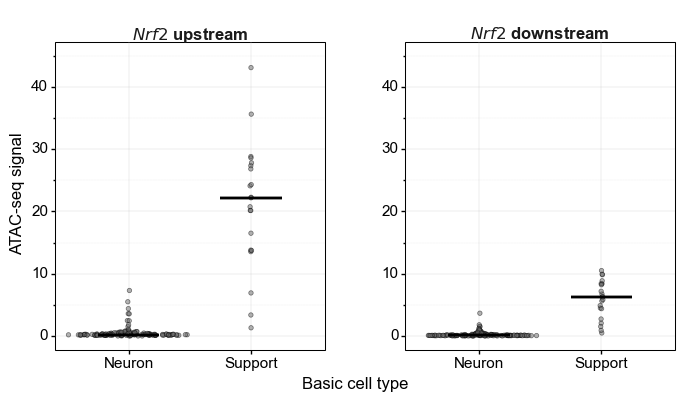

<ggplot: (8754949289816)>

In [197]:
# Now make plot of all regions, faceted vertically
Figure_5BC = (
    p9.ggplot(data = all_ATAC_df, mapping = p9.aes(x="Basic class", y="max_signal", group = "Basic class")) + 
    p9.geom_sina(alpha = 0.5, maxwidth = 1, size = 1.5, stroke = 0.3,
        fill = "dimgray", color = "black", method = "density", scale = "area") + 
    p9.labs(x = "Basic cell type", y = "ATAC-seq signal", 
        title = "Accessibility of regions near $Nrf2$ in human brain cell types") +
    p9.geom_errorbar(data = all_ATAC_summ, inherit_aes = False, size = 1,
        mapping = p9.aes(x="Basic class", ymin="max_signal_median", ymax="max_signal_median")) +
    p9.facet_wrap(facets = "~region", nrow = 1, scales = "free") +
    p9.coord_cartesian(ylim = (0, 45)) +
    p9.theme(plot_title = p9.element_blank(), legend_position = "none",
        strip_text_x = p9.element_text(size = 12, margin = {'t' : 5, 'b' : 6, 'l' : 5, 'r' : 5}),
        strip_background = p9.element_blank(), subplots_adjust = {'wspace' : 0.3},
        figure_size = (8, 4))
    )

Figure_5BC

<br>

Plot Figure 5A with *matplotlib*.  

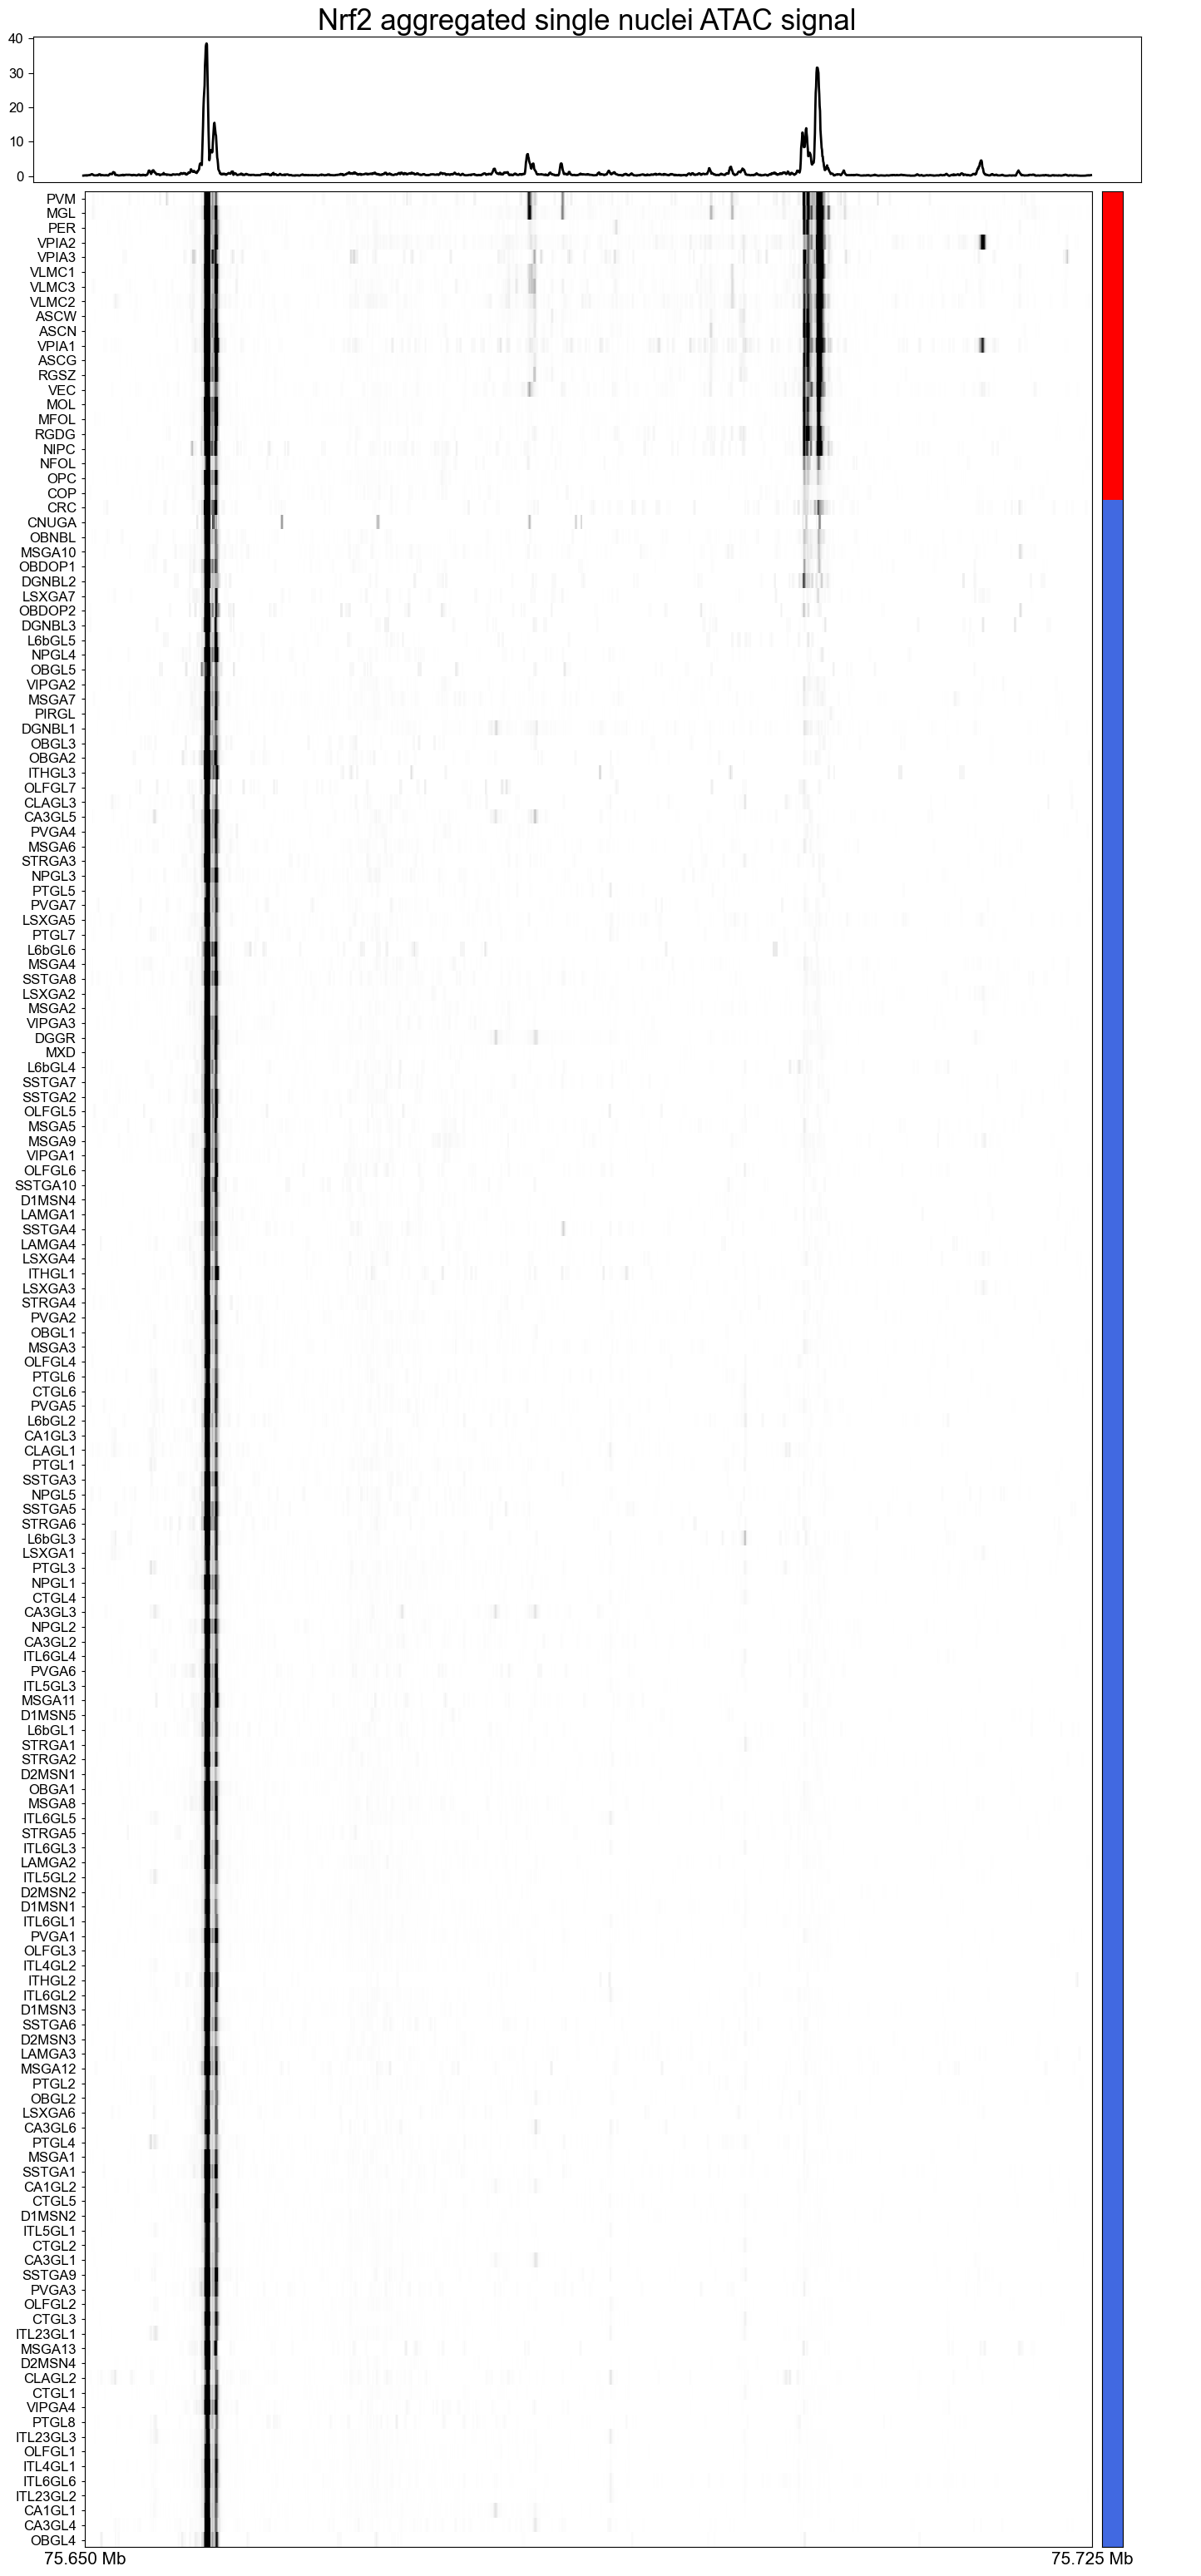

In [198]:
# Set display parameters
mpl.rcParams["axes.titlesize"] = 25
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["xtick.labelsize"] = 15
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 15
mpl.rcParams["image.cmap"] = "Greys"
mpl.rcParams["lines.markersize"] = 3
mpl.rcParams["lines.linewidth"] = 2

# Load the data - and column and row names
# Check number of columns
snATACseq_bw_matrix.shape

# Assign column names, only keep start and end point names, make all else blank
feature_names = list(itertools.chain.from_iterable(itertools.repeat(x,1) if isinstance(x,str) 
    else x for x in ["75.650 Mb", list(itertools.repeat('', 2558)), "75.725 Mb"]));

# Assign row names (cell type clusters)
labels = bigwig_names

# Make the data pandas objects
data = pd.DataFrame(np.array(snATACseq_bw_matrix), columns=feature_names, index = labels);
labels = pd.Series(labels);

# Order the data by neuron then support cell and max signal within Nrf2 promoter regions
row_order = pd.DataFrame(snATACseq_Nrf2_prom_summ, copy = True).reset_index().rename(columns = 
    {'index' : "Sub types", 0 : "sum_signal"}).merge(cell_class_df[['Class', 'Sub types', 'Basic class']], 
    how = "left");
row_order.sort_values( ['Basic class', 'sum_signal'], ascending = [False, False], 
    axis = 0, inplace = True);

# Make the heatmap
data = data.iloc[row_order.index,:];
labels = labels[row_order.index];
fig = plt.figure(figsize = (20, 40));
ax = plt.subplot2grid(shape = (50, 100), loc = (3, 4), rowspan = 46, colspan = 86);
ax2 = plt.subplot2grid(shape = (50, 100), loc = (0, 0), rowspan = 3, colspan = 86); 
profile = ax2.plot(snATACseq_summ['x'], snATACseq_summ['signal_max'], color = "black");
ax2.set_xticks([]);
heatmap = ax.imshow(data, origin="upper", interpolation = "none", aspect="auto", vmin = 0, vmax = 10);

# Show the feature names on the x ticks and cluster name on y ticks and
# set custom tick sizes
ax.xaxis.set_tick_params(which = 'both', length = 0);
ax.yaxis.set_tick_params(which = 'major', length = 3);
ax.set_yticks(np.arange(data.index.size));
ax.set_xticks(np.arange(data.columns.size));
ax.set_xticklabels(data.columns);
ax.set_yticklabels(data.index, fontdict = {});

# # Add heatmap colorbar to the right
divider = make_axes_locatable(ax);

# Combine data names and class attributes to reorder class heatmap
class_mat = pd.DataFrame({'Sub types' : np.array(data.index)}).merge(cell_class_df);

# Add bar indicating classes to the right
class_ax = divider.append_axes("right", size="2%",pad = "1%");

# Need to make the series into a column vector to work with imshow
# Use a different color scheme for this axis
cmp = mpl.colors.ListedColormap(['royalblue', 'royalblue', 'red']);
class_ax.imshow(np.array(class_mat['Class_num'])[:,None], aspect="auto", cmap=cmp);
class_ax.set_xticks([]);
class_ax.set_yticks([]);

# add additional padding to the right of class colorbar
class_ax_pad = divider.append_axes("right", size="6%",pad = "1%");
class_ax_pad.spines["top"].set_visible(False)
class_ax_pad.spines["right"].set_visible(False)
class_ax_pad.spines["bottom"].set_visible(False)
class_ax_pad.spines["left"].set_visible(False)
class_ax_pad.set_xlabel("")
class_ax_pad.set_ylabel("")
class_ax_pad.set_xticks([]);
class_ax_pad.set_yticks([]);

# Set title
ax2.set_title("Nrf2 aggregated single nuclei ATAC signal");

<br>

Now, plot the profile of 99th percentile signal, heatmap of signal across bigwigs, dendrogram of cell clustering, and basic cell types all together using *matplotlib*.  

This corresponds to Figure S5.

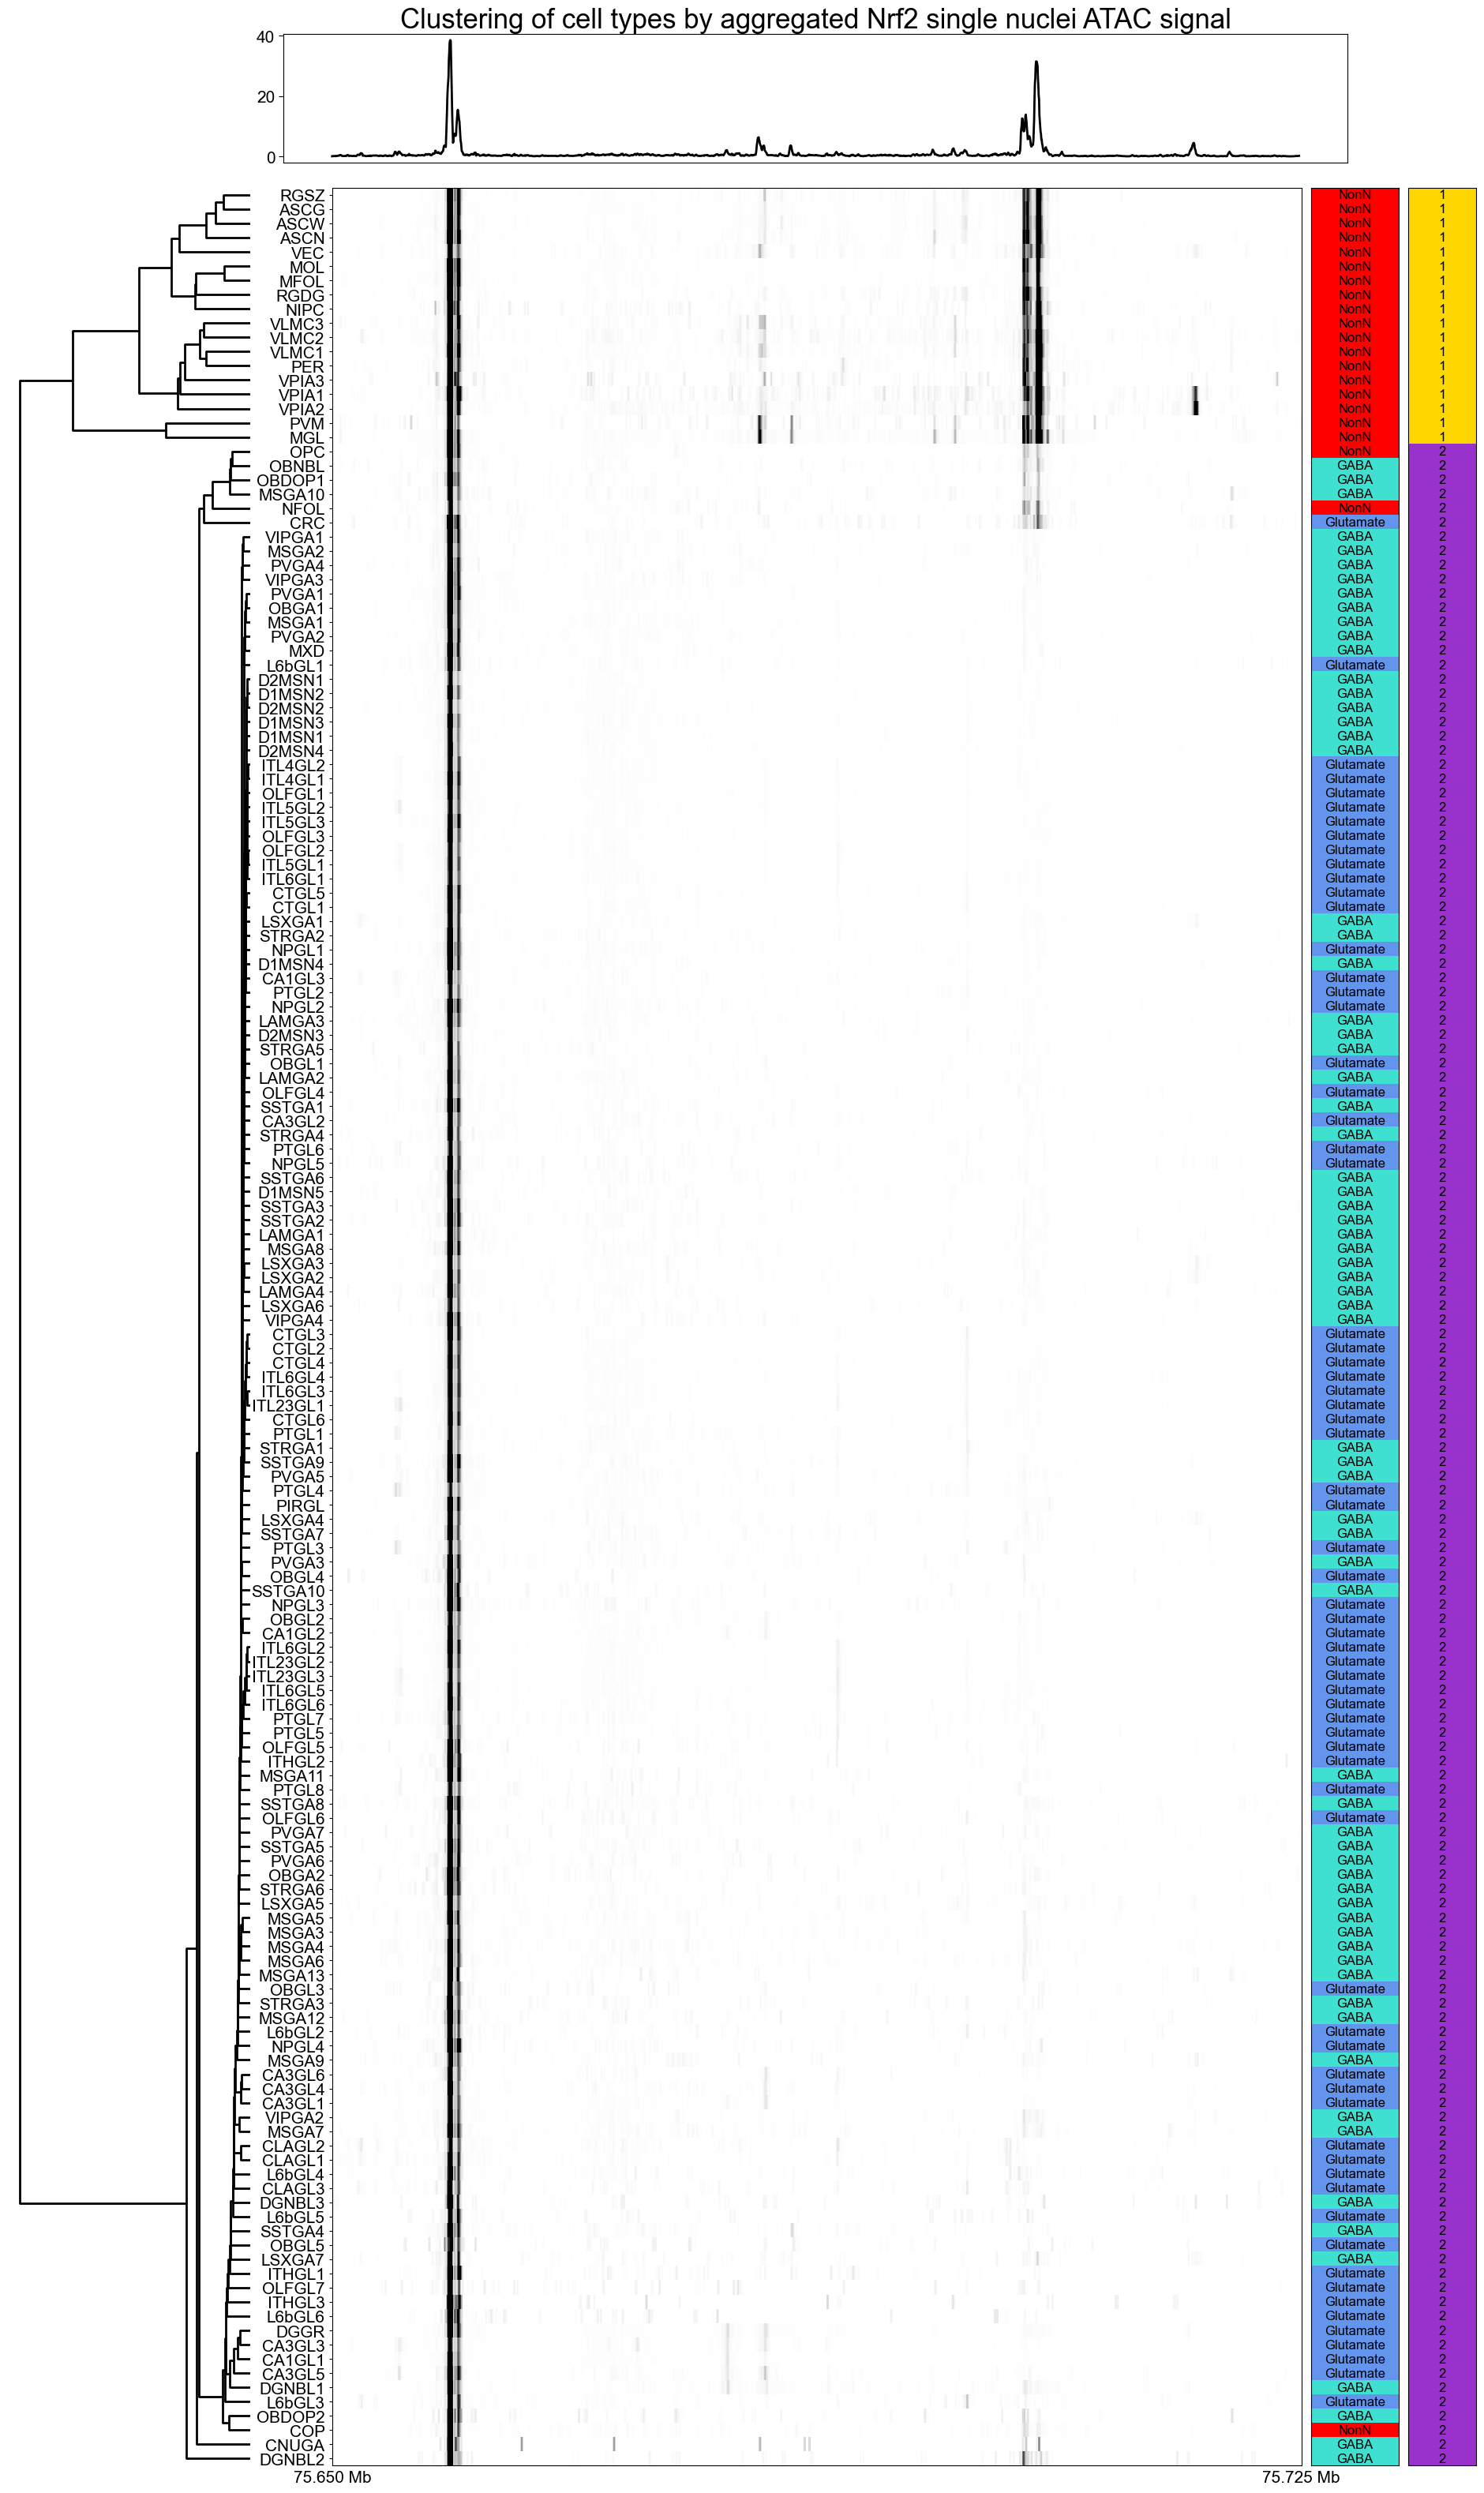

In [199]:
# Customize some plotting parameters
mpl.rcParams["axes.titlesize"] = 25
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["xtick.labelsize"] = 15
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["legend.fontsize"] = 15
mpl.rcParams["figure.figsize"] = (24, 40)
mpl.rcParams["image.cmap"] = "Greys"
mpl.rcParams["lines.markersize"] = 3
mpl.rcParams["lines.linewidth"] = 2

# Check size of matrix for pltting heatmap
snATACseq_bw_matrix.shape

# Assign column names, only keep start and end point names, make all else blank
feature_names = list(itertools.chain.from_iterable(itertools.repeat(x,1) if isinstance(x,str) 
    else x for x in ["75.650 Mb", list(itertools.repeat('', 2558)), "75.725 Mb"]));

# Assign row names (cell type clusters)
labels = bigwig_names

# Make the data pandas objects
data = pd.DataFrame(np.array(snATACseq_bw_matrix), columns=feature_names, index = labels);
labels = pd.Series(labels);

# Row-cluster the data
row_link = hc.linkage(snATACseq_bw_matrix.loc[:,879:2059], metric = "euclidean", method = "average");

# Make the dendrogram, but don't plot it yet
row_dendro = hc.dendrogram(row_link, no_plot=True);

# Row order needs to be inverted to display correctly with the dendrogram
row_order = row_dendro["leaves"][::-1];

# Reorder dataframe and row labels
data = data.iloc[row_order,:];
labels = labels[row_order];

# Make the heatmap and line plot above
fig = plt.figure(figsize = (24, 40));
ax = plt.subplot2grid(shape = (16, 80), loc = (1, 0), rowspan = 27, colspan = 80);
ax2 = plt.subplot2grid(shape = (16, 80), loc = (0, 15), rowspan = 1, colspan = 58);
profile = ax2.plot(snATACseq_summ['x'], snATACseq_summ['signal_max'], color = "black");
ax2.set_xticks([]);
heatmap = ax.imshow(data, origin="upper", interpolation = "none", aspect="auto", vmin = 0, vmax = 10);

# Show the feature names on the x ticks and cluster name on y ticks and
# set custom tick sizes
ax.xaxis.set_tick_params(which = 'both', length = 0);
ax.yaxis.set_tick_params(which = 'major', length = 3);
ax.set_yticks(np.arange(data.index.size));
ax.set_xticks(np.arange(data.columns.size));
ax.set_xticklabels(data.columns);
ax.set_yticklabels(data.index);
ax.set_yticklabels(data.index, fontdict = {});

# Make it so different annotations can be assigned to different sides/axes
divider = make_axes_locatable(ax);

# Add dendrogram for row clustering
row_ax = divider.append_axes("left", size="25%", pad = "8.5%");
hc.dendrogram(row_link, orientation="left", ax=row_ax, color_threshold=0, above_threshold_color="black");
# row_ax.invert_yaxis()
row_ax.axis("off");

# Combine data names and class attributes to reorder class heatmap
class_mat = pd.DataFrame({'Sub types' : np.array(data.index)}).merge(cell_class_df);

# Add bar/heatmap indicating classes to the right
class_ax = divider.append_axes("right", size="9%",pad = "1%");

# Use a different color scheme for this axis
cmp = mpl.colors.ListedColormap(['turquoise', 'cornflowerblue', 'red']);
class_ax.imshow(np.array(class_mat['Class_num'])[:,None], aspect="auto", cmap=cmp);

# Loop over data dimensions and create text annotations.
for i in range(160):
    text = class_ax.text(0, i, np.array(class_mat['Class'])[:,None][i, 0],
        ha="center", va="center", color="black");
del(i)

# Remove ticks
class_ax.set_xticks([]);
class_ax.set_yticks([]);

# Add bar indicating classes to the right
class_ax_2 = divider.append_axes("right", size="7%",pad = "1%");

# Need to make the series into a column vector to work with imshow
# Use a different color scheme for this axis
partitions = np.array(list(itertools.chain.from_iterable([np.repeat(1,18), 
    np.repeat(2,142)])));
cmp2 = mpl.colors.ListedColormap(['gold', 'darkorchid']);
class_ax_2.imshow(partitions[:,None], aspect="auto", cmap=cmp2);

# Loop over data dimensions and create text annotations.
for i in range(160):
    text = class_ax_2.text(0, i, partitions[:,None][i, 0], ha="center", va="center", color="black");
del(i)

# Remove ticks
class_ax_2.set_xticks([]);
class_ax_2.set_yticks([]);

# Set title
ax2.set_title("Clustering of cell types by aggregated Nrf2 single nuclei ATAC signal");

<br>

## DropViz

Now I make the final figure of the paper, Figure S1, which is another mouse brain scRNA-seq experiment from [Dropviz](http://dropviz.org).

In [200]:
# Read in the data
expr_df = pd.read_excel(io = "NRF2-NFE2L2_DropViz.xlsx", sheet_name = "NRF2-NFE2L2_DropViz")

# Now make plotting dataframe to add attributes to for plotting
plotting_df = pd.DataFrame(expr_df, copy = True) 

# Check
plotting_df.columns
plotting_df.head
plotting_df.shape

Index(['Region', 'Class', 'Cluster', 'Nfe2l2 Amount', 'Nfe2l2 P-Val'], dtype='object')

<bound method NDFrame.head of          Region            Class                    Cluster  Nfe2l2 Amount  \
0    Cerebellum        Astrocyte  BergmannGlia_Gpr37l1 [#7]       2.772589   
1    Cerebellum        Astrocyte        Astrocyte_Gja1 [#8]       2.639057   
2    Cerebellum   Choroid_Plexus    Choroid_Plexus_Ttr [#9]       1.609438   
3    Cerebellum      Endothelial     Endothelial_Flt1 [#10]       2.833213   
4    Cerebellum  Fibroblast-Like  Fibroblast-Like_Dcn [#11]       2.197225   
..          ...              ...                        ...            ...   
111    Thalamus           Neuron           Neuron_Rora [#2]       0.000000   
112    Thalamus           Neuron      Neuron_Gad2-Ahi1 [#3]       0.000000   
113    Thalamus  Oligodendrocyte   Oligodendrocyte_Tfr [#8]       2.079442   
114    Thalamus  Oligodendrocyte   Oligodendrocyte_Mbp [#9]       1.386294   
115    Thalamus   Polydendrocyte   Polydendrocyte_Tnr [#12]       1.386294   

      Nfe2l2 P-Val  
0    3.92219

(116, 5)

In [201]:
# Check all the possible basic cell-type classes
pd.unique(plotting_df["Class"])

# Make a new column, and define things as Neuron or Non-neuron
basic_class=[]
for i in plotting_df["Class"]:
    if(i == "Neuron"):
        basic_class.append("Neuron")
    else:
        basic_class.append("Support")
plotting_df["Basic class"] = basic_class

# Check
plotting_df.head()

array(['Astrocyte', 'Choroid_Plexus', 'Endothelial', 'Fibroblast-Like',
       'Microglia_Macrophage', 'Neuron', 'Oligodendrocyte_Polydendrocyte',
       'Mural_Fibroblast-Like', 'Oligodendrocyte', 'Polydendrocyte',
       'Mural', 'Ependyma', 'Neurogenesis'], dtype=object)

,Region,Class,Cluster,Nfe2l2 Amount,Nfe2l2 P-Val,Basic class
0,Cerebellum,Astrocyte,BergmannGlia_Gpr37l1 [#7],2.772589,3.922195e-225,Support
1,Cerebellum,Astrocyte,Astrocyte_Gja1 [#8],2.639057,7.083317e-16,Support
2,Cerebellum,Choroid_Plexus,Choroid_Plexus_Ttr [#9],1.609438,3.029754e-02,Support
3,Cerebellum,Endothelial,Endothelial_Flt1 [#10],2.833213,5.287130e-35,Support
4,Cerebellum,Fibroblast-Like,Fibroblast-Like_Dcn [#11],2.197225,8.608376e-09,Support


In [202]:
# Create 'backup'
orig_plotting_df = pd.DataFrame(plotting_df, copy = True)

In [203]:
# Make summary dataframe also
plotting_df.columns
summ_df = plotting_df.drop(['Region', 'Class', 'Cluster', 'Nfe2l2 P-Val'], axis = 1\
    ).groupby(['Basic class'], axis = 0, ).agg(['mean','median'])

# Collaps 'MultiIndex' returned by summarizing to flattened col index
summ_df.columns = ['_'.join(col) for col in summ_df.columns.values]
summ_df.reset_index(inplace = True)

# Check
summ_df

Index(['Region', 'Class', 'Cluster', 'Nfe2l2 Amount', 'Nfe2l2 P-Val',
       'Basic class'],
      dtype='object')

,Basic class,Nfe2l2 Amount_mean,Nfe2l2 Amount_median
0,Neuron,0.174689,0.000000
1,Support,2.275621,2.249905


In [204]:
# Now do statistics on this expression data
x = plotting_df.loc[(plotting_df['Basic class'] == "Neuron"), 'Nfe2l2 Amount'].tolist()
y = plotting_df.loc[(plotting_df['Basic class'] == "Support"), 'Nfe2l2 Amount'].tolist()

# How many genes
print("There are 32307 genes total in Dropviz\n")

# Do test and also Bonferroni correction
print(f"NFE2L2: Neuron vs Support Dropviz p-value = { mannwhitneyu(x, y)[1] }")
print(f"\nNFE2L2: Neuron vs Support Dropviz Bonferroni padj = { mannwhitneyu(x, y)[1] * 32307 }")

There are 32307 genes total in Dropviz

NFE2L2: Neuron vs Support Dropviz p-value = 8.10055958707155e-19

NFE2L2: Neuron vs Support Dropviz Bonferroni padj = 2.6170477857952057e-14


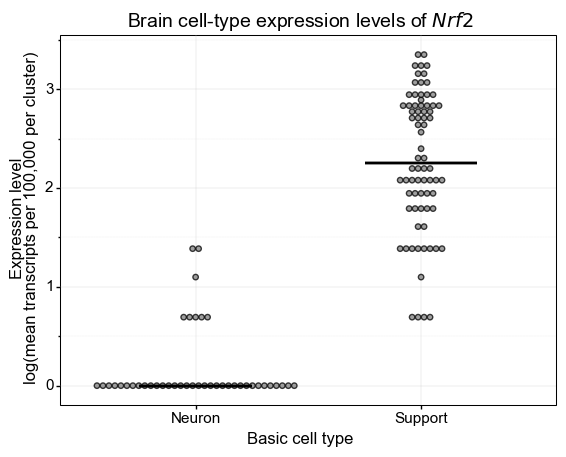

<ggplot: (8754919068287)>

In [205]:
# Now plot - 'histogram-like' dotplots
# Have to add the groups on x axis separately so they don't do the 'binning' across
# the categories and put the dots off to the side of center for each group
Figure_S1 = (
    p9.ggplot(data = plotting_df, mapping = p9.aes(x="Basic class", y="Nfe2l2 Amount")) + 
    p9.geom_dotplot(data = plotting_df.loc[plotting_df["Basic class"] == "Neuron",], 
        stackdir = "center", color = "black", fill = "gray", alpha = 0.75,
        binaxis = "y", dotsize = 1.1, binwidth = 0.05, position = "identity",
        stackgroups = True, stackratio = 1.1, binpositions = "all") + 
    p9.geom_dotplot(data = plotting_df.loc[plotting_df["Basic class"] != "Neuron",], 
        stackdir = "center", color = "black", fill = "gray", alpha = 0.75,
        binaxis = "y", dotsize = 1.1, binwidth = 0.05, position = "identity",
        stackgroups = True, stackratio = 1.1, binpositions = "all") + 
    p9.labs(x = "Basic cell type", 
        y = "Expression level\nlog(mean transcripts per 100,000 per cluster)", 
        title = "Brain cell-type expression levels of $Nrf2$") +
    p9.geom_errorbar(data = summ_df, inherit_aes = False, size = 1,
        mapping = p9.aes(x="Basic class", ymin="Nfe2l2 Amount_median", ymax="Nfe2l2 Amount_median"))
    )

# Plot
Figure_S1